# Final Project

*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas.*

## Group Members

*Group submission is highly encouraged. If you submit as part of group, list all group members here. Groups can comprise up to 5 students.*

* Adam Applegate
* Beatrix Brahms
* 

---

## Sparse Interactions

### Preparation (3pts)

Review the paper [The Kernel Interaction Trick: Fast Bayesian Discovery of Pairwise Interactions in High Dimensions](https://arxiv.org/abs/1905.06501) by Agrawal et al. (2019). Start with the general concepts and then go into the finer details.

When you feel comfortable with the content, answer the following questions:

1. Why does the Gaussian scale mixture prior promote sparsity of the regression coefficients $\theta$?
2. What are the required properties of the model in Eq. (3) that allow it to be rewritten in the form of Eq. (6)?
3. What are the conceptual and practical limitation of the approach?

**Hint:** Some of the answers may require parsing the relevant references.

**1** Based on Griffin and Brown (2017), hierarchical priors in Bayesian regression are dependent on the size of the coefficients, where the hyperparameters control for shrinkage of coefficients similar to a penalty term. In particular, a small estimated variance in coefficients would enforce some shrinkage and likely yield a sparser model. The Gaussian scale mixture is in fact just a special case of hierarchical priors, in which $\tau$ and $\Sigma_\tau$ control the shrinkage of $\theta$. 

**2** This result is possible due to the Proposition 4.1 in Agrawal et al (2019). The function $\Phi_2$ is designed such that it can be rewritten as a GP, namely the GP $g = \theta^T\Phi_2$. Then, the equivalence is completed by using the covariance $k_\tau(x^{(i)},x^{(j})=\Phi_2(x^{(i)})\Sigma_\tau\Phi_2(x^{(j)})$ for $g\sim GP(0,k_\tau)$. Based on the weight-space view of GP from Rasmussen and Williams (2006), for any draw $g|\tau\sim N(0,k_\tau)$, there exists a parameter vector $\theta$ such that $g=\theta^T\Phi_2$. This completes the re-parametrization from Equation (3) to (6). 

**3** In the discussion of Priors for Related Predictors in Chipman (1996), one practical instance in which the strong hierarchy property would fail is in atmospheric sciences. A key relation is $log(Y)=log(A)+BC$, in which the interaction term $BC$ would not satisfy strong hierarchy, and thus could not be properly modeled using this approach. One conceptual limitation of the approach is the use of pairwise interactions. On one hand, the dimension of the parameter space is increased from $p$ to $\frac{p(p+1)}{2}$, which could be extremely computationally expensive when $p$ is not even that large; on the other hand, there may be instances that involve higher-order polynomial interactions, and thus this model of at-most pairwise interactions could be too limited in its scope. In addition, the runtime is cubic and memory is quadraic with respect to the sample size $N$, which is as good or worse than other sampling methods it is compared to (NAIVE, WOODBURY, and FULL)

### Code adaptation (3pts)

The method SKIM from chapter 6 has been implemented in jax/Numpyro [here](https://pyro.ai/numpyro/examples/sparse_regression.html). Review the code and recognize how the theoretical concepts of the Kernel Interaction Trick and the specific features of SKIM have been implemented. Then copy the code to this notebook and modify it so that you can execute the provided test example inline. Confirm that you get a result comparable to theirs.

The last step of their example analysis (sampling from the posterior with the method `sample_theta_space`) often returns `nan`s. It also reports the posterior for all $\theta$ (active and inactive ones), and only for one sample at a time. That's really clunky. Modify this function to produce flat posteriors samples from the MCMC (with an arbitrary length of samples) but only for the active direct and pairwise interaction terms. Visualize the posterior from the example with `corner`.

### Application (4pts)

COVID-19 dominates the news, with many countries still reporting rising case numbers. One surprising fact is that the mortality rate (i.e. the fraction of the infected who have died, also called **case-fatality ratio**) differs *a lot* between countries, from 15% to less than 1%. Find out which features (such as age distribution, population health indices, economic factors, COVID-specific factors ...) influences that rate.

This task has three parts:

* Think about what possible effects there could be.
* Find suitable data for as many countries as possible in public data archives. Combine them into a master data set.
* Perform the inference.

You will probably need to iterate and refine along the way. Explain your reasoning about the kinds of features you decided to include in your analysis. Then report the most important direct and pairwise interactions. Visualized the posterior samples with `corner`.

**Note:** This is an exploratory study. If your approach is sound, but the data don't show firm trends, partial points will be awarded. Include your final data compilation as a separate file with your submission.

**Hints:** 

* Start [here](https://coronavirus.jhu.edu/data/mortality).
* Don't forget to standardize the data by subtracting the mean and dividing by the standard deviation.

In [1]:
# %matplotlib inline

In [2]:
import argparse
import itertools
import os
import time

import numpy as onp

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import corner

def dot(X, Z):
    return np.dot(X, Z[..., None])[..., 0]


# The kernel that corresponds to our quadratic regressor. (According to prop 6.1)
def kernel(X, Z, eta1, eta2, c, jitter=1.0e-6):
    eta1sq = np.square(eta1)
    eta2sq = np.square(eta2)
    k1 = 0.5 * eta2sq * np.square(1.0 + dot(X, Z))
    k2 = -0.5 * eta2sq * dot(np.square(X), np.square(Z))
    k3 = (eta1sq - eta2sq) * dot(X, Z)
    k4 = np.square(c) - 0.5 * eta2sq
    if X.shape == Z.shape:
        k4 += jitter * np.eye(X.shape[0])
    return k1 + k2 + k3 + k4


# Most of the model code is concerned with constructing the sparsity inducing prior.
def model(X, Y, hypers):
    # Here X is the design matrix with N x p dimensions
    # read off dimensions P and N
    # S ??? - like a sparsity coeff? 
    S, P, N = hypers['expected_sparsity'], X.shape[1], X.shape[0]

    # sample variables from p. 18
    sigma = numpyro.sample("sigma", dist.HalfNormal(hypers['alpha3']))
    phi = sigma * (S / np.sqrt(N)) / (P - S)
    eta1 = numpyro.sample("eta1", dist.HalfCauchy(phi))

    msq = numpyro.sample("msq", dist.InverseGamma(hypers['alpha1'], hypers['beta1']))
    xisq = numpyro.sample("xisq", dist.InverseGamma(hypers['alpha2'], hypers['beta2']))

    eta2 = np.square(eta1) * np.sqrt(xisq) / msq

    lam = numpyro.sample("lambda", dist.HalfCauchy(np.ones(P)))
    kappa = np.sqrt(msq) * lam / np.sqrt(msq + np.square(eta1 * lam))

    # sample observation noise
    var_obs = numpyro.sample("var_obs", dist.InverseGamma(hypers['alpha_obs'], hypers['beta_obs']))

    # compute kernel (as in proposition 6.1)
    kX = kappa * X
    k = kernel(kX, kX, eta1, eta2, hypers['c']) + var_obs * np.eye(N)
    assert k.shape == (N, N)

    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", dist.MultivariateNormal(loc=np.zeros(X.shape[0]), covariance_matrix=k),
                   obs=Y)

    
    
# I guess broadly corresponds to Section 5 of the paper??

# Compute the mean and variance of coefficient theta_i (where i = dimension) for a
# MCMC sample of the kernel hyperparameters (eta1, xisq, ...).
# Compare to theorem 5.1 in reference [1].
def compute_singleton_mean_variance(X, Y, dimension, msq, lam, eta1, xisq, c, var_obs):
    P, N = X.shape[1], X.shape[0]

    probe = np.zeros((2, P))
    probe = jax.ops.index_update(probe, jax.ops.index[:, dimension], np.array([1.0, -1.0]))

    eta2 = np.square(eta1) * np.sqrt(xisq) / msq
    kappa = np.sqrt(msq) * lam / np.sqrt(msq + np.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + var_obs * np.eye(N)
    k_xx_inv = np.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = np.array([0.50, -0.50]) ## a = (1/2, -1/2)
    mu = np.matmul(k_probeX, np.matmul(k_xx_inv, Y))
    mu = np.dot(mu, vec)

    var = k_prbprb - np.matmul(k_probeX, np.matmul(k_xx_inv, np.transpose(k_probeX)))
    var = np.matmul(var, vec)
    var = np.dot(var, vec)

    return mu, var


# Compute the mean and variance of coefficient theta_ij for a MCMC sample of the
# kernel hyperparameters (eta1, xisq, ...). Compare to theorem 5.1 in reference [1].
def compute_pairwise_mean_variance(X, Y, dim1, dim2, msq, lam, eta1, xisq, c, var_obs):
    # Here X is the design matrix with N x p dimensions
    # read off dimensions P and N
    P, N = X.shape[1], X.shape[0]

    probe = np.zeros((4, P))
    probe = jax.ops.index_update(probe, jax.ops.index[:, dim1], np.array([1.0, 1.0, -1.0, -1.0]))
    probe = jax.ops.index_update(probe, jax.ops.index[:, dim2], np.array([1.0, -1.0, 1.0, -1.0]))
    
    
    # compute eta2 and kappa from p. 18 

    eta2 = np.square(eta1) * np.sqrt(xisq) / msq
    kappa = np.sqrt(msq) * lam / np.sqrt(msq + np.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    # ?? compute a bunch of matrices w/ kernels ??
    k_xx = kernel(kX, kX, eta1, eta2, c) + var_obs * np.eye(N)
    k_xx_inv = np.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = np.array([0.25, -0.25, -0.25, 0.25]) ## ?? not sure why not (-1/2, 1/2, -1, 1) ??
    mu = np.matmul(k_probeX, np.matmul(k_xx_inv, Y))
    mu = np.dot(mu, vec)

    var = k_prbprb - np.matmul(k_probeX, np.matmul(k_xx_inv, np.transpose(k_probeX)))
    var = np.matmul(var, vec)
    var = np.dot(var, vec)

    return mu, var


# Sample coefficients theta from the posterior for a given MCMC sample.
# The first P returned values are {theta_1, theta_2, ...., theta_P}, while
# the remaining values are {theta_ij} for i,j in the list `active_dims`,
# sorted so that i < j.
def sample_theta_space(X, Y, active_dims, msq, lam, eta1, xisq, c, var_obs): #(section B.5) ?
    # Here X is the design matrix with N x p dimensions
    # read off dimensions P and N
    # and number of active dimensions? 
    P, N, M = X.shape[1], X.shape[0], len(active_dims)
    
    # the total number of coefficients we return
    num_coefficients = P + M * (M - 1) // 2

    probe = np.zeros((2 * P + 2 * M * (M - 1), P))
    vec = np.zeros((num_coefficients, 2 * P + 2 * M * (M - 1)))
    start1 = 0
    start2 = 0

    for dim in range(P):
        probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 2, dim], np.array([1.0, -1.0]))
        vec = jax.ops.index_update(vec, jax.ops.index[start2, start1:start1 + 2], np.array([0.5, -0.5]))
        start1 += 2
        start2 += 1

    for dim1 in active_dims:
        for dim2 in active_dims:
            if dim1 >= dim2:
                continue
            probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 4, dim1],
                                         np.array([1.0, 1.0, -1.0, -1.0]))
            probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 4, dim2],
                                         np.array([1.0, -1.0, 1.0, -1.0]))
            vec = jax.ops.index_update(vec, jax.ops.index[start2, start1:start1 + 4],
                                       np.array([0.25, -0.25, -0.25, 0.25]))
            start1 += 4
            start2 += 1

    eta2 = np.square(eta1) * np.sqrt(xisq) / msq
    kappa = np.sqrt(msq) * lam / np.sqrt(msq + np.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + var_obs * np.eye(N)
    k_xx_inv = np.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    mu = np.matmul(k_probeX, np.matmul(k_xx_inv, Y))
    mu = np.sum(mu * vec, axis=-1)

    covar = k_prbprb - np.matmul(k_probeX, np.matmul(k_xx_inv, np.transpose(k_probeX)))
    covar = np.matmul(vec, np.matmul(covar, np.transpose(vec)))
    L = np.linalg.cholesky(covar)

    # sample from N(mu, covar)
    sample = mu + np.matmul(L, onp.random.randn(num_coefficients))

    return sample


# Helper function for doing HMC inference
def run_inference(model, args, rng_key, X, Y, hypers):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(kernel, args.num_warmup, args.num_samples, num_chains=args.num_chains,
                progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key, X, Y, hypers)
    mcmc.print_summary()
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc.get_samples()


# Get the mean and variance of a gaussian mixture
def gaussian_mixture_stats(mus, variances):
    mean_mu = np.mean(mus)
    mean_var = np.mean(variances) + np.mean(np.square(mus)) - np.square(mean_mu)
    return mean_mu, mean_var


# Create artificial regression dataset where only S out of P feature
# dimensions contain signal and where there is a single pairwise interaction
# between the first and second dimensions.
def get_data(N=20, S=2, P=10, sigma_obs=0.05):
    assert S < P and P > 1 and S > 0
    onp.random.seed(0)

    X = onp.random.randn(N, P)
    # generate S coefficients with non-negligible magnitude
    W = 0.5 + 2.5 * onp.random.rand(S)
    # generate data using the S coefficients and a single pairwise interaction
    Y = onp.sum(X[:, 0:S] * W, axis=-1) + X[:, 0] * X[:, 1] + sigma_obs * onp.random.randn(N)
    Y -= np.mean(Y)
    Y_std = np.std(Y)

    assert X.shape == (N, P)
    assert Y.shape == (N,)

    return X, Y / Y_std, W / Y_std, 1.0 / Y_std


# Helper function for analyzing the posterior statistics for coefficient theta_i
def analyze_dimension(samples, X, Y, dimension, hypers):
    vmap_args = (samples['msq'], samples['lambda'], samples['eta1'], samples['xisq'], samples['var_obs'])
    mus, variances = vmap(lambda msq, lam, eta1, xisq, var_obs:
                          compute_singleton_mean_variance(X, Y, dimension, msq, lam,
                                                          eta1, xisq, hypers['c'], var_obs))(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = np.sqrt(variance)
    return mean, std


# Helper function for analyzing the posterior statistics for coefficient theta_ij
def analyze_pair_of_dimensions(samples, X, Y, dim1, dim2, hypers):
    vmap_args = (samples['msq'], samples['lambda'], samples['eta1'], samples['xisq'], samples['var_obs'])
    mus, variances = vmap(lambda msq, lam, eta1, xisq, var_obs:
                          compute_pairwise_mean_variance(X, Y, dim1, dim2, msq, lam,
                                                         eta1, xisq, hypers['c'], var_obs))(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = np.sqrt(variance)
    return mean, std

In [3]:
def sample_theta_space_trial(X, Y, active_dims, msq, lam, eta1, xisq, c, var_obs, N_samps, dim_pair_arr): #(section B.5) ?
    # Here X is the design matrix with N x p dimensions
    # read off dimensions P and N
    # and number of active dimensions? 
    P, N, M = X.shape[1], X.shape[0], len(active_dims)
    
    # the total number of coefficients we return
    num_coefficients = P + M * (M - 1) // 2

    probe = np.zeros((2 * P + 2 * M * (M - 1), P))
    vec = np.zeros((num_coefficients, 2 * P + 2 * M * (M - 1)))
    start1 = 0
    start2 = 0

    for dim in range(P):
        probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 2, dim], np.array([1.0, -1.0]))
        vec = jax.ops.index_update(vec, jax.ops.index[start2, start1:start1 + 2], np.array([0.5, -0.5]))
        start1 += 2
        start2 += 1

    for dim1 in active_dims:
        for dim2 in active_dims:
            if dim1 >= dim2:
                continue
            probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 4, dim1],
                                         np.array([1.0, 1.0, -1.0, -1.0]))
            probe = jax.ops.index_update(probe, jax.ops.index[start1:start1 + 4, dim2],
                                         np.array([1.0, -1.0, 1.0, -1.0]))
            vec = jax.ops.index_update(vec, jax.ops.index[start2, start1:start1 + 4],
                                       np.array([0.25, -0.25, -0.25, 0.25]))
            start1 += 4
            start2 += 1

    eta2 = np.square(eta1) * np.sqrt(xisq) / msq
    kappa = np.sqrt(msq) * lam / np.sqrt(msq + np.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + var_obs * np.eye(N)
    k_xx_inv = np.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    mu = np.matmul(k_probeX, np.matmul(k_xx_inv, Y))
    mu = np.sum(mu * vec, axis=-1)

    covar = k_prbprb - np.matmul(k_probeX, np.matmul(k_xx_inv, np.transpose(k_probeX)))
    covar = np.matmul(vec, np.matmul(covar, np.transpose(vec)))
    L = np.linalg.cholesky(covar)
    
    #print("mu" + str(mu))
    #print("cov" + str(covar))
    
    # sample from N(mu, covar)
    sample = mu + np.matmul(L, onp.random.randn(num_coefficients))
    
        ####### ~~~~~~~~~~~~~ CHANGES~~~~~~~~~~~~~~~~~~~
    print("NUM of DIM: " + str(P))
    print("Num of all Thetas: " + str(len(mu)))
    # sample from active dims only? 
    all_active_dims = active_dims + dim_pair_arr
    mu_active = np.array([mu[i] for i in all_active_dims])
    
    cov_active = []
    for j in all_active_dims:
        cov_act_j = [covar[j][i] for i in all_active_dims]
        #print(cov_act_j)
        cov_active.append(cov_act_j)
    cov_active = onp.array(cov_active)
    
    print("mu_act" + str(mu_active))
    print("cov_act" + str(cov_active))
    rng_key = random.PRNGKey(0)
    samps = numpyro.distributions.MultivariateNormal(loc = onp.array(mu_active), 
                                                     covariance_matrix = cov_active).sample(rng_key, sample_shape = (1, N_samps))

    samps_new = onp.reshape(samps, (N_samps, len(all_active_dims)))
    
    return samps_new

In [22]:
def main(args, hypers):
    #X, Y, expected_thetas, expected_pairwise = get_data(N=args.num_data, P=args.num_dimensions,
    #                                                    S=args.active_dimensions)
    
    Y = np.array(df.iloc[:,0])
    X = np.array(df.iloc[:,1:])

    # do inference
    rng_key = random.PRNGKey(0)
    samples = run_inference(model, args, rng_key, X, Y, hypers)

    # compute the mean and square root variance of each coefficient theta_i
    means, stds = vmap(lambda dim: analyze_dimension(samples, X, Y, dim, hypers))(np.arange(args.num_dimensions))
    num_dims = len(means)
    #print("Coefficients theta_1 to theta_%d used to generate the data:" % args.active_dimensions, expected_thetas)
    #print("The single quadratic coefficient theta_{1,2} used to generate the data:", expected_pairwise)
    active_dimensions = []

    for dim, (mean, std) in enumerate(zip(means, stds)):
        # we mark the dimension as inactive if the interval [mean - 3 * std, mean + 3 * std] contains zero
        lower, upper = mean - 1. * std, mean + 1. * std
        inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
        if inactive == "active":
            active_dimensions.append(dim)
        print("[dimension %02d/%02d]  %s:\t%.2e +- %.2e" % (dim + 1, args.num_dimensions, inactive, mean, std))

    print("Identified a total of %d active dimensions; expected %d." % (len(active_dimensions),
                                                                        args.active_dimensions))

    # Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
    # Note that the resulting numbers are only meaningful for i != j.
    if len(active_dimensions) > 0:
        dim_pairs = np.array(list(itertools.product(active_dimensions, active_dimensions)))
        means, stds = vmap(lambda dim_pair: analyze_pair_of_dimensions(samples, X, Y,
                                                                       dim_pair[0], dim_pair[1], hypers))(dim_pairs)
        # print(dim_pairs)
        dim_pair_arr = []
        dim_pair_index = num_dims -1
        dim_pair_name = []
        for dim_pair, mean, std in zip(dim_pairs, means, stds):
            dim1, dim2 = dim_pair
            if dim1 >= dim2:
                continue
            dim_pair_index += 1  
            lower, upper = mean - 1. * std, mean + 1. * std
            if not (lower < 0.0 and upper > 0.0):
                dim_pair_arr.append(dim_pair_index)
                dim_pair_name.append('%d and %d'%(dim1 + 1, dim2 + 1))
                format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
                print(format_str % (dim1 + 1, dim2 + 1, mean, std))
        print(dim_pair_arr)
        print(dim_pair_name)
        # Draw a single sample of coefficients theta from the posterior, where we return all singleton
        # coefficients theta_i and pairwise coefficients theta_ij for i, j active dimensions. We use the
        # final MCMC sample obtained from the HMC sampler.
        N_samps = 100
        thetas = sample_theta_space_trial(X, Y, active_dimensions, samples['msq'][-1], samples['lambda'][-1],
                                            samples['eta1'][-1], samples['xisq'][-1], hypers['c'], 
                                            samples['var_obs'][-1], N_samps, dim_pair_arr)
        print("Active_dimensions: " + str(active_dimensions))
        #print("Single posterior sample theta:\n", thetas)
        all_active_dimensions = active_dimensions + dim_pair_arr
        labels = ['dim '+str(i) for i in active_dimensions]
        for n in range(len(dim_pair_name)):
            labels.append('dim ' + dim_pair_name[n])
        fig = corner.corner(thetas, labels = labels);
        return fig

# TEST ON COVID DATA

In [56]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

raw_data = pd.read_csv('raw_data.csv')
df = raw_data.copy()

country = df[df.columns[[0]]] # save countries
df.drop(df.columns[0], axis=1, inplace=True) # drop countries
df[df.columns] = StandardScaler().fit_transform(df) # scale
# df.iloc[:,0] = StandardScaler().fit_transform(df.iloc[:,0].to_numpy().reshape(-1,1)) # scale

# df = df.loc[:,['Population median age (years)', 'Cases per 1M population', 'diabetes_prevalence', 'Tests/ 1M pop']]
# df = df.iloc[:30,:]

df


,Case-Fatality,Human Development Index (HDI),Population median age (years),Adult mortality rate,Life expectancy at birth (years),Mortality rate attributed to exposure to unsafe WASH services (per 100 000 population) (SDG 3.9.2),Population proportion over 60 (%),Current health expenditure (CHE) per capita in US$,UHC index of service coverage (SCI),Cases per 1M population,Urban population (% of total population),diabetes_prevalence,hospital_beds_per_100k,cvd_death_rate,GDP per capita,Tests/ 1M pop
0,0.191215,1.203150,0.865347,-0.415850,0.714440,-0.576234,1.790465,3.962344,1.091062,2.754711,0.907303,0.961667,-0.023778,-0.742498,2.019030,0.671197
1,2.534257,1.203150,1.175225,-1.051761,1.120574,-0.576234,0.119199,1.100189,1.288382,2.073479,0.959909,-0.893201,-0.114475,-0.986940,1.225108,0.499712
2,2.225284,0.961579,1.628975,-1.227652,1.316638,-0.581976,0.171357,0.643761,0.959516,2.566817,0.362907,-0.750738,0.137898,-1.062809,1.013720,1.474719
3,2.534257,1.013811,1.219493,-0.997641,1.330643,-0.570492,0.145833,1.333646,0.696423,1.106240,0.823833,-0.753587,1.242031,-1.291539,1.178186,0.306799
4,2.765986,1.196621,1.330164,-0.984111,1.092565,-0.570492,-0.291404,1.390868,1.091062,3.347087,1.632596,-0.890352,1.107958,-1.048059,1.460354,1.621932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,-1.018928,0.289098,0.201323,-0.185839,0.266293,-0.518813,-0.284746,-0.557400,-0.092856,-0.695878,-2.030720,0.930325,0.303518,-0.354086,-0.470704,-0.539635
64,1.710330,-1.127683,-1.115658,2.560758,-1.680346,0.824832,-0.357988,-0.579536,-0.882135,-0.726423,-1.398110,-1.594119,-0.445715,0.581003,-1.022397,-0.586538
65,-0.606965,-1.734876,-1.259530,1.004804,-1.106157,1.921567,-0.208174,-0.617534,-1.868734,-0.726423,-1.925370,0.015713,-0.997781,-0.476164,-1.050487,-0.602008
66,0.551683,-1.636941,-1.370201,1.491885,-1.288217,1.037288,-0.355769,-0.614397,-1.408321,-0.726423,-2.101614,-0.990076,-0.603448,-0.098634,-1.087411,-0.611902


In [29]:
# df.corr()

In [57]:
# setup hyperparameters
# hypers = {'expected_sparsity': max(1.0, args.num_dimensions / 10),
#           'alpha1': 3.0, 'beta1': 1.0,
#           'alpha2': 3.0, 'beta2': 1.0,
#           'alpha3': 1.0, 'c': 1.0,
#           'alpha_obs': 3.0, 'beta_obs': 1.0}

hypers = {'expected_sparsity': max(1.0, args.num_dimensions / 2),
          'alpha1': 0.26872577050471647, 
          'alpha2': 4.818866884657901, 
          'alpha3': 6.812836016637205, 
          'alpha_obs': 49.093191654133754, 
          'beta1': 1.2942745182532156, 
          'beta2': 0.21267247881371867, 
          'beta_obs': 3.3406960438157594, 
          'c': 2.751017838090896}

In [5]:
if __name__ == "__main__":
    assert numpyro.__version__.startswith('0.2.4')
    parser = argparse.ArgumentParser(description="Gaussian Process example")
#     parser.add_argument("-n", "--num-samples", nargs="?", default=1000, type=int)
#     parser.add_argument("--num-warmup", nargs='?', default=500, type=int)
#     parser.add_argument("--num-chains", nargs='?', default=1, type=int)
#     parser.add_argument("--num-data", nargs='?', default=100, type=int)
#     parser.add_argument("--num-dimensions", nargs='?', default=20, type=int)
#     parser.add_argument("--active-dimensions", nargs='?', default=3, type=int)
#     parser.add_argument("--device", default='cpu', type=str, help='use "cpu" or "gpu".')
    
    parser.add_argument("-n", "--num-samples", nargs="?", default=5000, type=int)
    parser.add_argument("--num-warmup", nargs='?', default=500, type=int)
    parser.add_argument("--num-chains", nargs='?', default=1, type=int)
    parser.add_argument("--num-data", nargs='?', default=68, type=int)
    parser.add_argument("--num-dimensions", nargs='?', default=16, type=int)
    parser.add_argument("--active-dimensions", nargs='?', default=8, type=int)
    parser.add_argument("--device", default='cpu', type=str, help='use "cpu" or "gpu".')

    #args = parser.parse_args() 
    args = parser.parse_args(args=[])  #68, 50, 5, 68, 16, 3, 'cpu'

    numpyro.set_platform(args.device)
    numpyro.set_host_device_count(args.num_chains)

    main(args, hypers)

### Bonus challenge (2pts extra):

Find another application (e.g. from your area of research) where the kernel-interaction method is directly applicable, or could be applied with some modification. Describe the application for a statistically knowledgeable but non-expert audience (think: your peers in SML 515). In particular, explain why the sparse interaction ansatz is justified. Then demonstrate the use with a suitable data set of your own choice.

**Note:** If your description is convincing, but you don't find any data or it doesn't lead to conclusive results, partial points will be awarded. Make sure that you have permission to use the data and include it as separate file in your submission.

In [5]:
import numpy as onp
import pandas as pd
from sklearn.preprocessing import StandardScaler

# fxdata3 = pd.read_csv('fxdata3.csv')
# fxdata4 = pd.read_csv('fxdata4.csv')
# fxdata10 = pd.read_csv('fxdata10.csv')
fxdata5 = pd.read_csv('fxdata5.csv', header=0)

df = fxdata5.copy()
df = df.iloc[-64:,:]
drop_cols = list(df.columns[df.columns.str.contains('Dummy')])
drop_cols = drop_cols + list(df.columns[df.columns.str.contains('LogReturn')])
drop_cols = drop_cols + list(df.columns[df.columns.str.contains('Spot')])
# drop_cols = drop_cols + list(df.columns[df.columns.str.contains('HAR')])
df.drop(drop_cols, axis=1, inplace=True)

target_col = 'EURGBP_log_RealVol'
df['Target_' + target_col] = df[target_col].shift(1).copy()
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('Target_' + target_col)))
df = df[cols].set_index('Date').dropna()
df[df.columns] = StandardScaler().fit_transform(df) # scale

list(df.columns)

df #.iloc[:,41] #89] 62]


,Target_EURGBP_log_RealVol,AUDJPY_log_ImplVol1d,AUDJPY_log_ImplVol1d_HAR22,AUDJPY_log_ImplVol1d_HAR5,AUDJPY_log_ImplVol1m,AUDJPY_log_ImplVol1m_HAR22,AUDJPY_log_ImplVol1m_HAR5,AUDJPY_log_RealVol,AUDJPY_log_RealVol_HAR22,AUDJPY_log_RealVol_HAR5,...,USDCHF_log_RealVol_HAR5,USDJPY_log_ImplVol1d,USDJPY_log_ImplVol1d_HAR22,USDJPY_log_ImplVol1d_HAR5,USDJPY_log_ImplVol1m,USDJPY_log_ImplVol1m_HAR22,USDJPY_log_ImplVol1m_HAR5,USDJPY_log_RealVol,USDJPY_log_RealVol_HAR22,USDJPY_log_RealVol_HAR5
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,-0.382606,-1.113089,-0.857241,-1.390873,-0.807958,-0.843128,-0.941674,-1.359974,-1.043436,-1.518471,...,-0.972054,-0.897603,-0.796031,-1.299435,-0.627827,-0.758041,-0.916504,-1.135485,-0.941159,-1.437344
2020-01-02,-0.210221,-0.984138,-0.823987,-1.193571,-0.811705,-0.825481,-0.879132,-1.123296,-1.027466,-1.416277,...,-0.663547,-0.693473,-0.756117,-1.053805,-0.762690,-0.745066,-0.825872,-0.748236,-0.907765,-1.182811
2020-01-03,-0.445465,-1.366099,-0.866473,-1.247583,-0.702246,-0.804847,-0.800335,-0.443139,-0.976796,-1.053005,...,-0.422177,-0.933149,-0.769495,-1.000837,-0.582873,-0.729509,-0.714918,-0.071412,-0.863337,-0.786875
2020-01-06,-0.530039,-0.567261,-0.863042,-0.984663,-0.623899,-0.788618,-0.720086,-0.718948,-0.992457,-0.950720,...,-0.443892,-0.496679,-0.773760,-0.769779,-0.656583,-0.735486,-0.646684,-0.657682,-0.868349,-0.656093
2020-01-07,-0.830431,-0.748562,-0.869974,-0.943429,-0.706986,-0.782303,-0.682762,-0.624565,-0.980799,-0.820193,...,-0.460334,-0.699712,-0.773667,-0.715646,-0.745540,-0.742096,-0.630552,-0.902153,-0.892822,-0.649630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-25,1.560493,1.062543,2.012176,1.737380,1.046625,2.119660,1.871731,1.005373,1.925843,1.699374,...,1.667303,0.810802,1.913068,1.277627,0.771120,2.000492,1.379824,0.625076,1.839538,1.211704
2020-03-26,1.482345,1.462119,2.088034,1.559780,1.301858,2.195838,1.684304,0.954699,1.968560,1.348760,...,1.410642,1.150817,1.955618,1.169178,1.142795,2.056242,1.266506,0.924267,1.872261,1.122017
2020-03-27,1.457737,0.657827,2.114822,1.495080,1.262437,2.265042,1.543208,0.938274,2.003941,1.140850,...,1.245554,0.746574,1.982081,1.127274,1.266606,2.118647,1.228477,0.988907,1.902658,1.072154


In [32]:
# hypers = {'expected_sparsity': max(1.0, args.num_dimensions / 10),
#           'alpha1': 3.0, 'beta1': 1.0,
#           'alpha2': 3.0, 'beta2': 1.0,
#           'alpha3': 1.0, 'c': 1.0,
#           'alpha_obs': 50.0, 'beta_obs': 1.0}

hypers = {'expected_sparsity': max(1.0, args.num_dimensions / 10),
          'alpha1': 0.26872577050471647, 
          'alpha2': 4.818866884657901, 
          'alpha3': 6.812836016637205, 
          'alpha_obs': 49.093191654133754, 
          'beta1': 1.2942745182532156, 
          'beta2': 0.21267247881371867, 
          'beta_obs': 3.3406960438157594, 
          'c': 2.751017838090896}

In [19]:
# param_grid = {'expected_sparsity': max(1.0,args.num_dimensions // 10),
#           'alpha1': 0.40097142738801805, 
#           'alpha2': 0.47483035520083294, 
#           'alpha3': 19.09608142822879, 
#           'alpha_obs': 0.9711468316345567, 
#           'beta1': 1.2402045085927398, 
#           'beta2': 0.332604268922102, 
#           'beta_obs': 0.24564582519281306, 
#           'c': 29.7980082293205}

param_grid = {'expected_sparsity': 15.0, #max(1.0, args.num_dimensions // 10),
              'alpha1': [0.5]+list(np.arange(5,10,5)), #list(np.arange(0.5,2,0.5)), 
              'alpha2': [0.5]+list(np.arange(5,10,5)), #list(np.arange(0.5,2,0.5)), 
              'alpha3': list(np.arange(10,21,5)), 
              'alpha_obs': [0.5]+list(np.arange(5,10,5)), #list(np.arange(0.5,2,0.5)), 
              'beta1': [0.5]+list(np.arange(5,10,5)), #list(np.arange(0.5,2,0.5)), 
              'beta2': [0.5]+list(np.arange(5,10,5)), #list(np.arange(0.5,2,0.5)), 
              'beta_obs': [0.5]+list(np.arange(5,10,5)), #list(np.arange(0.5,2,0.5)), 
              'c': [0.5]+list(np.arange(5,10,5))} #list(np.arange(0.5,2,0.5))}

n_params = len(param_grid)
param_names = [_.lower() for _ in list(param_grid.keys())]
param_values = list(param_grid.values())
mdls = pd.DataFrame(onp.stack(onp.meshgrid(*param_values)).T.reshape(-1,n_params), columns=param_names)

In [20]:
mdls

,expected_sparsity,alpha1,alpha2,alpha3,alpha_obs,beta1,beta2,beta_obs,c
0,15.0,0.5,0.5,10.0,0.5,0.5,0.5,0.5,0.5
1,15.0,5.0,0.5,10.0,0.5,0.5,0.5,0.5,0.5
2,15.0,0.5,5.0,10.0,0.5,0.5,0.5,0.5,0.5
3,15.0,5.0,5.0,10.0,0.5,0.5,0.5,0.5,0.5
4,15.0,0.5,0.5,15.0,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...,...
379,15.0,5.0,5.0,15.0,5.0,5.0,5.0,5.0,5.0
380,15.0,0.5,0.5,20.0,5.0,5.0,5.0,5.0,5.0
381,15.0,5.0,0.5,20.0,5.0,5.0,5.0,5.0,5.0
382,15.0,0.5,5.0,20.0,5.0,5.0,5.0,5.0,5.0


0, 

sample: 100%|██████████| 1500/1500 [00:26<00:00, 56.04it/s, 15 steps of size 2.01e-01. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    297.53      1.01
  lambda[0]      2.47      6.47      0.97      0.01      5.13    775.84      1.00
  lambda[1]      3.84     27.39      0.95      0.00      5.24    421.67      1.00
  lambda[2]      3.03      7.66      1.00      0.01      6.48    627.94      1.00
  lambda[3]      3.13      9.19      0.97      0.00      6.34    595.61      1.00
  lambda[4]      2.44      6.81      0.99      0.00      5.01    976.31      1.00
  lambda[5]      3.82     14.13      1.02      0.00      7.07    698.25      1.00
  lambda[6]      3.20     13.02      0.98      0.00      5.76    658.33      1.00
  lambda[7]      3.02      9.79      0.94      0.00      6.05    855.79      1.00
  lambda[8]      3.08      8.45      1.04      0.00      6.43    596.92      1.00
  lambda[9]      2.46      5.34      1.03      0.00      5.10    785.96      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-2.36e-04 +- 2.09e-02
[dimension 02/145]  inactive:	-5.18e-04 +- 2.39e-02
[dimension 03/145]  inactive:	3.13e-04 +- 2.63e-02
[dimension 04/145]  inactive:	4.05e-03 +- 3.22e-02
[dimension 05/145]  inactive:	-7.51e-04 +- 2.12e-02
[dimension 06/145]  inactive:	4.11e-03 +- 4.91e-02
[dimension 07/145]  inactive:	6.77e-04 +- 1.83e-02
[dimension 08/145]  inactive:	1.38e-03 +- 2.96e-02
[dimension 09/145]  inactive:	2.88e-04 +- 2.27e-02
[dimension 10/145]  inactive:	3.74e-04 +- 1.98e-02
[dimension 11/145]  inactive:	-5.52e-04 +- 2.75e-02
[dimension 12/145]  inactive:	1.06e-03 +- 2.83e-02
[dimension 13/145]  inactive:	6.59e-03 +- 5.17e-02
[dimension 14/145]  inactive:	-1.15e-03 +- 2.58e-02
[dimension 15/145]  inactive:	1.75e-03 +- 3.63e-02
[dimension 16/145]  inactive:	6.64e-04 +- 1.86e-02
[dimension 17/145]  inactive:	8.57e-04 +- 3.81e-02
[dimension 18/145]  inactive:	1.50e-04 +- 2.65e-02
[dimension 19/145]  inactive:	-1.60e-03 +- 1.93e-02
[dimension 20/145]  inact

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:24<00:00, 60.91it/s, 15 steps of size 2.10e-01. acc. prob=0.76] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    184.39      1.00
  lambda[0]      3.16      9.92      0.99      0.00      5.97    587.65      1.00
  lambda[1]      4.65     41.95      0.88      0.00      5.49    468.10      1.00
  lambda[2]      2.80      7.36      0.99      0.00      5.84    646.05      1.00
  lambda[3]      3.44     13.14      1.04      0.01      6.67    795.73      1.00
  lambda[4]      2.81      6.64      1.02      0.00      6.52    593.24      1.00
  lambda[5]      7.06     63.75      1.06      0.00      6.54    565.09      1.00
  lambda[6]      3.28      7.40      1.07      0.00      7.03    377.89      1.00
  lambda[7]      2.64      7.12      0.94      0.00      5.34    523.56      1.00
  lambda[8]      2.77      6.47      0.98      0.00      5.65    579.88      1.00
  lambda[9]      2.71      6.45      1.10      0.00      5.44    575.88      1.00
 lambda[10]    

[dimension 01/145]  inactive:	3.50e-04 +- 1.34e-02
[dimension 02/145]  inactive:	2.82e-03 +- 3.31e-02
[dimension 03/145]  inactive:	8.59e-04 +- 1.68e-02
[dimension 04/145]  inactive:	2.79e-03 +- 2.83e-02
[dimension 05/145]  inactive:	6.44e-04 +- 1.57e-02
[dimension 06/145]  inactive:	3.86e-03 +- 4.05e-02
[dimension 07/145]  inactive:	1.27e-03 +- 1.59e-02
[dimension 08/145]  inactive:	1.98e-03 +- 2.47e-02
[dimension 09/145]  inactive:	1.40e-03 +- 2.08e-02
[dimension 10/145]  inactive:	4.57e-04 +- 1.10e-02
[dimension 11/145]  inactive:	1.10e-03 +- 2.20e-02
[dimension 12/145]  inactive:	1.15e-03 +- 1.89e-02
[dimension 13/145]  inactive:	8.09e-03 +- 5.80e-02
[dimension 14/145]  inactive:	1.31e-04 +- 1.25e-02
[dimension 15/145]  inactive:	2.55e-03 +- 3.42e-02
[dimension 16/145]  inactive:	7.24e-04 +- 1.55e-02
[dimension 17/145]  inactive:	1.82e-03 +- 3.06e-02
[dimension 18/145]  inactive:	2.26e-03 +- 3.24e-02
[dimension 19/145]  inactive:	-5.14e-04 +- 1.31e-02
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:28<00:00, 52.53it/s, 31 steps of size 1.75e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    794.82      1.00
  lambda[0]      2.24      4.75      0.94      0.00      4.63    913.65      1.00
  lambda[1]      3.59     11.56      0.99      0.00      6.81    456.83      1.01
  lambda[2]      2.73      7.85      0.98      0.00      5.30    738.78      1.00
  lambda[3]      4.08     18.66      0.96      0.00      6.72    640.48      1.00
  lambda[4]      3.11      9.12      1.06      0.00      6.04    415.40      1.00
  lambda[5]      4.36     18.04      0.98      0.00      7.62    683.99      1.00
  lambda[6]      2.72      7.61      0.99      0.00      6.18    888.97      1.00
  lambda[7]      3.13      8.48      0.99      0.00      6.62    461.27      1.00
  lambda[8]      2.49      5.84      1.00      0.00      5.46    717.62      1.00
  lambda[9]      2.69      7.56      0.98      0.00      4.89    563.05      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-4.37e-04 +- 1.82e-02
[dimension 02/145]  inactive:	-2.40e-04 +- 2.93e-02
[dimension 03/145]  inactive:	4.84e-04 +- 2.52e-02
[dimension 04/145]  inactive:	5.07e-03 +- 3.51e-02
[dimension 05/145]  inactive:	-1.10e-03 +- 3.11e-02
[dimension 06/145]  inactive:	4.68e-03 +- 5.06e-02
[dimension 07/145]  inactive:	2.78e-04 +- 2.07e-02
[dimension 08/145]  inactive:	9.95e-04 +- 3.04e-02
[dimension 09/145]  inactive:	3.00e-04 +- 2.00e-02
[dimension 10/145]  inactive:	4.65e-04 +- 2.14e-02
[dimension 11/145]  inactive:	-3.38e-04 +- 2.61e-02
[dimension 12/145]  inactive:	1.49e-04 +- 3.05e-02
[dimension 13/145]  inactive:	7.50e-03 +- 5.50e-02
[dimension 14/145]  inactive:	-1.13e-03 +- 2.53e-02
[dimension 15/145]  inactive:	1.20e-03 +- 3.51e-02
[dimension 16/145]  inactive:	1.11e-03 +- 2.29e-02
[dimension 17/145]  inactive:	9.22e-05 +- 4.12e-02
[dimension 18/145]  inactive:	7.83e-04 +- 2.82e-02
[dimension 19/145]  inactive:	-2.43e-03 +- 2.30e-02
[dimension 20/145]  inact

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:28<00:00, 52.59it/s, 31 steps of size 1.52e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    690.51      1.00
  lambda[0]      2.28      8.68      0.94      0.00      4.50    952.98      1.00
  lambda[1]      3.24     14.52      0.98      0.00      5.64    646.48      1.00
  lambda[2]      3.66     15.82      1.05      0.00      5.86    447.94      1.00
  lambda[3]      3.32     12.00      1.02      0.00      6.63    735.26      1.00
  lambda[4]      2.95      7.77      1.02      0.00      6.30    698.20      1.00
  lambda[5]      7.29     91.97      0.96      0.00      5.83    875.58      1.00
  lambda[6]      4.16     23.59      1.00      0.00      7.13    918.59      1.00
  lambda[7]      3.40     12.39      1.03      0.00      5.94    469.56      1.01
  lambda[8]      2.54      5.73      0.95      0.01      5.71    985.77      1.00
  lambda[9]      2.38      5.87      0.97      0.00      4.84    842.18      1.00
 lambda[10]    

[dimension 01/145]  inactive:	2.10e-05 +- 1.41e-02
[dimension 02/145]  inactive:	1.26e-03 +- 2.28e-02
[dimension 03/145]  inactive:	1.64e-03 +- 2.72e-02
[dimension 04/145]  inactive:	3.83e-03 +- 3.11e-02
[dimension 05/145]  inactive:	7.68e-04 +- 2.37e-02
[dimension 06/145]  inactive:	3.59e-03 +- 3.90e-02
[dimension 07/145]  inactive:	1.60e-03 +- 2.02e-02
[dimension 08/145]  inactive:	2.95e-03 +- 3.26e-02
[dimension 09/145]  inactive:	1.61e-03 +- 2.47e-02
[dimension 10/145]  inactive:	7.61e-04 +- 1.73e-02
[dimension 11/145]  inactive:	1.45e-03 +- 2.87e-02
[dimension 12/145]  inactive:	1.55e-03 +- 2.71e-02
[dimension 13/145]  inactive:	5.96e-03 +- 4.14e-02
[dimension 14/145]  inactive:	7.62e-05 +- 1.96e-02
[dimension 15/145]  inactive:	5.82e-03 +- 5.25e-02
[dimension 16/145]  inactive:	1.27e-03 +- 2.15e-02
[dimension 17/145]  inactive:	2.25e-03 +- 3.32e-02
[dimension 18/145]  inactive:	3.28e-03 +- 3.73e-02
[dimension 19/145]  inactive:	-1.66e-03 +- 1.94e-02
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:27<00:00, 54.34it/s, 31 steps of size 1.81e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    699.44      1.00
  lambda[0]      2.93     13.41      0.92      0.00      4.98    843.64      1.00
  lambda[1]      2.95     11.12      0.96      0.00      5.39    693.12      1.00
  lambda[2]      2.74      7.54      0.98      0.00      5.31    639.19      1.00
  lambda[3]      4.03     13.29      0.98      0.00      6.41    434.55      1.01
  lambda[4]      2.82      7.79      1.03      0.00      5.38    710.22      1.00
  lambda[5]      5.78     81.65      0.98      0.00      5.42    868.26      1.00
  lambda[6]      2.92      9.14      0.93      0.00      5.53    797.01      1.00
  lambda[7]      2.70      6.16      0.95      0.00      5.94    789.69      1.00
  lambda[8]      2.30      4.32      1.00      0.01      5.03    778.60      1.00
  lambda[9]      2.44      7.21      0.95      0.00      4.42    527.08      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.40e-04 +- 1.87e-02
[dimension 02/145]  inactive:	-4.61e-04 +- 2.55e-02
[dimension 03/145]  inactive:	4.63e-04 +- 2.42e-02
[dimension 04/145]  inactive:	6.78e-03 +- 4.62e-02
[dimension 05/145]  inactive:	-7.02e-04 +- 2.22e-02
[dimension 06/145]  inactive:	2.94e-03 +- 4.11e-02
[dimension 07/145]  inactive:	6.73e-04 +- 1.92e-02
[dimension 08/145]  inactive:	5.43e-04 +- 2.73e-02
[dimension 09/145]  inactive:	4.08e-04 +- 1.88e-02
[dimension 10/145]  inactive:	4.84e-04 +- 1.84e-02
[dimension 11/145]  inactive:	-4.89e-04 +- 2.21e-02
[dimension 12/145]  inactive:	-4.84e-04 +- 2.83e-02
[dimension 13/145]  inactive:	4.00e-03 +- 3.70e-02
[dimension 14/145]  inactive:	-1.07e-03 +- 2.71e-02
[dimension 15/145]  inactive:	8.71e-04 +- 3.23e-02
[dimension 16/145]  inactive:	9.40e-04 +- 2.08e-02
[dimension 17/145]  inactive:	3.63e-04 +- 2.89e-02
[dimension 18/145]  inactive:	4.29e-04 +- 2.21e-02
[dimension 19/145]  inactive:	-1.87e-03 +- 1.93e-02
[dimension 20/145]  inac

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:25<00:00, 59.72it/s, 15 steps of size 2.10e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    285.43      1.00
  lambda[0]      2.53      8.81      0.93      0.00      5.42    947.78      1.00
  lambda[1]     13.07    268.74      0.97      0.00      6.16    658.31      1.00
  lambda[2]      3.34     11.28      1.05      0.00      5.84    348.28      1.00
  lambda[3]      3.17      9.36      0.97      0.00      6.19    729.50      1.00
  lambda[4]      2.65      6.25      0.98      0.00      5.81    561.95      1.00
  lambda[5]      4.76     40.07      1.00      0.00      5.83    671.43      1.00
  lambda[6]      4.42     21.48      0.97      0.00      8.19    721.67      1.00
  lambda[7]      2.87      7.05      0.92      0.00      6.26    787.36      1.00
  lambda[8]      2.76      6.84      0.94      0.01      5.84    785.91      1.00
  lambda[9]      2.96      9.32      1.17      0.00      5.09    859.07      1.00
 lambda[10]    

[dimension 01/145]  inactive:	2.45e-04 +- 1.16e-02
[dimension 02/145]  inactive:	1.05e-03 +- 2.33e-02
[dimension 03/145]  inactive:	1.08e-03 +- 2.04e-02
[dimension 04/145]  inactive:	3.01e-03 +- 2.66e-02
[dimension 05/145]  inactive:	1.09e-03 +- 2.10e-02
[dimension 06/145]  inactive:	4.19e-03 +- 4.19e-02
[dimension 07/145]  inactive:	1.40e-03 +- 1.76e-02
[dimension 08/145]  inactive:	1.79e-03 +- 2.44e-02
[dimension 09/145]  inactive:	1.18e-03 +- 1.94e-02
[dimension 10/145]  inactive:	6.68e-04 +- 1.38e-02
[dimension 11/145]  inactive:	8.05e-04 +- 2.00e-02
[dimension 12/145]  inactive:	2.27e-03 +- 3.03e-02
[dimension 13/145]  inactive:	3.94e-03 +- 3.45e-02
[dimension 14/145]  inactive:	1.54e-04 +- 1.31e-02
[dimension 15/145]  inactive:	3.31e-03 +- 3.76e-02
[dimension 16/145]  inactive:	6.83e-04 +- 1.42e-02
[dimension 17/145]  inactive:	1.16e-03 +- 2.29e-02
[dimension 18/145]  inactive:	3.36e-03 +- 3.64e-02
[dimension 19/145]  inactive:	-2.13e-04 +- 1.25e-02
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:27<00:00, 54.13it/s, 31 steps of size 1.57e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    747.43      1.00
  lambda[0]      2.18      5.09      0.93      0.00      4.44    727.97      1.00
  lambda[1]      3.29     12.51      1.01      0.00      5.62    658.32      1.01
  lambda[2]      2.99     10.52      1.01      0.00      5.79    667.06      1.00
  lambda[3]      4.83     26.83      0.95      0.00      7.13    586.17      1.00
  lambda[4]      3.31     14.96      1.03      0.00      5.89    781.95      1.00
  lambda[5]      3.13     10.28      0.99      0.00      5.68    872.93      1.00
  lambda[6]      3.15     13.23      1.01      0.00      6.01    892.26      1.00
  lambda[7]      3.18     11.48      0.97      0.00      5.62    657.63      1.00
  lambda[8]      2.29      4.72      0.99      0.00      5.00    708.00      1.00
  lambda[9]      2.43      7.32      0.90      0.00      4.57    959.42      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.50e-04 +- 1.80e-02
[dimension 02/145]  inactive:	1.92e-04 +- 2.73e-02
[dimension 03/145]  inactive:	3.58e-04 +- 2.75e-02
[dimension 04/145]  inactive:	7.68e-03 +- 4.79e-02
[dimension 05/145]  inactive:	-1.46e-03 +- 4.14e-02
[dimension 06/145]  inactive:	3.24e-03 +- 3.96e-02
[dimension 07/145]  inactive:	5.91e-04 +- 2.06e-02
[dimension 08/145]  inactive:	1.00e-03 +- 2.90e-02
[dimension 09/145]  inactive:	4.67e-04 +- 2.21e-02
[dimension 10/145]  inactive:	3.89e-04 +- 1.84e-02
[dimension 11/145]  inactive:	-5.51e-04 +- 2.59e-02
[dimension 12/145]  inactive:	2.23e-04 +- 3.27e-02
[dimension 13/145]  inactive:	6.74e-03 +- 5.06e-02
[dimension 14/145]  inactive:	-1.15e-03 +- 2.53e-02
[dimension 15/145]  inactive:	2.33e-04 +- 3.94e-02
[dimension 16/145]  inactive:	1.28e-03 +- 2.21e-02
[dimension 17/145]  inactive:	-2.31e-04 +- 3.17e-02
[dimension 18/145]  inactive:	1.37e-03 +- 3.46e-02
[dimension 19/145]  inactive:	-2.58e-03 +- 2.27e-02
[dimension 20/145]  inact

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [03:11<00:00,  7.82it/s, 15 steps of size 2.06e-01. acc. prob=0.86]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    358.26      1.00
  lambda[0]      2.48      6.75      0.93      0.00      5.11    801.75      1.00
  lambda[1]      2.72      7.39      0.91      0.01      6.16    752.87      1.00
  lambda[2]      2.95      9.58      1.01      0.01      5.54    631.65      1.00
  lambda[3]      3.48     11.19      0.96      0.01      6.54    629.54      1.00
  lambda[4]      2.82     10.64      0.97      0.00      5.69    854.18      1.00
  lambda[5]      4.16     27.47      0.98      0.00      5.30    547.07      1.00
  lambda[6]     10.06    211.07      1.03      0.00      7.16    935.70      1.00
  lambda[7]      2.81      6.42      0.91      0.00      6.29    819.37      1.00
  lambda[8]      2.84      7.12      1.00      0.00      5.80    676.79      1.00
  lambda[9]      2.51      5.17      1.04      0.00      5.13    792.54      1.00
 lambda[10]    

[dimension 01/145]  inactive:	3.90e-05 +- 1.80e-02
[dimension 02/145]  inactive:	1.35e-03 +- 2.63e-02
[dimension 03/145]  inactive:	1.93e-03 +- 2.73e-02
[dimension 04/145]  inactive:	5.00e-03 +- 3.71e-02
[dimension 05/145]  inactive:	1.21e-03 +- 2.58e-02
[dimension 06/145]  inactive:	3.50e-03 +- 3.85e-02
[dimension 07/145]  inactive:	1.47e-03 +- 2.04e-02
[dimension 08/145]  inactive:	1.84e-03 +- 2.62e-02
[dimension 09/145]  inactive:	1.94e-03 +- 2.39e-02
[dimension 10/145]  inactive:	8.74e-04 +- 1.84e-02
[dimension 11/145]  inactive:	1.65e-03 +- 2.79e-02
[dimension 12/145]  inactive:	2.32e-03 +- 3.25e-02
[dimension 13/145]  inactive:	9.12e-03 +- 5.69e-02
[dimension 14/145]  inactive:	4.76e-04 +- 2.50e-02
[dimension 15/145]  inactive:	4.13e-03 +- 4.10e-02
[dimension 16/145]  inactive:	1.12e-03 +- 2.06e-02
[dimension 17/145]  inactive:	2.41e-03 +- 3.38e-02
[dimension 18/145]  inactive:	2.32e-03 +- 3.13e-02
[dimension 19/145]  inactive:	-1.24e-03 +- 2.01e-02
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:38<00:00, 39.11it/s, 31 steps of size 1.89e-01. acc. prob=0.84] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    534.29      1.00
  lambda[0]      2.44     12.31      0.92      0.00      4.93   1001.88      1.00
  lambda[1]      3.41     11.53      1.02      0.00      6.81    702.97      1.01
  lambda[2]      2.83      7.51      0.94      0.00      5.96    665.87      1.00
  lambda[3]      4.66     34.71      0.98      0.00      7.16    837.91      1.00
  lambda[4]      2.73      5.98      1.00      0.00      5.77    536.56      1.00
  lambda[5]      3.65     18.67      0.96      0.00      6.79    935.52      1.00
  lambda[6]      3.04     11.74      0.99      0.00      5.65    869.95      1.00
  lambda[7]      2.97      7.59      0.97      0.00      6.14    769.20      1.00
  lambda[8]      2.52      6.28      0.99      0.01      5.47    775.90      1.00
  lambda[9]      3.00      6.93      1.01      0.00      6.17    461.98      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.65e-04 +- 1.62e-02
[dimension 02/145]  inactive:	-2.89e-04 +- 2.87e-02
[dimension 03/145]  inactive:	7.26e-04 +- 2.59e-02
[dimension 04/145]  inactive:	4.92e-03 +- 3.63e-02
[dimension 05/145]  inactive:	-6.29e-04 +- 3.01e-02
[dimension 06/145]  inactive:	3.53e-03 +- 4.23e-02
[dimension 07/145]  inactive:	6.98e-04 +- 2.02e-02
[dimension 08/145]  inactive:	1.57e-03 +- 3.15e-02
[dimension 09/145]  inactive:	7.21e-04 +- 2.52e-02
[dimension 10/145]  inactive:	4.68e-04 +- 2.04e-02
[dimension 11/145]  inactive:	-7.55e-04 +- 2.29e-02
[dimension 12/145]  inactive:	2.28e-04 +- 2.92e-02
[dimension 13/145]  inactive:	5.92e-03 +- 4.83e-02
[dimension 14/145]  inactive:	-1.55e-03 +- 3.18e-02
[dimension 15/145]  inactive:	2.73e-03 +- 4.09e-02
[dimension 16/145]  inactive:	1.11e-03 +- 2.13e-02
[dimension 17/145]  inactive:	-1.24e-04 +- 2.58e-02
[dimension 18/145]  inactive:	5.63e-04 +- 3.07e-02
[dimension 19/145]  inactive:	-2.35e-03 +- 2.35e-02
[dimension 20/145]  inac

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:26<00:00, 55.65it/s, 15 steps of size 2.31e-01. acc. prob=0.87] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    231.57      1.04
  lambda[0]      2.37      4.93      0.97      0.00      5.47    761.43      1.00
  lambda[1]      4.86     24.59      0.92      0.00      6.49    294.99      1.00
  lambda[2]      3.04      8.80      0.95      0.01      5.78    331.74      1.00
  lambda[3]      4.71     29.05      1.06      0.00      7.21    440.98      1.00
  lambda[4]      2.53      7.29      0.99      0.00      5.22   1000.34      1.00
  lambda[5]      3.64     19.39      1.00      0.00      5.74    833.48      1.00
  lambda[6]     11.65    255.89      0.99      0.00      6.22    932.42      1.00
  lambda[7]      3.03      9.11      0.99      0.00      5.83    787.67      1.00
  lambda[8]      3.12      8.66      0.98      0.00      5.87    642.33      1.00
  lambda[9]      2.79      6.72      1.03      0.00      5.50    774.90      1.00
 lambda[10]    

[dimension 01/145]  inactive:	1.25e-04 +- 1.27e-02
[dimension 02/145]  inactive:	3.03e-03 +- 3.66e-02
[dimension 03/145]  inactive:	1.34e-03 +- 2.25e-02
[dimension 04/145]  inactive:	3.31e-03 +- 2.96e-02
[dimension 05/145]  inactive:	3.69e-04 +- 1.42e-02
[dimension 06/145]  inactive:	3.95e-03 +- 4.08e-02
[dimension 07/145]  inactive:	1.47e-03 +- 1.75e-02
[dimension 08/145]  inactive:	2.50e-03 +- 2.93e-02
[dimension 09/145]  inactive:	1.35e-03 +- 2.02e-02
[dimension 10/145]  inactive:	8.16e-04 +- 1.52e-02
[dimension 11/145]  inactive:	1.19e-03 +- 2.16e-02
[dimension 12/145]  inactive:	2.28e-03 +- 2.96e-02
[dimension 13/145]  inactive:	4.33e-03 +- 3.66e-02
[dimension 14/145]  inactive:	4.97e-04 +- 1.69e-02
[dimension 15/145]  inactive:	2.39e-03 +- 3.12e-02
[dimension 16/145]  inactive:	8.81e-04 +- 1.81e-02
[dimension 17/145]  inactive:	1.56e-03 +- 2.58e-02
[dimension 18/145]  inactive:	2.27e-03 +- 2.88e-02
[dimension 19/145]  inactive:	-4.79e-04 +- 1.27e-02
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:28<00:00, 52.88it/s, 31 steps of size 1.73e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.01      0.00      0.00      0.00      0.01    590.31      1.00
  lambda[0]      2.23      4.94      0.92      0.00      4.69    687.76      1.00
  lambda[1]      2.81      7.83      0.97      0.00      5.48    504.10      1.00
  lambda[2]      3.04      8.74      0.99      0.00      5.96    681.32      1.00
  lambda[3]      4.53     25.92      0.98      0.00      6.03    658.50      1.00
  lambda[4]      2.92      8.75      1.08      0.00      5.51    638.55      1.00
  lambda[5]      3.60     12.53      0.96      0.00      6.18    676.80      1.00
  lambda[6]      2.84     10.50      1.04      0.00      5.53    937.74      1.00
  lambda[7]      2.75      6.85      0.99      0.00      5.85    591.23      1.00
  lambda[8]      2.36      4.47      0.99      0.00      5.31   1164.98      1.00
  lambda[9]      2.39      6.01      0.97      0.00      4.68    754.67      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.16e-04 +- 2.02e-02
[dimension 02/145]  inactive:	-4.33e-04 +- 2.64e-02
[dimension 03/145]  inactive:	1.51e-03 +- 3.32e-02
[dimension 04/145]  inactive:	6.64e-03 +- 4.90e-02
[dimension 05/145]  inactive:	-1.06e-03 +- 3.24e-02
[dimension 06/145]  inactive:	3.28e-03 +- 4.01e-02
[dimension 07/145]  inactive:	7.00e-04 +- 2.03e-02
[dimension 08/145]  inactive:	1.72e-03 +- 3.65e-02
[dimension 09/145]  inactive:	6.75e-04 +- 2.62e-02
[dimension 10/145]  inactive:	5.75e-04 +- 1.97e-02
[dimension 11/145]  inactive:	-9.25e-04 +- 2.62e-02
[dimension 12/145]  inactive:	-5.38e-05 +- 2.75e-02
[dimension 13/145]  inactive:	5.73e-03 +- 4.70e-02
[dimension 14/145]  inactive:	-1.49e-03 +- 2.71e-02
[dimension 15/145]  inactive:	2.55e-03 +- 4.91e-02
[dimension 16/145]  inactive:	9.12e-04 +- 2.17e-02
[dimension 17/145]  inactive:	9.26e-04 +- 3.55e-02
[dimension 18/145]  inactive:	2.00e-04 +- 2.96e-02
[dimension 19/145]  inactive:	-2.93e-03 +- 2.56e-02
[dimension 20/145]  inac

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:29<00:00, 50.11it/s, 31 steps of size 1.50e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    565.69      1.00
  lambda[0]      2.35      7.03      0.96      0.00      5.14    919.40      1.00
  lambda[1]      4.15     22.13      1.00      0.00      5.77    362.84      1.01
  lambda[2]     38.51    836.86      1.02      0.00      5.17    559.98      1.00
  lambda[3]      4.00     14.58      0.97      0.00      7.36    508.93      1.00
  lambda[4]      2.94      9.03      0.99      0.00      5.57    663.07      1.00
  lambda[5]     28.56    716.48      0.98      0.00      6.16    845.21      1.00
  lambda[6]      3.85     19.56      1.08      0.00      6.87    833.20      1.00
  lambda[7]      3.11      8.65      0.97      0.00      5.64    603.84      1.01
  lambda[8]      2.47      6.01      0.95      0.00      5.62   1007.63      1.00
  lambda[9]      2.48      6.89      0.94      0.00      4.95    608.48      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-4.82e-05 +- 1.42e-02
[dimension 02/145]  inactive:	2.31e-03 +- 3.43e-02
[dimension 03/145]  inactive:	2.46e-03 +- 3.12e-02
[dimension 04/145]  inactive:	4.84e-03 +- 3.36e-02
[dimension 05/145]  inactive:	9.78e-04 +- 2.64e-02
[dimension 06/145]  inactive:	4.37e-03 +- 4.34e-02
[dimension 07/145]  inactive:	1.44e-03 +- 1.99e-02
[dimension 08/145]  inactive:	2.79e-03 +- 3.00e-02
[dimension 09/145]  inactive:	1.75e-03 +- 2.50e-02
[dimension 10/145]  inactive:	8.31e-04 +- 1.74e-02
[dimension 11/145]  inactive:	1.45e-03 +- 2.95e-02
[dimension 12/145]  inactive:	2.74e-03 +- 3.31e-02
[dimension 13/145]  inactive:	7.25e-03 +- 4.90e-02
[dimension 14/145]  inactive:	2.34e-04 +- 2.32e-02
[dimension 15/145]  inactive:	3.57e-03 +- 3.94e-02
[dimension 16/145]  inactive:	1.22e-03 +- 2.02e-02
[dimension 17/145]  inactive:	2.74e-03 +- 3.52e-02
[dimension 18/145]  inactive:	3.27e-03 +- 3.73e-02
[dimension 19/145]  inactive:	-1.23e-03 +- 1.75e-02
[dimension 20/145]  inactive:

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:29<00:00, 51.69it/s, 31 steps of size 1.58e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    883.39      1.00
  lambda[0]      2.22      4.56      0.95      0.00      4.97    787.85      1.00
  lambda[1]      2.96      8.32      1.01      0.00      6.12    612.12      1.00
  lambda[2]      2.96      9.10      1.01      0.00      5.58    697.82      1.00
  lambda[3]      3.45     12.25      0.99      0.00      6.13    716.00      1.00
  lambda[4]      2.90      9.85      1.01      0.00      5.37    521.02      1.00
  lambda[5]      3.10     10.48      0.98      0.01      5.56    826.00      1.00
  lambda[6]      3.34     12.95      0.99      0.00      5.45    642.98      1.00
  lambda[7]      3.33      9.64      1.00      0.00      6.31    419.45      1.01
  lambda[8]      2.41      5.39      1.02      0.00      5.49    956.24      1.00
  lambda[9]      2.33      4.85      0.95      0.00      5.15    899.05      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-2.10e-04 +- 1.71e-02
[dimension 02/145]  inactive:	-5.82e-04 +- 2.16e-02
[dimension 03/145]  inactive:	1.30e-04 +- 2.22e-02
[dimension 04/145]  inactive:	4.62e-03 +- 3.36e-02
[dimension 05/145]  inactive:	-1.39e-03 +- 2.69e-02
[dimension 06/145]  inactive:	1.80e-03 +- 3.24e-02
[dimension 07/145]  inactive:	7.26e-04 +- 1.64e-02
[dimension 08/145]  inactive:	1.13e-03 +- 3.58e-02
[dimension 09/145]  inactive:	2.27e-04 +- 2.21e-02
[dimension 10/145]  inactive:	3.17e-04 +- 1.63e-02
[dimension 11/145]  inactive:	-1.95e-03 +- 2.27e-02
[dimension 12/145]  inactive:	-5.43e-04 +- 2.58e-02
[dimension 13/145]  inactive:	6.01e-03 +- 4.36e-02
[dimension 14/145]  inactive:	-1.40e-03 +- 2.52e-02
[dimension 15/145]  inactive:	4.04e-04 +- 3.10e-02
[dimension 16/145]  inactive:	8.63e-04 +- 1.92e-02
[dimension 17/145]  inactive:	-6.13e-04 +- 3.21e-02
[dimension 18/145]  inactive:	-6.72e-04 +- 2.88e-02
[dimension 19/145]  inactive:	-1.87e-03 +- 1.90e-02
[dimension 20/145]  in

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:28<00:00, 52.98it/s, 31 steps of size 1.74e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    452.33      1.00
  lambda[0]      2.29      5.63      0.97      0.00      4.76    918.29      1.00
  lambda[1]      2.89      7.61      0.98      0.00      5.74    591.77      1.01
  lambda[2]      2.93      7.76      1.01      0.00      6.47    671.85      1.00
  lambda[3]      4.59     24.88      1.02      0.00      7.36    667.83      1.00
  lambda[4]      2.70      6.65      1.07      0.00      5.83    557.04      1.00
  lambda[5]      4.42     26.05      1.00      0.00      6.40    861.84      1.00
  lambda[6]      4.85     22.18      1.11      0.00      8.33    786.00      1.00
  lambda[7]      2.87      8.27      0.95      0.00      5.88    369.18      1.00
  lambda[8]      2.44      4.88      1.02      0.00      5.34    647.81      1.00
  lambda[9]      2.32      5.85      0.94      0.00      4.58    717.39      1.00
 lambda[10]    

[dimension 01/145]  inactive:	1.77e-05 +- 9.71e-03
[dimension 02/145]  inactive:	2.43e-04 +- 1.54e-02
[dimension 03/145]  inactive:	4.39e-04 +- 1.39e-02
[dimension 04/145]  inactive:	2.50e-03 +- 2.28e-02
[dimension 05/145]  inactive:	5.13e-04 +- 1.79e-02
[dimension 06/145]  inactive:	2.66e-03 +- 3.46e-02
[dimension 07/145]  inactive:	1.18e-03 +- 1.66e-02
[dimension 08/145]  inactive:	8.92e-04 +- 1.73e-02
[dimension 09/145]  inactive:	6.64e-04 +- 1.49e-02
[dimension 10/145]  inactive:	6.07e-04 +- 1.16e-02
[dimension 11/145]  inactive:	2.19e-04 +- 1.39e-02
[dimension 12/145]  inactive:	3.88e-04 +- 1.51e-02
[dimension 13/145]  inactive:	3.86e-03 +- 3.31e-02
[dimension 14/145]  inactive:	1.05e-04 +- 1.49e-02
[dimension 15/145]  inactive:	1.68e-03 +- 2.54e-02
[dimension 16/145]  inactive:	7.83e-04 +- 1.66e-02
[dimension 17/145]  inactive:	1.20e-03 +- 2.09e-02
[dimension 18/145]  inactive:	1.63e-03 +- 2.89e-02
[dimension 19/145]  inactive:	-4.68e-04 +- 1.17e-02
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:23<00:00, 64.32it/s, 15 steps of size 2.63e-01. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    325.69      1.00
  lambda[0]      2.27      5.50      0.95      0.00      5.05   1055.02      1.00
  lambda[1]      3.05     17.14      0.93      0.01      4.78    604.75      1.00
  lambda[2]      2.62      5.75      0.97      0.00      6.23    738.54      1.00
  lambda[3]      3.95     14.00      1.08      0.00      8.06    685.25      1.00
  lambda[4]      2.90      8.63      0.95      0.00      5.16    700.17      1.00
  lambda[5]      3.65     12.61      1.02      0.00      6.72    574.69      1.00
  lambda[6]      2.75      7.75      0.98      0.00      5.28    647.73      1.00
  lambda[7]      3.15      9.09      0.98      0.00      5.81    694.18      1.00
  lambda[8]      2.71      5.88      0.93      0.00      6.05    868.54      1.00
  lambda[9]      3.12      9.07      1.01      0.00      5.81    705.98      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.22e-04 +- 1.83e-02
[dimension 02/145]  inactive:	-9.78e-04 +- 2.91e-02
[dimension 03/145]  inactive:	1.14e-04 +- 2.40e-02
[dimension 04/145]  inactive:	6.43e-03 +- 4.30e-02
[dimension 05/145]  inactive:	-9.71e-04 +- 2.66e-02
[dimension 06/145]  inactive:	4.56e-03 +- 4.81e-02
[dimension 07/145]  inactive:	4.79e-04 +- 1.96e-02
[dimension 08/145]  inactive:	1.61e-03 +- 3.05e-02
[dimension 09/145]  inactive:	2.25e-04 +- 2.47e-02
[dimension 10/145]  inactive:	3.36e-04 +- 2.35e-02
[dimension 11/145]  inactive:	-4.02e-04 +- 2.76e-02
[dimension 12/145]  inactive:	-2.06e-04 +- 3.06e-02
[dimension 13/145]  inactive:	5.47e-03 +- 4.19e-02
[dimension 14/145]  inactive:	-1.56e-03 +- 2.33e-02
[dimension 15/145]  inactive:	2.74e-03 +- 4.67e-02
[dimension 16/145]  inactive:	6.50e-04 +- 2.06e-02
[dimension 17/145]  inactive:	3.70e-04 +- 2.73e-02
[dimension 18/145]  inactive:	-7.12e-04 +- 2.93e-02
[dimension 19/145]  inactive:	-2.49e-03 +- 2.23e-02
[dimension 20/145]  ina

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:33<00:00, 45.22it/s, 31 steps of size 1.65e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    559.67      1.00
  lambda[0]      2.33      5.74      0.96      0.00      5.16    495.41      1.00
  lambda[1]      3.47     13.35      0.97      0.00      5.89    385.37      1.01
  lambda[2]      8.17    123.50      1.05      0.00      5.53    545.14      1.00
  lambda[3]      3.15      8.14      1.03      0.00      6.70    604.00      1.00
  lambda[4]      3.14      9.41      1.06      0.00      6.32    598.55      1.00
  lambda[5]     10.58    222.50      0.96      0.00      6.04    837.22      1.00
  lambda[6]      3.47      9.98      1.03      0.00      6.51    521.19      1.00
  lambda[7]      3.08      8.06      1.00      0.00      5.74    552.22      1.00
  lambda[8]      2.61      7.27      1.03      0.00      5.19    653.40      1.00
  lambda[9]      2.40      6.84      0.99      0.00      4.92    681.40      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-2.69e-05 +- 1.46e-02
[dimension 02/145]  inactive:	1.87e-03 +- 2.84e-02
[dimension 03/145]  inactive:	1.97e-03 +- 2.93e-02
[dimension 04/145]  inactive:	3.69e-03 +- 2.76e-02
[dimension 05/145]  inactive:	3.85e-04 +- 2.44e-02
[dimension 06/145]  inactive:	2.70e-03 +- 3.16e-02
[dimension 07/145]  inactive:	1.13e-03 +- 1.86e-02
[dimension 08/145]  inactive:	2.40e-03 +- 2.82e-02
[dimension 09/145]  inactive:	1.25e-03 +- 2.22e-02
[dimension 10/145]  inactive:	7.70e-04 +- 1.65e-02
[dimension 11/145]  inactive:	9.24e-04 +- 2.20e-02
[dimension 12/145]  inactive:	1.43e-03 +- 2.69e-02
[dimension 13/145]  inactive:	4.83e-03 +- 3.81e-02
[dimension 14/145]  inactive:	8.58e-05 +- 2.01e-02
[dimension 15/145]  inactive:	3.55e-03 +- 4.03e-02
[dimension 16/145]  inactive:	8.19e-04 +- 2.22e-02
[dimension 17/145]  inactive:	2.73e-03 +- 3.51e-02
[dimension 18/145]  inactive:	2.15e-03 +- 3.15e-02
[dimension 19/145]  inactive:	-1.81e-03 +- 1.95e-02
[dimension 20/145]  inactive:

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:33<00:00, 44.77it/s, 31 steps of size 1.26e-01. acc. prob=0.96] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    675.45      1.00
  lambda[0]      2.40      7.33      0.95      0.00      4.91    990.85      1.00
  lambda[1]      3.01      8.96      0.98      0.00      6.06    626.29      1.01
  lambda[2]      3.16     11.55      1.00      0.00      5.24    523.24      1.00
  lambda[3]      4.06     17.47      1.07      0.01      6.88    669.95      1.00
  lambda[4]      2.88      8.75      1.03      0.00      5.51    936.75      1.00
  lambda[5]      2.81      8.00      0.93      0.00      5.12    806.09      1.00
  lambda[6]      3.35     14.04      1.05      0.00      6.15    821.60      1.00
  lambda[7]      2.74      6.45      0.93      0.00      5.91    636.98      1.00
  lambda[8]      2.35      5.44      0.96      0.00      5.44   1074.57      1.00
  lambda[9]      2.43      5.96      0.90      0.00      5.00    845.06      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-2.96e-04 +- 1.82e-02
[dimension 02/145]  inactive:	7.15e-05 +- 2.47e-02
[dimension 03/145]  inactive:	4.35e-04 +- 2.33e-02
[dimension 04/145]  inactive:	6.32e-03 +- 4.15e-02
[dimension 05/145]  inactive:	-8.99e-04 +- 2.12e-02
[dimension 06/145]  inactive:	1.34e-03 +- 2.90e-02
[dimension 07/145]  inactive:	6.76e-04 +- 1.72e-02
[dimension 08/145]  inactive:	8.67e-04 +- 2.55e-02
[dimension 09/145]  inactive:	-7.69e-05 +- 2.18e-02
[dimension 10/145]  inactive:	2.93e-04 +- 1.74e-02
[dimension 11/145]  inactive:	-1.84e-03 +- 2.58e-02
[dimension 12/145]  inactive:	-3.51e-04 +- 2.71e-02
[dimension 13/145]  inactive:	5.35e-03 +- 4.19e-02
[dimension 14/145]  inactive:	-1.41e-03 +- 2.22e-02
[dimension 15/145]  inactive:	6.64e-04 +- 3.32e-02
[dimension 16/145]  inactive:	5.30e-04 +- 2.08e-02
[dimension 17/145]  inactive:	-5.12e-04 +- 2.71e-02
[dimension 18/145]  inactive:	-4.81e-04 +- 2.47e-02
[dimension 19/145]  inactive:	-1.87e-03 +- 1.85e-02
[dimension 20/145]  in

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:31<00:00, 47.37it/s, 31 steps of size 1.86e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    270.54      1.02
  lambda[0]      2.52      6.32      0.95      0.00      5.22    551.46      1.00
  lambda[1]      4.03     32.27      0.99      0.00      5.70    706.85      1.00
  lambda[2]      2.59      6.04      0.98      0.00      5.21    558.00      1.00
  lambda[3]     11.53    113.67      1.00      0.00      6.11    568.33      1.00
  lambda[4]      3.05     16.78      0.96      0.00      5.44    902.00      1.00
  lambda[5]      5.71     43.62      0.96      0.00      5.97    535.37      1.00
  lambda[6]      5.13     27.78      1.08      0.00      7.06    893.05      1.00
  lambda[7]      2.78      6.41      1.01      0.01      6.06    859.47      1.00
  lambda[8]      2.21      4.26      1.02      0.02      4.89    921.57      1.01
  lambda[9]      2.44      6.58      1.02      0.00      4.90    669.01      1.00
 lambda[10]    

[dimension 01/145]  inactive:	1.12e-04 +- 1.25e-02
[dimension 02/145]  inactive:	4.40e-04 +- 1.67e-02
[dimension 03/145]  inactive:	5.72e-04 +- 1.39e-02
[dimension 04/145]  inactive:	5.87e-03 +- 4.67e-02
[dimension 05/145]  inactive:	4.02e-04 +- 1.58e-02
[dimension 06/145]  inactive:	2.47e-03 +- 3.03e-02
[dimension 07/145]  inactive:	1.28e-03 +- 1.64e-02
[dimension 08/145]  inactive:	1.07e-03 +- 1.85e-02
[dimension 09/145]  inactive:	4.10e-04 +- 1.21e-02
[dimension 10/145]  inactive:	3.91e-04 +- 1.07e-02
[dimension 11/145]  inactive:	5.88e-04 +- 1.99e-02
[dimension 12/145]  inactive:	4.27e-04 +- 1.61e-02
[dimension 13/145]  inactive:	3.03e-03 +- 2.81e-02
[dimension 14/145]  inactive:	7.56e-05 +- 1.34e-02
[dimension 15/145]  inactive:	3.61e-03 +- 4.25e-02
[dimension 16/145]  inactive:	8.48e-04 +- 1.63e-02
[dimension 17/145]  inactive:	7.77e-04 +- 1.87e-02
[dimension 18/145]  inactive:	2.60e-03 +- 3.74e-02
[dimension 19/145]  inactive:	-6.52e-04 +- 1.24e-02
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:25<00:00, 60.00it/s, 15 steps of size 2.37e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    439.41      1.00
  lambda[0]      2.57      8.53      0.96      0.00      5.11   1047.85      1.00
  lambda[1]      4.64     37.59      0.96      0.01      5.96    324.19      1.00
  lambda[2]      2.61      5.80      1.02      0.00      5.91    827.15      1.00
  lambda[3]      4.68     24.79      1.05      0.00      7.82    880.47      1.00
  lambda[4]      2.80      7.47      1.01      0.00      5.70    800.77      1.00
  lambda[5]      3.76     21.00      0.97      0.00      5.50    544.68      1.00
  lambda[6]      2.91      8.50      0.97      0.00      5.50    835.68      1.00
  lambda[7]      2.66      6.41      0.90      0.00      5.83    792.79      1.00
  lambda[8]      2.64      5.96      0.98      0.01      5.81    707.01      1.00
  lambda[9]      2.92      8.14      1.02      0.00      5.50    777.04      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-4.27e-05 +- 2.09e-02
[dimension 02/145]  inactive:	-1.04e-03 +- 3.06e-02
[dimension 03/145]  inactive:	2.64e-05 +- 2.30e-02
[dimension 04/145]  inactive:	6.82e-03 +- 4.23e-02
[dimension 05/145]  inactive:	-9.17e-04 +- 2.70e-02
[dimension 06/145]  inactive:	2.83e-03 +- 3.85e-02
[dimension 07/145]  inactive:	6.60e-04 +- 2.01e-02
[dimension 08/145]  inactive:	4.82e-04 +- 2.57e-02
[dimension 09/145]  inactive:	2.00e-04 +- 2.18e-02
[dimension 10/145]  inactive:	3.81e-04 +- 2.22e-02
[dimension 11/145]  inactive:	-1.02e-03 +- 2.94e-02
[dimension 12/145]  inactive:	1.20e-04 +- 3.19e-02
[dimension 13/145]  inactive:	5.18e-03 +- 4.03e-02
[dimension 14/145]  inactive:	-1.86e-03 +- 2.44e-02
[dimension 15/145]  inactive:	1.67e-03 +- 3.77e-02
[dimension 16/145]  inactive:	9.39e-04 +- 2.13e-02
[dimension 17/145]  inactive:	-1.42e-04 +- 2.89e-02
[dimension 18/145]  inactive:	-4.05e-04 +- 3.05e-02
[dimension 19/145]  inactive:	-2.16e-03 +- 2.02e-02
[dimension 20/145]  ina

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:28<00:00, 52.80it/s, 31 steps of size 1.69e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    444.40      1.00
  lambda[0]      2.18      6.47      0.94      0.00      4.78   1049.80      1.00
  lambda[1]      2.87      8.55      1.01      0.00      5.32    582.21      1.01
  lambda[2]      3.07     12.53      0.96      0.00      5.73    622.87      1.00
  lambda[3]      4.53     17.43      0.97      0.00      6.70    530.29      1.01
  lambda[4]      2.45      6.39      0.99      0.01      5.13    974.51      1.00
  lambda[5]      5.08     57.40      0.95      0.00      5.88    593.14      1.00
  lambda[6]      4.48     21.03      1.00      0.00      6.64    804.90      1.00
  lambda[7]      3.52      9.99      1.01      0.00      7.03    592.57      1.01
  lambda[8]      2.41      5.62      0.97      0.00      5.02    717.80      1.00
  lambda[9]      2.21      4.85      1.02      0.00      4.40    930.78      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-6.59e-05 +- 1.34e-02
[dimension 02/145]  inactive:	1.01e-03 +- 2.26e-02
[dimension 03/145]  inactive:	9.39e-04 +- 2.30e-02
[dimension 04/145]  inactive:	5.89e-03 +- 4.01e-02
[dimension 05/145]  inactive:	2.19e-04 +- 1.97e-02
[dimension 06/145]  inactive:	2.43e-03 +- 3.05e-02
[dimension 07/145]  inactive:	1.57e-03 +- 2.06e-02
[dimension 08/145]  inactive:	2.84e-03 +- 3.25e-02
[dimension 09/145]  inactive:	1.19e-03 +- 2.03e-02
[dimension 10/145]  inactive:	6.41e-04 +- 1.58e-02
[dimension 11/145]  inactive:	1.52e-03 +- 3.12e-02
[dimension 12/145]  inactive:	1.29e-03 +- 2.44e-02
[dimension 13/145]  inactive:	6.06e-03 +- 4.31e-02
[dimension 14/145]  inactive:	-2.05e-05 +- 1.80e-02
[dimension 15/145]  inactive:	3.33e-03 +- 3.85e-02
[dimension 16/145]  inactive:	9.47e-04 +- 2.29e-02
[dimension 17/145]  inactive:	4.43e-03 +- 4.50e-02
[dimension 18/145]  inactive:	2.39e-03 +- 3.43e-02
[dimension 19/145]  inactive:	-1.64e-03 +- 1.99e-02
[dimension 20/145]  inactive

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:27<00:00, 55.41it/s, 31 steps of size 2.03e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    329.63      1.00
  lambda[0]      2.45      4.77      0.93      0.00      5.94    654.05      1.00
  lambda[1]      3.00      8.74      0.92      0.00      5.77    808.36      1.00
  lambda[2]      2.73      5.39      1.06      0.01      5.99    444.35      1.00
  lambda[3]      4.00     18.04      0.99      0.00      5.59    434.85      1.00
  lambda[4]      2.90      7.35      0.98      0.00      5.95    989.44      1.00
  lambda[5]      3.87     14.42      1.11      0.01      6.31    502.77      1.00
  lambda[6]      3.01     10.64      0.96      0.00      5.99    933.31      1.00
  lambda[7]      2.50      5.05      0.92      0.00      5.53    899.79      1.00
  lambda[8]      2.50      5.62      0.93      0.01      5.40    766.97      1.00
  lambda[9]      2.42      5.04      1.01      0.00      4.77    706.82      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-3.96e-04 +- 2.21e-02
[dimension 02/145]  inactive:	-1.31e-04 +- 2.66e-02
[dimension 03/145]  inactive:	2.63e-04 +- 2.60e-02
[dimension 04/145]  inactive:	6.54e-03 +- 4.60e-02
[dimension 05/145]  inactive:	-4.39e-04 +- 3.31e-02
[dimension 06/145]  inactive:	4.54e-03 +- 4.91e-02
[dimension 07/145]  inactive:	7.44e-04 +- 1.88e-02
[dimension 08/145]  inactive:	1.21e-03 +- 2.82e-02
[dimension 09/145]  inactive:	5.52e-04 +- 2.43e-02
[dimension 10/145]  inactive:	4.50e-04 +- 1.78e-02
[dimension 11/145]  inactive:	-8.33e-04 +- 2.71e-02
[dimension 12/145]  inactive:	-2.62e-04 +- 2.43e-02
[dimension 13/145]  inactive:	4.87e-03 +- 4.32e-02
[dimension 14/145]  inactive:	-1.66e-03 +- 2.72e-02
[dimension 15/145]  inactive:	6.38e-04 +- 3.05e-02
[dimension 16/145]  inactive:	6.70e-04 +- 2.07e-02
[dimension 17/145]  inactive:	-5.66e-04 +- 2.97e-02
[dimension 18/145]  inactive:	-3.88e-04 +- 3.03e-02
[dimension 19/145]  inactive:	-2.50e-03 +- 2.20e-02
[dimension 20/145]  in

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:25<00:00, 58.81it/s, 15 steps of size 2.47e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    220.99      1.01
  lambda[0]      2.60      9.94      0.97      0.00      5.09    967.04      1.00
  lambda[1]     19.03    420.52      0.94      0.00      5.21    659.34      1.00
  lambda[2]      3.01      7.61      1.01      0.01      6.24    551.23      1.00
  lambda[3]      4.22     19.89      1.00      0.00      6.81    586.50      1.00
  lambda[4]      2.86      8.07      1.01      0.00      5.75    967.83      1.00
  lambda[5]      3.76     30.66      0.98      0.00      5.85   1005.95      1.00
  lambda[6]      3.75     12.65      1.04      0.00      6.79    752.39      1.00
  lambda[7]      2.80      7.13      0.94      0.00      5.88    738.73      1.00
  lambda[8]      2.79      6.76      0.98      0.00      5.52    679.94      1.00
  lambda[9]      3.33      8.64      1.09      0.00      6.84    560.03      1.00
 lambda[10]    

[dimension 01/145]  inactive:	1.10e-04 +- 1.20e-02
[dimension 02/145]  inactive:	1.34e-03 +- 2.22e-02
[dimension 03/145]  inactive:	6.41e-04 +- 1.67e-02
[dimension 04/145]  inactive:	3.68e-03 +- 3.07e-02
[dimension 05/145]  inactive:	2.91e-04 +- 1.46e-02
[dimension 06/145]  inactive:	2.23e-03 +- 2.95e-02
[dimension 07/145]  inactive:	9.81e-04 +- 1.44e-02
[dimension 08/145]  inactive:	1.15e-03 +- 1.66e-02
[dimension 09/145]  inactive:	1.09e-03 +- 1.85e-02
[dimension 10/145]  inactive:	9.87e-04 +- 1.64e-02
[dimension 11/145]  inactive:	1.35e-03 +- 2.16e-02
[dimension 12/145]  inactive:	9.53e-04 +- 1.91e-02
[dimension 13/145]  inactive:	3.18e-03 +- 2.80e-02
[dimension 14/145]  inactive:	1.20e-03 +- 2.62e-02
[dimension 15/145]  inactive:	1.64e-03 +- 2.46e-02
[dimension 16/145]  inactive:	6.58e-04 +- 1.52e-02
[dimension 17/145]  inactive:	2.30e-03 +- 3.10e-02
[dimension 18/145]  inactive:	1.84e-03 +- 2.83e-02
[dimension 19/145]  inactive:	-4.93e-04 +- 1.15e-02
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:29<00:00, 50.16it/s, 31 steps of size 1.64e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    617.51      1.00
  lambda[0]      2.45      8.31      0.96      0.00      4.99   1017.28      1.00
  lambda[1]      2.95      8.92      1.06      0.00      5.75    613.76      1.00
  lambda[2]      2.84      8.68      1.01      0.00      5.37    629.20      1.00
  lambda[3]      4.98     24.18      0.97      0.00      7.69    508.82      1.00
  lambda[4]      2.60      7.10      1.02      0.00      4.95    865.04      1.00
  lambda[5]      4.29     28.36      1.00      0.00      6.40    619.98      1.00
  lambda[6]      3.30     15.53      0.97      0.00      5.68    931.60      1.00
  lambda[7]      3.05      7.97      0.98      0.00      6.16    605.66      1.00
  lambda[8]      2.19      3.73      0.97      0.00      5.04    934.25      1.00
  lambda[9]      2.38      6.80      0.91      0.00      4.69    744.63      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-4.13e-04 +- 1.97e-02
[dimension 02/145]  inactive:	-5.50e-04 +- 2.57e-02
[dimension 03/145]  inactive:	3.56e-04 +- 2.52e-02
[dimension 04/145]  inactive:	7.72e-03 +- 4.75e-02
[dimension 05/145]  inactive:	-9.14e-04 +- 2.35e-02
[dimension 06/145]  inactive:	2.30e-03 +- 3.79e-02
[dimension 07/145]  inactive:	5.92e-04 +- 1.96e-02
[dimension 08/145]  inactive:	4.39e-04 +- 2.77e-02
[dimension 09/145]  inactive:	-1.25e-04 +- 2.17e-02
[dimension 10/145]  inactive:	4.42e-04 +- 1.77e-02
[dimension 11/145]  inactive:	-7.38e-04 +- 2.21e-02
[dimension 12/145]  inactive:	-5.58e-04 +- 2.85e-02
[dimension 13/145]  inactive:	4.45e-03 +- 3.73e-02
[dimension 14/145]  inactive:	-1.71e-03 +- 2.68e-02
[dimension 15/145]  inactive:	4.16e-04 +- 3.29e-02
[dimension 16/145]  inactive:	8.62e-04 +- 2.06e-02
[dimension 17/145]  inactive:	-1.70e-04 +- 3.32e-02
[dimension 18/145]  inactive:	-2.20e-06 +- 3.06e-02
[dimension 19/145]  inactive:	-3.65e-03 +- 2.80e-02
[dimension 20/145]  i

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:30<00:00, 49.70it/s, 15 steps of size 1.97e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    494.76      1.00
  lambda[0]      2.67      8.98      0.95      0.00      5.20    772.56      1.00
  lambda[1]      7.60    148.29      0.94      0.00      5.36    884.90      1.00
  lambda[2]      2.77      6.10      1.03      0.00      5.89    570.90      1.00
  lambda[3]      9.75    165.74      1.01      0.00      7.94    943.17      1.00
  lambda[4]      3.14     12.34      1.01      0.00      4.94    669.95      1.00
  lambda[5]      3.09     11.07      0.98      0.00      6.41    578.22      1.00
  lambda[6]      4.11     33.91      1.03      0.00      7.09   1006.87      1.00
  lambda[7]      2.78      7.52      0.96      0.00      5.63    737.56      1.00
  lambda[8]      2.76      7.04      1.00      0.01      6.06    559.93      1.01
  lambda[9]      2.18      4.78      0.99      0.01      4.92   1014.15      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.18e-04 +- 1.66e-02
[dimension 02/145]  inactive:	4.64e-04 +- 1.96e-02
[dimension 03/145]  inactive:	7.63e-04 +- 2.13e-02
[dimension 04/145]  inactive:	5.15e-03 +- 3.48e-02
[dimension 05/145]  inactive:	1.44e-04 +- 2.11e-02
[dimension 06/145]  inactive:	2.20e-03 +- 2.84e-02
[dimension 07/145]  inactive:	1.02e-03 +- 1.73e-02
[dimension 08/145]  inactive:	1.75e-03 +- 2.70e-02
[dimension 09/145]  inactive:	1.00e-03 +- 2.08e-02
[dimension 10/145]  inactive:	5.99e-04 +- 1.43e-02
[dimension 11/145]  inactive:	5.53e-04 +- 2.24e-02
[dimension 12/145]  inactive:	1.29e-03 +- 2.62e-02
[dimension 13/145]  inactive:	6.11e-03 +- 4.30e-02
[dimension 14/145]  inactive:	1.53e-04 +- 2.66e-02
[dimension 15/145]  inactive:	2.02e-03 +- 2.99e-02
[dimension 16/145]  inactive:	7.76e-04 +- 1.92e-02
[dimension 17/145]  inactive:	2.17e-03 +- 3.40e-02
[dimension 18/145]  inactive:	7.00e-04 +- 2.25e-02
[dimension 19/145]  inactive:	-1.29e-03 +- 1.73e-02
[dimension 20/145]  inactive:

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:29<00:00, 50.49it/s, 31 steps of size 1.70e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    638.25      1.00
  lambda[0]      2.27      5.47      0.94      0.00      4.93    741.75      1.00
  lambda[1]      2.71      7.30      0.97      0.00      5.39    626.47      1.01
  lambda[2]      3.13      9.48      1.04      0.00      5.63    651.96      1.00
  lambda[3]      5.36     29.54      0.97      0.00      7.87    539.20      1.00
  lambda[4]      2.75      7.26      1.06      0.00      6.03    754.52      1.00
  lambda[5]      3.80     11.84      1.03      0.00      7.34    688.06      1.00
  lambda[6]      3.02      8.28      1.01      0.00      6.62    537.25      1.00
  lambda[7]      3.15      8.86      0.94      0.00      6.25    628.56      1.01
  lambda[8]      2.40      5.03      0.94      0.00      5.51    867.19      1.00
  lambda[9]      2.73      8.70      0.92      0.00      4.96    642.85      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-8.77e-05 +- 1.65e-02
[dimension 02/145]  inactive:	-7.85e-04 +- 2.49e-02
[dimension 03/145]  inactive:	6.02e-04 +- 2.91e-02
[dimension 04/145]  inactive:	7.38e-03 +- 4.55e-02
[dimension 05/145]  inactive:	-6.48e-04 +- 2.62e-02
[dimension 06/145]  inactive:	2.99e-03 +- 4.08e-02
[dimension 07/145]  inactive:	8.89e-04 +- 2.03e-02
[dimension 08/145]  inactive:	6.11e-04 +- 3.08e-02
[dimension 09/145]  inactive:	2.11e-04 +- 2.23e-02
[dimension 10/145]  inactive:	4.41e-04 +- 1.97e-02
[dimension 11/145]  inactive:	-1.38e-03 +- 2.64e-02
[dimension 12/145]  inactive:	2.04e-04 +- 3.16e-02
[dimension 13/145]  inactive:	5.76e-03 +- 4.44e-02
[dimension 14/145]  inactive:	-2.07e-03 +- 2.68e-02
[dimension 15/145]  inactive:	4.37e-04 +- 3.32e-02
[dimension 16/145]  inactive:	9.36e-04 +- 2.26e-02
[dimension 17/145]  inactive:	-4.45e-04 +- 2.91e-02
[dimension 18/145]  inactive:	-2.15e-04 +- 2.94e-02
[dimension 19/145]  inactive:	-2.70e-03 +- 2.49e-02
[dimension 20/145]  ina

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:30<00:00, 48.69it/s, 31 steps of size 1.56e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    481.47      1.00
  lambda[0]      2.17      4.45      0.93      0.00      4.61    667.71      1.00
  lambda[1]      3.29     11.47      1.00      0.00      5.77    651.30      1.01
  lambda[2]      2.64      6.87      0.99      0.00      5.79    654.91      1.00
  lambda[3]      3.49     14.11      0.95      0.00      6.58    653.85      1.01
  lambda[4]      2.50      5.57      1.03      0.00      4.86   1020.79      1.00
  lambda[5]      4.64     39.09      0.99      0.00      6.17    716.19      1.00
  lambda[6]      3.68     13.75      1.00      0.00      7.01    834.83      1.00
  lambda[7]      3.69     12.29      0.99      0.00      6.23    490.68      1.01
  lambda[8]      2.29      4.21      0.96      0.00      5.25   1046.31      1.00
  lambda[9]      2.40      6.77      0.96      0.00      4.59    650.56      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.32e-05 +- 1.38e-02
[dimension 02/145]  inactive:	-6.79e-05 +- 2.16e-02
[dimension 03/145]  inactive:	2.86e-04 +- 1.85e-02
[dimension 04/145]  inactive:	3.22e-03 +- 2.70e-02
[dimension 05/145]  inactive:	-1.26e-04 +- 1.76e-02
[dimension 06/145]  inactive:	2.11e-03 +- 3.24e-02
[dimension 07/145]  inactive:	9.78e-04 +- 1.70e-02
[dimension 08/145]  inactive:	1.93e-03 +- 3.46e-02
[dimension 09/145]  inactive:	4.50e-04 +- 1.90e-02
[dimension 10/145]  inactive:	3.24e-04 +- 1.33e-02
[dimension 11/145]  inactive:	1.27e-04 +- 2.10e-02
[dimension 12/145]  inactive:	2.23e-04 +- 2.17e-02
[dimension 13/145]  inactive:	4.20e-03 +- 3.94e-02
[dimension 14/145]  inactive:	-4.85e-04 +- 2.26e-02
[dimension 15/145]  inactive:	5.53e-04 +- 2.38e-02
[dimension 16/145]  inactive:	7.71e-04 +- 1.92e-02
[dimension 17/145]  inactive:	3.16e-04 +- 2.37e-02
[dimension 18/145]  inactive:	1.19e-03 +- 2.80e-02
[dimension 19/145]  inactive:	-1.19e-03 +- 1.59e-02
[dimension 20/145]  inacti

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:30<00:00, 49.61it/s, 15 steps of size 1.97e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.01      0.00      0.00      0.00      0.01    525.88      1.00
  lambda[0]      2.31      5.19      0.94      0.00      5.00    780.76      1.00
  lambda[1]      3.41     19.13      0.96      0.00      5.48    707.23      1.00
  lambda[2]      3.22      9.99      1.08      0.00      6.27    501.51      1.00
  lambda[3]      4.18     24.12      1.06      0.00      7.00    912.44      1.00
  lambda[4]      2.84     11.33      0.99      0.00      6.03    927.92      1.00
  lambda[5]      2.59      7.33      0.93      0.00      5.03    554.22      1.00
  lambda[6]      2.82     11.43      0.94      0.00      5.52   1019.40      1.00
  lambda[7]      2.60      7.28      0.94      0.00      5.05    835.80      1.00
  lambda[8]      2.49      4.87      1.00      0.00      5.76    558.29      1.01
  lambda[9]      2.75      7.48      1.08      0.00      5.54    555.09      1.01
 lambda[10]    

[dimension 01/145]  inactive:	-1.90e-04 +- 1.82e-02
[dimension 02/145]  inactive:	-9.99e-04 +- 3.10e-02
[dimension 03/145]  inactive:	6.99e-05 +- 3.22e-02
[dimension 04/145]  inactive:	6.66e-03 +- 4.63e-02
[dimension 05/145]  inactive:	-1.47e-03 +- 3.08e-02
[dimension 06/145]  inactive:	2.58e-03 +- 4.23e-02
[dimension 07/145]  inactive:	6.35e-04 +- 1.85e-02
[dimension 08/145]  inactive:	8.43e-04 +- 3.30e-02
[dimension 09/145]  inactive:	-4.86e-05 +- 2.20e-02
[dimension 10/145]  inactive:	5.78e-04 +- 2.12e-02
[dimension 11/145]  inactive:	-2.07e-03 +- 2.67e-02
[dimension 12/145]  inactive:	-9.28e-04 +- 2.92e-02
[dimension 13/145]  inactive:	4.97e-03 +- 4.29e-02
[dimension 14/145]  inactive:	-2.16e-03 +- 3.04e-02
[dimension 15/145]  inactive:	1.48e-03 +- 3.82e-02
[dimension 16/145]  inactive:	1.00e-03 +- 2.06e-02
[dimension 17/145]  inactive:	4.02e-06 +- 3.87e-02
[dimension 18/145]  inactive:	-1.42e-04 +- 2.57e-02
[dimension 19/145]  inactive:	-2.21e-03 +- 2.23e-02
[dimension 20/145]  in

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:33<00:00, 44.36it/s, 31 steps of size 2.03e-01. acc. prob=0.79] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    408.17      1.00
  lambda[0]      2.36      6.95      0.91      0.00      4.74    534.55      1.00
  lambda[1]     15.91    368.77      0.97      0.00      5.97    828.92      1.00
  lambda[2]      2.73      6.40      1.02      0.01      5.49    563.14      1.00
  lambda[3]      7.64    118.87      0.94      0.00      6.59    759.99      1.00
  lambda[4]      2.70      6.11      1.01      0.00      5.66    617.05      1.00
  lambda[5]      3.59     15.33      1.02      0.00      6.12    760.66      1.00
  lambda[6]      2.89      9.24      0.93      0.00      5.50    695.27      1.00
  lambda[7]      2.91      6.01      0.93      0.00      6.74    720.05      1.00
  lambda[8]      2.84      7.07      0.97      0.00      6.43    610.12      1.00
  lambda[9]      2.69      6.59      1.03      0.00      5.31    697.38      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-3.55e-04 +- 2.05e-02
[dimension 02/145]  inactive:	8.31e-04 +- 3.71e-02
[dimension 03/145]  inactive:	4.08e-04 +- 2.69e-02
[dimension 04/145]  inactive:	6.48e-03 +- 4.73e-02
[dimension 05/145]  inactive:	4.74e-05 +- 2.98e-02
[dimension 06/145]  inactive:	3.02e-03 +- 4.16e-02
[dimension 07/145]  inactive:	6.81e-04 +- 2.04e-02
[dimension 08/145]  inactive:	1.62e-03 +- 3.26e-02
[dimension 09/145]  inactive:	7.83e-04 +- 2.78e-02
[dimension 10/145]  inactive:	5.40e-04 +- 2.21e-02
[dimension 11/145]  inactive:	-1.08e-03 +- 2.92e-02
[dimension 12/145]  inactive:	1.87e-04 +- 2.44e-02
[dimension 13/145]  inactive:	5.99e-03 +- 4.55e-02
[dimension 14/145]  inactive:	-1.04e-03 +- 2.52e-02
[dimension 15/145]  inactive:	3.47e-03 +- 5.06e-02
[dimension 16/145]  inactive:	9.34e-04 +- 2.18e-02
[dimension 17/145]  inactive:	2.11e-03 +- 4.02e-02
[dimension 18/145]  inactive:	1.65e-04 +- 2.86e-02
[dimension 19/145]  inactive:	-2.32e-03 +- 2.22e-02
[dimension 20/145]  inactiv

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:25<00:00, 58.87it/s, 15 steps of size 2.08e-01. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.01      0.00      0.00      0.00      0.01    493.11      1.00
  lambda[0]      3.05     15.49      0.97      0.00      5.85    977.90      1.00
  lambda[1]      4.21     27.13      0.96      0.00      5.77    451.78      1.00
  lambda[2]      3.60     11.39      1.01      0.01      6.38    435.54      1.00
  lambda[3]      3.90     18.70      0.97      0.00      6.47    951.75      1.00
  lambda[4]      2.76      6.29      1.05      0.00      6.47    807.53      1.00
  lambda[5]      3.62     18.23      0.99      0.00      5.66    442.33      1.00
  lambda[6]      2.76      6.75      0.95      0.00      5.84    813.83      1.00
  lambda[7]      2.65      6.33      0.90      0.00      5.49    608.20      1.00
  lambda[8]      2.89      7.23      0.95      0.01      6.32    741.12      1.00
  lambda[9]      2.72      8.04      1.04      0.00      4.80    634.12      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.42e-04 +- 2.51e-02
[dimension 02/145]  inactive:	-1.02e-03 +- 3.13e-02
[dimension 03/145]  inactive:	2.38e-04 +- 3.46e-02
[dimension 04/145]  inactive:	6.55e-03 +- 4.47e-02
[dimension 05/145]  inactive:	-1.07e-03 +- 2.86e-02
[dimension 06/145]  inactive:	4.01e-03 +- 4.76e-02
[dimension 07/145]  inactive:	5.79e-04 +- 2.07e-02
[dimension 08/145]  inactive:	6.71e-04 +- 2.92e-02
[dimension 09/145]  inactive:	8.00e-04 +- 3.02e-02
[dimension 10/145]  inactive:	4.06e-04 +- 2.27e-02
[dimension 11/145]  inactive:	-7.45e-04 +- 2.60e-02
[dimension 12/145]  inactive:	1.70e-04 +- 3.30e-02
[dimension 13/145]  inactive:	5.77e-03 +- 4.68e-02
[dimension 14/145]  inactive:	-2.15e-03 +- 4.41e-02
[dimension 15/145]  inactive:	3.12e-03 +- 5.08e-02
[dimension 16/145]  inactive:	8.56e-04 +- 2.20e-02
[dimension 17/145]  inactive:	2.21e-03 +- 5.46e-02
[dimension 18/145]  inactive:	-3.14e-05 +- 3.13e-02
[dimension 19/145]  inactive:	-2.65e-03 +- 2.50e-02
[dimension 20/145]  inac

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:30<00:00, 48.60it/s, 15 steps of size 1.96e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    552.42      1.00
  lambda[0]      2.30      7.63      0.93      0.00      4.49   1001.47      1.00
  lambda[1]      3.19     13.30      0.96      0.00      5.48    586.86      1.00
  lambda[2]      2.75      7.05      1.02      0.01      5.71    544.55      1.00
  lambda[3]      3.35     11.34      0.98      0.00      6.18    865.04      1.00
  lambda[4]      2.66      6.35      0.94      0.00      5.51    666.78      1.00
  lambda[5]      5.43     39.75      0.93      0.00      6.83    512.44      1.00
  lambda[6]      3.73     13.92      0.95      0.00      7.21    654.11      1.00
  lambda[7]      2.98      7.04      0.97      0.00      6.34    822.33      1.00
  lambda[8]      2.68      7.88      1.03      0.01      5.74    891.74      1.00
  lambda[9]      2.62      7.17      0.97      0.00      4.97    694.68      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-5.34e-05 +- 1.38e-02
[dimension 02/145]  inactive:	5.95e-05 +- 2.21e-02
[dimension 03/145]  inactive:	2.46e-04 +- 1.92e-02
[dimension 04/145]  inactive:	3.93e-03 +- 3.58e-02
[dimension 05/145]  inactive:	-2.27e-04 +- 2.06e-02
[dimension 06/145]  inactive:	2.20e-03 +- 3.18e-02
[dimension 07/145]  inactive:	9.53e-04 +- 1.84e-02
[dimension 08/145]  inactive:	8.34e-04 +- 2.26e-02
[dimension 09/145]  inactive:	7.33e-04 +- 2.09e-02
[dimension 10/145]  inactive:	6.14e-04 +- 1.69e-02
[dimension 11/145]  inactive:	-1.37e-04 +- 2.65e-02
[dimension 12/145]  inactive:	4.07e-04 +- 2.34e-02
[dimension 13/145]  inactive:	4.71e-03 +- 3.99e-02
[dimension 14/145]  inactive:	-5.70e-04 +- 1.79e-02
[dimension 15/145]  inactive:	7.16e-04 +- 2.48e-02
[dimension 16/145]  inactive:	7.07e-04 +- 1.88e-02
[dimension 17/145]  inactive:	1.19e-03 +- 3.12e-02
[dimension 18/145]  inactive:	5.26e-05 +- 1.93e-02
[dimension 19/145]  inactive:	-1.24e-03 +- 1.67e-02
[dimension 20/145]  inacti

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:31<00:00, 47.23it/s, 15 steps of size 1.93e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.01      0.00      0.00      0.00      0.01    790.60      1.00
  lambda[0]      2.60     10.83      0.98      0.01      5.27    981.12      1.00
  lambda[1]      3.65     16.61      0.93      0.00      5.72    567.85      1.00
  lambda[2]      2.58      5.58      1.03      0.00      5.45    637.19      1.00
  lambda[3]      5.82     35.29      0.97      0.00      7.19    829.90      1.00
  lambda[4]      2.60      6.87      1.05      0.00      5.80    730.19      1.00
  lambda[5]      4.07     23.37      0.96      0.00      6.34    775.56      1.00
  lambda[6]      3.04     13.08      0.94      0.00      5.63    963.36      1.00
  lambda[7]      2.79      7.86      0.95      0.01      5.78    625.45      1.00
  lambda[8]      2.58      5.84      0.99      0.02      5.95    862.00      1.00
  lambda[9]      2.71     10.03      0.96      0.00      4.82    654.99      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-5.01e-04 +- 2.13e-02
[dimension 02/145]  inactive:	-5.75e-04 +- 3.01e-02
[dimension 03/145]  inactive:	1.98e-04 +- 2.68e-02
[dimension 04/145]  inactive:	8.68e-03 +- 5.17e-02
[dimension 05/145]  inactive:	-1.13e-03 +- 2.73e-02
[dimension 06/145]  inactive:	2.87e-03 +- 4.18e-02
[dimension 07/145]  inactive:	5.89e-04 +- 2.11e-02
[dimension 08/145]  inactive:	4.68e-04 +- 3.11e-02
[dimension 09/145]  inactive:	5.00e-04 +- 2.45e-02
[dimension 10/145]  inactive:	3.72e-04 +- 2.12e-02
[dimension 11/145]  inactive:	-1.44e-03 +- 2.80e-02
[dimension 12/145]  inactive:	-7.56e-04 +- 2.45e-02
[dimension 13/145]  inactive:	9.73e-03 +- 6.94e-02
[dimension 14/145]  inactive:	-1.85e-03 +- 2.60e-02
[dimension 15/145]  inactive:	3.09e-03 +- 5.36e-02
[dimension 16/145]  inactive:	9.57e-04 +- 2.18e-02
[dimension 17/145]  inactive:	-2.34e-04 +- 3.28e-02
[dimension 18/145]  inactive:	-7.82e-04 +- 3.39e-02
[dimension 19/145]  inactive:	-2.52e-03 +- 2.31e-02
[dimension 20/145]  in

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:29<00:00, 50.20it/s, 31 steps of size 1.82e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    721.12      1.00
  lambda[0]      2.25      4.56      0.98      0.00      5.45    862.67      1.00
  lambda[1]      3.24     11.05      0.95      0.00      5.65    546.80      1.01
  lambda[2]      2.78      8.93      1.02      0.00      5.48    636.91      1.00
  lambda[3]      4.94     24.97      1.03      0.00      7.23    713.33      1.00
  lambda[4]      2.69      6.77      1.07      0.00      5.32    743.12      1.00
  lambda[5]      3.88     19.17      0.98      0.00      6.12    799.25      1.00
  lambda[6]      2.91      9.91      0.91      0.00      4.80    878.37      1.00
  lambda[7]      2.98      7.63      0.95      0.00      6.01    656.60      1.00
  lambda[8]      2.50      5.21      1.02      0.00      5.48    624.45      1.00
  lambda[9]      2.47      6.21      1.01      0.00      4.78    779.27      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-4.64e-05 +- 1.77e-02
[dimension 02/145]  inactive:	-1.57e-04 +- 2.84e-02
[dimension 03/145]  inactive:	5.30e-05 +- 2.53e-02
[dimension 04/145]  inactive:	6.82e-03 +- 4.48e-02
[dimension 05/145]  inactive:	-6.85e-04 +- 2.30e-02
[dimension 06/145]  inactive:	3.63e-03 +- 4.51e-02
[dimension 07/145]  inactive:	9.81e-04 +- 1.96e-02
[dimension 08/145]  inactive:	1.31e-03 +- 3.16e-02
[dimension 09/145]  inactive:	3.18e-04 +- 2.30e-02
[dimension 10/145]  inactive:	4.67e-04 +- 2.01e-02
[dimension 11/145]  inactive:	-7.67e-04 +- 2.41e-02
[dimension 12/145]  inactive:	-2.26e-04 +- 2.08e-02
[dimension 13/145]  inactive:	3.91e-03 +- 3.44e-02
[dimension 14/145]  inactive:	-1.91e-03 +- 2.50e-02
[dimension 15/145]  inactive:	9.69e-04 +- 3.66e-02
[dimension 16/145]  inactive:	9.37e-04 +- 2.07e-02
[dimension 17/145]  inactive:	-8.26e-05 +- 2.89e-02
[dimension 18/145]  inactive:	8.86e-05 +- 2.76e-02
[dimension 19/145]  inactive:	-2.94e-03 +- 2.64e-02
[dimension 20/145]  ina

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:31<00:00, 48.14it/s, 31 steps of size 1.44e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    662.33      1.00
  lambda[0]      2.47      7.27      0.97      0.00      5.35    989.09      1.00
  lambda[1]      3.05     10.08      1.02      0.00      6.24    615.03      1.01
  lambda[2]      3.13     13.06      1.03      0.00      5.62    594.22      1.00
  lambda[3]      3.95     16.46      1.06      0.00      7.21    589.51      1.00
  lambda[4]      2.74      8.62      1.05      0.00      5.39    986.69      1.00
  lambda[5]      2.88      8.67      0.97      0.00      5.51    771.50      1.00
  lambda[6]      3.25     14.81      0.98      0.00      6.05    834.08      1.00
  lambda[7]      3.07      9.98      0.96      0.00      6.27    497.49      1.00
  lambda[8]      2.34      5.00      0.97      0.00      5.18   1027.00      1.00
  lambda[9]      2.47      6.98      0.93      0.00      5.09    933.22      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-3.02e-04 +- 2.03e-02
[dimension 02/145]  inactive:	-5.95e-04 +- 2.53e-02
[dimension 03/145]  inactive:	4.38e-04 +- 2.66e-02
[dimension 04/145]  inactive:	6.07e-03 +- 4.16e-02
[dimension 05/145]  inactive:	-1.04e-03 +- 2.94e-02
[dimension 06/145]  inactive:	1.85e-03 +- 3.39e-02
[dimension 07/145]  inactive:	6.70e-04 +- 2.08e-02
[dimension 08/145]  inactive:	9.75e-04 +- 2.91e-02
[dimension 09/145]  inactive:	1.12e-04 +- 2.24e-02
[dimension 10/145]  inactive:	4.39e-04 +- 1.91e-02
[dimension 11/145]  inactive:	-1.32e-03 +- 2.45e-02
[dimension 12/145]  inactive:	-9.06e-04 +- 3.00e-02
[dimension 13/145]  inactive:	6.00e-03 +- 4.55e-02
[dimension 14/145]  inactive:	-1.72e-03 +- 2.56e-02
[dimension 15/145]  inactive:	6.03e-04 +- 3.93e-02
[dimension 16/145]  inactive:	6.24e-04 +- 2.07e-02
[dimension 17/145]  inactive:	-4.81e-04 +- 3.39e-02
[dimension 18/145]  inactive:	3.70e-04 +- 3.28e-02
[dimension 19/145]  inactive:	-2.09e-03 +- 2.06e-02
[dimension 20/145]  ina

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:29<00:00, 51.50it/s, 31 steps of size 1.81e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    679.29      1.00
  lambda[0]      2.58      8.96      0.93      0.00      4.72    865.82      1.00
  lambda[1]      2.62      6.51      1.02      0.00      5.76    625.71      1.00
  lambda[2]      2.61      6.12      0.98      0.00      5.55    653.39      1.00
  lambda[3]      4.29     20.41      1.04      0.00      6.60    559.89      1.00
  lambda[4]      3.58     15.84      1.00      0.00      6.02    561.88      1.00
  lambda[5]      3.86     14.83      1.01      0.00      6.62    649.64      1.00
  lambda[6]      3.79     12.22      1.05      0.00      6.51    673.32      1.00
  lambda[7]      3.41     13.51      0.97      0.00      5.41    497.72      1.01
  lambda[8]      2.53      6.12      1.01      0.00      5.33    707.22      1.00
  lambda[9]      2.32      4.97      0.97      0.00      4.42    763.62      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-2.18e-04 +- 1.64e-02
[dimension 02/145]  inactive:	5.96e-04 +- 2.06e-02
[dimension 03/145]  inactive:	3.31e-04 +- 1.98e-02
[dimension 04/145]  inactive:	4.57e-03 +- 3.66e-02
[dimension 05/145]  inactive:	-3.23e-04 +- 2.17e-02
[dimension 06/145]  inactive:	2.34e-03 +- 3.12e-02
[dimension 07/145]  inactive:	9.73e-04 +- 1.93e-02
[dimension 08/145]  inactive:	8.07e-04 +- 2.56e-02
[dimension 09/145]  inactive:	7.92e-04 +- 2.30e-02
[dimension 10/145]  inactive:	4.23e-04 +- 1.41e-02
[dimension 11/145]  inactive:	7.12e-05 +- 2.22e-02
[dimension 12/145]  inactive:	2.50e-04 +- 1.83e-02
[dimension 13/145]  inactive:	5.52e-03 +- 4.43e-02
[dimension 14/145]  inactive:	-5.47e-04 +- 2.20e-02
[dimension 15/145]  inactive:	2.28e-03 +- 3.56e-02
[dimension 16/145]  inactive:	1.04e-03 +- 1.90e-02
[dimension 17/145]  inactive:	6.43e-04 +- 2.71e-02
[dimension 18/145]  inactive:	6.19e-04 +- 2.61e-02
[dimension 19/145]  inactive:	-1.48e-03 +- 1.74e-02
[dimension 20/145]  inactiv

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:30<00:00, 49.51it/s, 31 steps of size 1.61e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.01      0.00      0.00      0.00      0.01    554.27      1.00
  lambda[0]      2.34      6.42      0.96      0.00      4.62    664.71      1.00
  lambda[1]      2.57      6.10      0.98      0.00      5.55    563.66      1.00
  lambda[2]      3.27     13.60      1.02      0.00      5.27    575.02      1.00
  lambda[3]      3.85     15.36      1.09      0.00      6.84    662.37      1.00
  lambda[4]      2.90      9.48      1.03      0.00      5.62    642.27      1.00
  lambda[5]      3.11     12.65      0.93      0.00      5.23    582.33      1.00
  lambda[6]      2.73      7.42      0.96      0.00      5.69    698.15      1.00
  lambda[7]      3.11      9.71      1.00      0.00      6.19    567.80      1.00
  lambda[8]      2.34      5.05      0.99      0.00      4.65    801.76      1.00
  lambda[9]      2.50      6.99      0.95      0.00      5.07    603.83      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.29e-04 +- 2.07e-02
[dimension 02/145]  inactive:	-3.01e-04 +- 2.75e-02
[dimension 03/145]  inactive:	5.97e-04 +- 3.19e-02
[dimension 04/145]  inactive:	7.04e-03 +- 4.54e-02
[dimension 05/145]  inactive:	-1.04e-03 +- 2.78e-02
[dimension 06/145]  inactive:	3.13e-03 +- 4.09e-02
[dimension 07/145]  inactive:	5.43e-04 +- 2.13e-02
[dimension 08/145]  inactive:	7.52e-04 +- 3.21e-02
[dimension 09/145]  inactive:	3.75e-04 +- 2.38e-02
[dimension 10/145]  inactive:	5.25e-04 +- 2.19e-02
[dimension 11/145]  inactive:	-7.03e-04 +- 2.99e-02
[dimension 12/145]  inactive:	-1.83e-04 +- 3.47e-02
[dimension 13/145]  inactive:	6.58e-03 +- 4.89e-02
[dimension 14/145]  inactive:	-1.69e-03 +- 2.80e-02
[dimension 15/145]  inactive:	8.32e-04 +- 3.91e-02
[dimension 16/145]  inactive:	1.23e-03 +- 2.21e-02
[dimension 17/145]  inactive:	-3.70e-05 +- 3.81e-02
[dimension 18/145]  inactive:	-5.43e-05 +- 2.83e-02
[dimension 19/145]  inactive:	-3.27e-03 +- 2.73e-02
[dimension 20/145]  in

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:30<00:00, 49.87it/s, 31 steps of size 1.79e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    775.13      1.00
  lambda[0]      2.18      4.64      0.97      0.00      4.30    908.43      1.00
  lambda[1]      2.76      7.55      1.01      0.00      5.82    605.08      1.00
  lambda[2]      3.06     10.37      0.95      0.00      5.50    484.98      1.00
  lambda[3]      5.83     43.35      0.95      0.00      6.91    659.65      1.00
  lambda[4]      2.72      6.93      1.04      0.00      5.64    786.09      1.00
  lambda[5]      3.07      8.33      0.96      0.00      6.16    724.09      1.00
  lambda[6]      2.61      6.81      0.96      0.00      5.23    873.93      1.00
  lambda[7]      3.19     11.09      0.93      0.00      6.31    358.11      1.01
  lambda[8]      2.39      4.63      0.97      0.00      5.03    650.68      1.00
  lambda[9]      2.49      6.99      0.98      0.00      4.79    633.72      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.70e-04 +- 1.73e-02
[dimension 02/145]  inactive:	-4.56e-04 +- 2.44e-02
[dimension 03/145]  inactive:	2.81e-04 +- 2.54e-02
[dimension 04/145]  inactive:	6.08e-03 +- 4.30e-02
[dimension 05/145]  inactive:	-3.96e-04 +- 2.68e-02
[dimension 06/145]  inactive:	2.83e-03 +- 3.99e-02
[dimension 07/145]  inactive:	5.63e-04 +- 1.88e-02
[dimension 08/145]  inactive:	9.58e-04 +- 2.85e-02
[dimension 09/145]  inactive:	4.33e-04 +- 2.01e-02
[dimension 10/145]  inactive:	4.72e-04 +- 1.68e-02
[dimension 11/145]  inactive:	-5.95e-04 +- 2.62e-02
[dimension 12/145]  inactive:	3.58e-04 +- 2.73e-02
[dimension 13/145]  inactive:	6.45e-03 +- 4.95e-02
[dimension 14/145]  inactive:	-9.46e-04 +- 2.54e-02
[dimension 15/145]  inactive:	1.63e-03 +- 3.73e-02
[dimension 16/145]  inactive:	1.16e-03 +- 2.20e-02
[dimension 17/145]  inactive:	6.39e-04 +- 3.36e-02
[dimension 18/145]  inactive:	5.75e-04 +- 2.64e-02
[dimension 19/145]  inactive:	-2.07e-03 +- 2.12e-02
[dimension 20/145]  inact

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:29<00:00, 51.01it/s, 31 steps of size 1.65e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    620.56      1.00
  lambda[0]      2.22      4.92      0.93      0.00      4.84    749.37      1.00
  lambda[1]      2.85      8.76      1.06      0.00      5.80    717.47      1.01
  lambda[2]      3.19     11.55      0.98      0.00      5.73    655.65      1.00
  lambda[3]      4.14     19.53      0.98      0.00      6.74    559.66      1.00
  lambda[4]      2.85      9.36      1.04      0.00      5.69    729.69      1.00
  lambda[5]      2.82      7.26      1.03      0.00      5.51    717.89      1.00
  lambda[6]      2.91     10.46      1.01      0.00      5.42    899.15      1.00
  lambda[7]      3.36     11.88      0.94      0.00      6.40    461.77      1.00
  lambda[8]      2.29      4.59      1.04      0.00      4.91    844.71      1.00
  lambda[9]      2.59      6.48      0.99      0.00      5.36    828.26      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-2.18e-04 +- 1.63e-02
[dimension 02/145]  inactive:	-2.48e-04 +- 2.64e-02
[dimension 03/145]  inactive:	1.33e-04 +- 2.69e-02
[dimension 04/145]  inactive:	5.76e-03 +- 3.89e-02
[dimension 05/145]  inactive:	-1.43e-03 +- 2.92e-02
[dimension 06/145]  inactive:	1.38e-03 +- 3.00e-02
[dimension 07/145]  inactive:	5.82e-04 +- 1.91e-02
[dimension 08/145]  inactive:	1.38e-04 +- 2.78e-02
[dimension 09/145]  inactive:	8.17e-06 +- 2.12e-02
[dimension 10/145]  inactive:	3.97e-04 +- 1.82e-02
[dimension 11/145]  inactive:	-1.54e-03 +- 2.64e-02
[dimension 12/145]  inactive:	-3.71e-04 +- 2.86e-02
[dimension 13/145]  inactive:	4.88e-03 +- 4.12e-02
[dimension 14/145]  inactive:	-2.00e-03 +- 2.75e-02
[dimension 15/145]  inactive:	4.04e-05 +- 3.11e-02
[dimension 16/145]  inactive:	9.58e-04 +- 1.98e-02
[dimension 17/145]  inactive:	-3.77e-04 +- 3.37e-02
[dimension 18/145]  inactive:	-5.03e-04 +- 2.83e-02
[dimension 19/145]  inactive:	-3.59e-03 +- 2.64e-02
[dimension 20/145]  in

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:30<00:00, 49.41it/s, 15 steps of size 1.96e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    753.68      1.01
  lambda[0]      2.36      7.66      0.91      0.00      4.46   1045.18      1.00
  lambda[1]      2.96      8.43      0.96      0.00      5.97    406.24      1.01
  lambda[2]      3.12      7.64      1.02      0.00      6.81    505.78      1.00
  lambda[3]      3.05      9.04      0.93      0.01      6.12    679.05      1.00
  lambda[4]      3.12      8.98      1.01      0.00      5.77    592.14      1.00
  lambda[5]      3.55     16.73      0.96      0.00      6.02    635.02      1.00
  lambda[6]      3.23      9.70      0.95      0.00      5.87    749.48      1.00
  lambda[7]      2.64      6.50      0.94      0.00      6.24    914.44      1.00
  lambda[8]      2.96      6.71      1.05      0.01      6.44    628.73      1.00
  lambda[9]      2.75      8.55      0.99      0.00      4.88    840.41      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.17e-04 +- 1.38e-02
[dimension 02/145]  inactive:	-2.11e-04 +- 1.91e-02
[dimension 03/145]  inactive:	-3.82e-05 +- 1.76e-02
[dimension 04/145]  inactive:	3.65e-03 +- 3.07e-02
[dimension 05/145]  inactive:	-5.10e-04 +- 1.95e-02
[dimension 06/145]  inactive:	1.39e-03 +- 2.89e-02
[dimension 07/145]  inactive:	3.81e-04 +- 1.62e-02
[dimension 08/145]  inactive:	3.66e-04 +- 1.68e-02
[dimension 09/145]  inactive:	3.43e-04 +- 1.73e-02
[dimension 10/145]  inactive:	5.27e-04 +- 1.57e-02
[dimension 11/145]  inactive:	-5.33e-04 +- 1.81e-02
[dimension 12/145]  inactive:	-5.61e-04 +- 2.19e-02
[dimension 13/145]  inactive:	3.48e-03 +- 3.17e-02
[dimension 14/145]  inactive:	-8.70e-04 +- 1.90e-02
[dimension 15/145]  inactive:	9.30e-04 +- 2.68e-02
[dimension 16/145]  inactive:	4.42e-04 +- 1.51e-02
[dimension 17/145]  inactive:	3.83e-04 +- 2.66e-02
[dimension 18/145]  inactive:	-5.86e-04 +- 2.41e-02
[dimension 19/145]  inactive:	-1.53e-03 +- 1.83e-02
[dimension 20/145]  in

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:30<00:00, 49.81it/s, 31 steps of size 1.72e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    650.16      1.00
  lambda[0]      2.34      5.72      0.94      0.00      4.98    750.68      1.00
  lambda[1]      3.35     12.47      1.01      0.00      5.75    738.61      1.00
  lambda[2]      2.90      9.35      0.97      0.00      5.45    720.20      1.00
  lambda[3]      4.98     30.10      1.02      0.00      7.39    513.48      1.00
  lambda[4]      2.90      8.71      1.03      0.00      5.57    755.33      1.00
  lambda[5]      7.36    119.78      0.99      0.00      6.39    855.88      1.00
  lambda[6]      2.97      8.69      0.96      0.00      5.87    796.33      1.00
  lambda[7]      3.16      8.56      0.98      0.00      6.01    615.95      1.01
  lambda[8]      2.47      5.15      1.00      0.00      5.93    614.87      1.00
  lambda[9]      2.78      8.99      0.92      0.00      5.03    557.81      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-3.12e-04 +- 1.75e-02
[dimension 02/145]  inactive:	-1.06e-03 +- 3.03e-02
[dimension 03/145]  inactive:	1.05e-04 +- 2.50e-02
[dimension 04/145]  inactive:	8.07e-03 +- 4.99e-02
[dimension 05/145]  inactive:	-1.47e-03 +- 4.17e-02
[dimension 06/145]  inactive:	2.80e-03 +- 4.15e-02
[dimension 07/145]  inactive:	2.51e-04 +- 2.35e-02
[dimension 08/145]  inactive:	4.88e-04 +- 2.99e-02
[dimension 09/145]  inactive:	-7.32e-05 +- 2.07e-02
[dimension 10/145]  inactive:	4.55e-04 +- 1.95e-02
[dimension 11/145]  inactive:	-1.95e-03 +- 2.55e-02
[dimension 12/145]  inactive:	-6.31e-04 +- 2.63e-02
[dimension 13/145]  inactive:	5.22e-03 +- 3.94e-02
[dimension 14/145]  inactive:	-2.35e-03 +- 3.87e-02
[dimension 15/145]  inactive:	-1.14e-04 +- 2.73e-02
[dimension 16/145]  inactive:	9.91e-04 +- 2.24e-02
[dimension 17/145]  inactive:	-5.47e-04 +- 3.30e-02
[dimension 18/145]  inactive:	-2.68e-04 +- 2.62e-02
[dimension 19/145]  inactive:	-2.95e-03 +- 2.28e-02
[dimension 20/145]  

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:28<00:00, 52.50it/s, 15 steps of size 2.02e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    384.99      1.00
  lambda[0]      2.14      3.96      0.96      0.00      4.97    808.90      1.00
  lambda[1]      7.15    119.94      0.92      0.00      6.07    725.64      1.00
  lambda[2]      2.91      6.83      1.01      0.01      5.47    514.04      1.00
  lambda[3]      4.35     32.72      0.96      0.00      6.80    965.48      1.00
  lambda[4]      2.30      5.12      0.93      0.00      4.80    898.73      1.00
  lambda[5]      5.09     40.00      1.05      0.00      7.00    807.01      1.00
  lambda[6]      3.36     11.78      0.97      0.00      6.59    742.43      1.00
  lambda[7]      2.92      7.63      0.88      0.00      6.04    701.94      1.00
  lambda[8]      2.53      5.75      0.95      0.00      5.75    891.60      1.00
  lambda[9]      2.58      6.26      1.05      0.00      4.93   1032.57      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-2.85e-04 +- 1.81e-02
[dimension 02/145]  inactive:	-7.67e-04 +- 2.68e-02
[dimension 03/145]  inactive:	1.26e-04 +- 2.66e-02
[dimension 04/145]  inactive:	6.42e-03 +- 4.48e-02
[dimension 05/145]  inactive:	-7.42e-04 +- 2.06e-02
[dimension 06/145]  inactive:	4.14e-03 +- 4.82e-02
[dimension 07/145]  inactive:	6.14e-04 +- 2.13e-02
[dimension 08/145]  inactive:	9.35e-04 +- 3.03e-02
[dimension 09/145]  inactive:	3.80e-04 +- 2.44e-02
[dimension 10/145]  inactive:	4.02e-04 +- 1.90e-02
[dimension 11/145]  inactive:	-4.96e-04 +- 3.32e-02
[dimension 12/145]  inactive:	8.30e-05 +- 2.52e-02
[dimension 13/145]  inactive:	4.71e-03 +- 3.96e-02
[dimension 14/145]  inactive:	-1.86e-03 +- 2.61e-02
[dimension 15/145]  inactive:	1.37e-03 +- 4.16e-02
[dimension 16/145]  inactive:	1.05e-03 +- 2.11e-02
[dimension 17/145]  inactive:	1.37e-04 +- 3.29e-02
[dimension 18/145]  inactive:	-4.59e-04 +- 2.71e-02
[dimension 19/145]  inactive:	-2.55e-03 +- 2.21e-02
[dimension 20/145]  inac

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:30<00:00, 49.07it/s, 31 steps of size 1.85e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    786.03      1.00
  lambda[0]      2.55     12.18      0.93      0.00      4.91    924.48      1.00
  lambda[1]      3.15     10.76      0.96      0.00      5.67    493.92      1.00
  lambda[2]      2.84      7.78      0.97      0.00      6.05    578.44      1.00
  lambda[3]      5.76     37.38      1.01      0.00      6.18    633.94      1.00
  lambda[4]      2.65      6.02      1.04      0.00      5.80    774.31      1.00
  lambda[5]      3.29     13.94      0.98      0.00      5.92    812.77      1.00
  lambda[6]      2.72      7.93      0.97      0.00      5.14    933.60      1.00
  lambda[7]      3.09      9.28      0.99      0.00      6.13    387.75      1.00
  lambda[8]      2.50      5.83      1.00      0.00      5.12    682.27      1.00
  lambda[9]      2.54      6.64      0.97      0.00      4.95    649.07      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-2.35e-04 +- 1.75e-02
[dimension 02/145]  inactive:	-1.36e-03 +- 2.95e-02
[dimension 03/145]  inactive:	-3.73e-04 +- 2.69e-02
[dimension 04/145]  inactive:	7.58e-03 +- 5.14e-02
[dimension 05/145]  inactive:	-1.37e-03 +- 2.46e-02
[dimension 06/145]  inactive:	2.56e-03 +- 3.92e-02
[dimension 07/145]  inactive:	3.68e-04 +- 1.91e-02
[dimension 08/145]  inactive:	3.70e-04 +- 3.21e-02
[dimension 09/145]  inactive:	4.78e-05 +- 2.03e-02
[dimension 10/145]  inactive:	5.35e-04 +- 1.87e-02
[dimension 11/145]  inactive:	-1.73e-03 +- 2.63e-02
[dimension 12/145]  inactive:	-1.23e-03 +- 2.74e-02
[dimension 13/145]  inactive:	5.51e-03 +- 4.42e-02
[dimension 14/145]  inactive:	-1.89e-03 +- 2.62e-02
[dimension 15/145]  inactive:	2.76e-04 +- 3.61e-02
[dimension 16/145]  inactive:	7.57e-04 +- 2.05e-02
[dimension 17/145]  inactive:	-7.42e-04 +- 3.71e-02
[dimension 18/145]  inactive:	-1.28e-03 +- 2.83e-02
[dimension 19/145]  inactive:	-2.74e-03 +- 2.36e-02
[dimension 20/145]  i

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:23<00:00, 62.90it/s, 15 steps of size 2.69e-01. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    349.27      1.01
  lambda[0]      2.28      4.80      1.00      0.00      4.97    851.31      1.00
  lambda[1]      3.12     17.08      0.95      0.00      4.87    666.46      1.00
  lambda[2]      2.64      6.10      0.98      0.00      6.07    918.44      1.00
  lambda[3]      4.25     28.96      1.04      0.00      6.65    981.46      1.00
  lambda[4]      3.05      8.40      1.00      0.00      5.99    420.85      1.00
  lambda[5]      4.02     22.56      1.00      0.00      6.16    538.18      1.00
  lambda[6]      3.42     11.24      1.01      0.00      5.70    791.46      1.00
  lambda[7]      3.15     10.69      0.93      0.00      6.16    760.89      1.00
  lambda[8]      2.86      6.19      0.95      0.01      6.69    725.19      1.00
  lambda[9]      3.07      8.40      1.02      0.00      6.36    883.78      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.11e-04 +- 1.47e-02
[dimension 02/145]  inactive:	3.23e-04 +- 2.55e-02
[dimension 03/145]  inactive:	6.03e-05 +- 1.60e-02
[dimension 04/145]  inactive:	4.65e-03 +- 3.95e-02
[dimension 05/145]  inactive:	-5.56e-04 +- 2.30e-02
[dimension 06/145]  inactive:	3.08e-03 +- 3.79e-02
[dimension 07/145]  inactive:	8.82e-04 +- 1.75e-02
[dimension 08/145]  inactive:	1.25e-03 +- 2.56e-02
[dimension 09/145]  inactive:	4.16e-04 +- 1.91e-02
[dimension 10/145]  inactive:	3.97e-04 +- 1.89e-02
[dimension 11/145]  inactive:	3.40e-04 +- 2.48e-02
[dimension 12/145]  inactive:	1.35e-04 +- 2.01e-02
[dimension 13/145]  inactive:	3.34e-03 +- 3.45e-02
[dimension 14/145]  inactive:	-8.66e-04 +- 1.82e-02
[dimension 15/145]  inactive:	7.49e-04 +- 3.22e-02
[dimension 16/145]  inactive:	3.20e-04 +- 1.96e-02
[dimension 17/145]  inactive:	4.82e-04 +- 2.52e-02
[dimension 18/145]  inactive:	-2.05e-04 +- 2.57e-02
[dimension 19/145]  inactive:	-1.02e-03 +- 1.47e-02
[dimension 20/145]  inacti

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:24<00:00, 62.19it/s, 15 steps of size 2.19e-01. acc. prob=0.87] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.01      0.00      0.00      0.00      0.01    367.20      1.00
  lambda[0]      2.87      9.88      0.98      0.01      5.48    867.07      1.00
  lambda[1]      3.85     19.18      0.97      0.01      5.97    372.18      1.00
  lambda[2]      2.65      6.63      1.00      0.01      5.40    564.14      1.00
  lambda[3]      4.22     23.61      1.09      0.00      7.33    971.66      1.00
  lambda[4]      3.15      9.97      1.01      0.00      6.72    770.85      1.00
  lambda[5]      4.02     26.09      0.94      0.00      5.44    548.24      1.00
  lambda[6]      2.59      6.53      0.97      0.00      4.87    669.01      1.00
  lambda[7]      2.90      9.43      0.93      0.00      6.05    853.22      1.00
  lambda[8]      2.75      6.63      0.96      0.00      6.42    783.75      1.01
  lambda[9]      2.75      7.79      1.09      0.00      4.65    555.15      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-4.31e-04 +- 2.18e-02
[dimension 02/145]  inactive:	-2.19e-04 +- 3.84e-02
[dimension 03/145]  inactive:	-3.20e-05 +- 2.83e-02
[dimension 04/145]  inactive:	7.86e-03 +- 4.93e-02
[dimension 05/145]  inactive:	-8.84e-04 +- 3.05e-02
[dimension 06/145]  inactive:	3.66e-03 +- 5.03e-02
[dimension 07/145]  inactive:	3.70e-04 +- 1.96e-02
[dimension 08/145]  inactive:	1.30e-03 +- 2.98e-02
[dimension 09/145]  inactive:	5.32e-04 +- 2.73e-02
[dimension 10/145]  inactive:	1.61e-04 +- 2.09e-02
[dimension 11/145]  inactive:	-1.58e-03 +- 2.93e-02
[dimension 12/145]  inactive:	-3.79e-04 +- 2.55e-02
[dimension 13/145]  inactive:	5.29e-03 +- 4.13e-02
[dimension 14/145]  inactive:	-1.82e-03 +- 2.58e-02
[dimension 15/145]  inactive:	7.59e-04 +- 3.56e-02
[dimension 16/145]  inactive:	8.54e-04 +- 2.17e-02
[dimension 17/145]  inactive:	-8.13e-05 +- 3.12e-02
[dimension 18/145]  inactive:	-5.82e-04 +- 2.87e-02
[dimension 19/145]  inactive:	-3.00e-03 +- 2.39e-02
[dimension 20/145]  i

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:27<00:00, 54.50it/s, 31 steps of size 1.90e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    493.44      1.00
  lambda[0]      2.63     11.11      0.99      0.00      4.87    928.13      1.00
  lambda[1]      2.73      8.50      1.01      0.00      4.71    725.16      1.00
  lambda[2]      3.29     12.79      0.95      0.00      5.52    358.80      1.00
  lambda[3]      5.89     33.85      1.08      0.00      6.76    468.85      1.00
  lambda[4]      3.22     11.20      1.05      0.00      5.34    697.49      1.00
  lambda[5]      3.57     26.65      0.92      0.00      4.95   1018.78      1.00
  lambda[6]      2.82      9.27      1.01      0.00      4.64    497.67      1.00
  lambda[7]      2.74      7.34      0.90      0.00      5.89    599.68      1.00
  lambda[8]      2.37      4.60      0.99      0.01      4.65    890.07      1.00
  lambda[9]      2.81      8.53      0.90      0.00      5.21    671.85      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-3.20e-04 +- 1.87e-02
[dimension 02/145]  inactive:	-4.90e-04 +- 2.19e-02
[dimension 03/145]  inactive:	1.52e-04 +- 2.44e-02
[dimension 04/145]  inactive:	7.52e-03 +- 4.90e-02
[dimension 05/145]  inactive:	-1.22e-03 +- 2.78e-02
[dimension 06/145]  inactive:	1.85e-03 +- 3.34e-02
[dimension 07/145]  inactive:	5.34e-04 +- 1.87e-02
[dimension 08/145]  inactive:	1.59e-03 +- 2.93e-02
[dimension 09/145]  inactive:	2.03e-04 +- 2.47e-02
[dimension 10/145]  inactive:	5.34e-04 +- 1.92e-02
[dimension 11/145]  inactive:	-7.80e-04 +- 2.76e-02
[dimension 12/145]  inactive:	-2.06e-04 +- 2.27e-02
[dimension 13/145]  inactive:	5.04e-03 +- 4.09e-02
[dimension 14/145]  inactive:	-1.98e-03 +- 3.14e-02
[dimension 15/145]  inactive:	1.03e-04 +- 2.87e-02
[dimension 16/145]  inactive:	4.57e-04 +- 1.98e-02
[dimension 17/145]  inactive:	1.36e-03 +- 3.85e-02
[dimension 18/145]  inactive:	-4.63e-04 +- 3.50e-02
[dimension 19/145]  inactive:	-2.88e-03 +- 2.33e-02
[dimension 20/145]  ina

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:28<00:00, 52.21it/s, 31 steps of size 1.70e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    789.15      1.00
  lambda[0]      2.31      5.61      0.96      0.00      4.67    740.49      1.00
  lambda[1]      3.08      9.20      1.03      0.00      5.87    580.06      1.00
  lambda[2]      2.88      8.08      0.99      0.00      5.79    652.46      1.00
  lambda[3]      4.94     31.66      0.95      0.00      6.38    640.10      1.00
  lambda[4]      2.84     12.13      0.99      0.00      5.47    891.90      1.00
  lambda[5]      3.24     15.22      1.00      0.01      5.55    765.34      1.00
  lambda[6]      2.83      9.36      1.01      0.00      5.92    864.33      1.00
  lambda[7]      3.09     12.29      0.96      0.00      5.39    635.12      1.00
  lambda[8]      2.46      5.48      1.00      0.00      5.38    664.25      1.00
  lambda[9]      2.43      5.10      1.03      0.00      5.09    889.13      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-4.69e-04 +- 2.04e-02
[dimension 02/145]  inactive:	-1.18e-03 +- 2.76e-02
[dimension 03/145]  inactive:	5.17e-04 +- 2.55e-02
[dimension 04/145]  inactive:	6.59e-03 +- 4.26e-02
[dimension 05/145]  inactive:	-1.25e-03 +- 2.84e-02
[dimension 06/145]  inactive:	3.05e-03 +- 4.22e-02
[dimension 07/145]  inactive:	6.39e-04 +- 1.80e-02
[dimension 08/145]  inactive:	6.17e-04 +- 2.95e-02
[dimension 09/145]  inactive:	7.13e-05 +- 2.22e-02
[dimension 10/145]  inactive:	4.36e-04 +- 2.10e-02
[dimension 11/145]  inactive:	-1.69e-03 +- 2.39e-02
[dimension 12/145]  inactive:	-1.29e-04 +- 3.42e-02
[dimension 13/145]  inactive:	4.41e-03 +- 3.92e-02
[dimension 14/145]  inactive:	-1.81e-03 +- 2.47e-02
[dimension 15/145]  inactive:	4.58e-04 +- 3.64e-02
[dimension 16/145]  inactive:	9.39e-04 +- 2.02e-02
[dimension 17/145]  inactive:	-1.94e-05 +- 3.67e-02
[dimension 18/145]  inactive:	-6.09e-04 +- 2.50e-02
[dimension 19/145]  inactive:	-3.32e-03 +- 2.59e-02
[dimension 20/145]  in

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:28<00:00, 52.17it/s, 15 steps of size 1.80e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    681.01      1.00
  lambda[0]      2.13      4.17      0.94      0.00      4.51    779.61      1.00
  lambda[1]      2.87      8.07      0.96      0.00      5.49    712.64      1.00
  lambda[2]      2.54      5.75      0.99      0.00      5.55    812.56      1.00
  lambda[3]      6.12     60.43      1.10      0.00      6.37    702.11      1.00
  lambda[4]      2.54      5.77      1.02      0.00      5.46   1060.26      1.00
  lambda[5]      3.45     10.60      1.03      0.01      6.85    632.00      1.00
  lambda[6]      3.28      9.82      0.95      0.00      6.73    754.93      1.00
  lambda[7]      3.07      9.37      1.02      0.00      5.80    673.38      1.00
  lambda[8]      2.43      5.46      1.02      0.00      5.52    709.74      1.00
  lambda[9]      2.63      9.56      0.98      0.00      4.83    638.34      1.00
 lambda[10]    

[dimension 01/145]  inactive:	2.34e-06 +- 1.31e-02
[dimension 02/145]  inactive:	-2.28e-05 +- 1.88e-02
[dimension 03/145]  inactive:	1.04e-04 +- 1.67e-02
[dimension 04/145]  inactive:	3.89e-03 +- 3.08e-02
[dimension 05/145]  inactive:	-2.23e-04 +- 2.16e-02
[dimension 06/145]  inactive:	1.99e-03 +- 3.14e-02
[dimension 07/145]  inactive:	7.53e-04 +- 1.86e-02
[dimension 08/145]  inactive:	7.52e-04 +- 2.45e-02
[dimension 09/145]  inactive:	3.31e-04 +- 1.83e-02
[dimension 10/145]  inactive:	3.82e-04 +- 1.29e-02
[dimension 11/145]  inactive:	-6.43e-04 +- 1.93e-02
[dimension 12/145]  inactive:	-2.51e-04 +- 1.97e-02
[dimension 13/145]  inactive:	3.57e-03 +- 3.24e-02
[dimension 14/145]  inactive:	-5.83e-04 +- 2.06e-02
[dimension 15/145]  inactive:	1.03e-03 +- 2.49e-02
[dimension 16/145]  inactive:	3.77e-04 +- 1.77e-02
[dimension 17/145]  inactive:	5.64e-04 +- 2.63e-02
[dimension 18/145]  inactive:	8.33e-04 +- 3.12e-02
[dimension 19/145]  inactive:	-1.40e-03 +- 1.64e-02
[dimension 20/145]  inact

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:28<00:00, 53.48it/s, 31 steps of size 1.67e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.01      0.00      0.00      0.00      0.01    788.34      1.00
  lambda[0]      2.33      8.18      0.94      0.00      4.87    955.48      1.00
  lambda[1]      2.96      9.27      1.00      0.00      5.33    578.59      1.00
  lambda[2]      2.74      8.27      0.94      0.00      5.27    591.77      1.00
  lambda[3]      6.28     40.44      0.99      0.00      6.98    598.47      1.00
  lambda[4]      2.59      6.32      0.95      0.00      5.41    646.34      1.00
  lambda[5]      3.95     13.91      1.02      0.00      6.56    546.71      1.00
  lambda[6]      2.50      6.55      1.02      0.00      4.80    873.44      1.00
  lambda[7]      3.38     14.26      1.00      0.00      6.09    656.76      1.00
  lambda[8]      2.32      4.13      0.99      0.02      5.49    735.67      1.00
  lambda[9]      2.58      8.11      0.95      0.00      4.92    733.56      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-5.64e-04 +- 1.99e-02
[dimension 02/145]  inactive:	-1.30e-05 +- 3.04e-02
[dimension 03/145]  inactive:	7.30e-04 +- 2.91e-02
[dimension 04/145]  inactive:	8.25e-03 +- 4.78e-02
[dimension 05/145]  inactive:	-3.71e-04 +- 3.02e-02
[dimension 06/145]  inactive:	4.43e-03 +- 5.51e-02
[dimension 07/145]  inactive:	2.02e-04 +- 2.04e-02
[dimension 08/145]  inactive:	1.15e-03 +- 3.61e-02
[dimension 09/145]  inactive:	-1.51e-04 +- 2.24e-02
[dimension 10/145]  inactive:	2.06e-04 +- 2.05e-02
[dimension 11/145]  inactive:	-1.47e-03 +- 2.62e-02
[dimension 12/145]  inactive:	-1.60e-04 +- 3.26e-02
[dimension 13/145]  inactive:	7.79e-03 +- 5.29e-02
[dimension 14/145]  inactive:	-1.93e-03 +- 2.91e-02
[dimension 15/145]  inactive:	7.15e-04 +- 4.04e-02
[dimension 16/145]  inactive:	9.04e-04 +- 2.23e-02
[dimension 17/145]  inactive:	8.01e-04 +- 4.13e-02
[dimension 18/145]  inactive:	-4.27e-04 +- 3.20e-02
[dimension 19/145]  inactive:	-3.88e-03 +- 2.72e-02
[dimension 20/145]  in

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:23<00:00, 63.01it/s, 15 steps of size 2.43e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    337.45      1.01
  lambda[0]      2.51      8.96      0.99      0.00      5.05   1025.94      1.00
  lambda[1]     18.58    383.98      0.96      0.00      4.98    582.49      1.00
  lambda[2]      2.86      6.46      1.03      0.01      6.23    473.67      1.00
  lambda[3]      4.86     40.83      1.01      0.00      7.09    995.21      1.00
  lambda[4]      2.77      6.75      1.02      0.00      6.28    785.77      1.00
  lambda[5]      3.12     11.36      1.01      0.00      5.99    862.06      1.00
  lambda[6]      3.04      8.73      0.92      0.00      5.59    684.07      1.00
  lambda[7]      2.84      8.06      0.91      0.00      5.89    837.64      1.00
  lambda[8]      2.79      7.45      0.96      0.00      5.54    725.84      1.00
  lambda[9]      2.92      9.00      1.05      0.00      5.56    844.17      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-4.54e-04 +- 1.95e-02
[dimension 02/145]  inactive:	-6.61e-04 +- 2.99e-02
[dimension 03/145]  inactive:	8.60e-05 +- 2.41e-02
[dimension 04/145]  inactive:	6.66e-03 +- 4.31e-02
[dimension 05/145]  inactive:	-8.58e-04 +- 2.74e-02
[dimension 06/145]  inactive:	2.58e-03 +- 3.39e-02
[dimension 07/145]  inactive:	7.97e-04 +- 2.06e-02
[dimension 08/145]  inactive:	9.56e-04 +- 2.60e-02
[dimension 09/145]  inactive:	2.65e-04 +- 2.07e-02
[dimension 10/145]  inactive:	3.30e-04 +- 2.04e-02
[dimension 11/145]  inactive:	-7.20e-04 +- 2.86e-02
[dimension 12/145]  inactive:	1.92e-04 +- 2.75e-02
[dimension 13/145]  inactive:	5.68e-03 +- 4.45e-02
[dimension 14/145]  inactive:	-1.68e-03 +- 2.33e-02
[dimension 15/145]  inactive:	1.29e-03 +- 3.25e-02
[dimension 16/145]  inactive:	6.38e-04 +- 2.16e-02
[dimension 17/145]  inactive:	2.18e-04 +- 2.77e-02
[dimension 18/145]  inactive:	-1.60e-04 +- 2.80e-02
[dimension 19/145]  inactive:	-2.01e-03 +- 1.95e-02
[dimension 20/145]  inac

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:28<00:00, 51.80it/s, 31 steps of size 1.57e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    688.21      1.00
  lambda[0]      2.21      4.79      0.94      0.00      4.89    675.27      1.00
  lambda[1]      3.34     11.09      1.04      0.00      6.13    597.59      1.01
  lambda[2]      2.96     12.09      0.97      0.00      5.45    761.94      1.00
  lambda[3]      4.77     27.24      0.95      0.00      6.78    686.40      1.00
  lambda[4]      2.71      6.41      1.08      0.00      5.28    798.19      1.00
  lambda[5]      3.64     24.26      0.96      0.00      5.44    777.51      1.00
  lambda[6]      3.35     13.04      0.97      0.00      5.51    689.50      1.00
  lambda[7]      3.38     11.83      1.01      0.00      5.78    544.24      1.00
  lambda[8]      2.39      5.26      0.98      0.00      5.20    924.30      1.00
  lambda[9]      2.31      5.59      0.93      0.00      4.61    789.13      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-2.13e-04 +- 1.59e-02
[dimension 02/145]  inactive:	1.70e-04 +- 2.54e-02
[dimension 03/145]  inactive:	8.30e-05 +- 2.15e-02
[dimension 04/145]  inactive:	5.70e-03 +- 4.07e-02
[dimension 05/145]  inactive:	-5.86e-04 +- 2.23e-02
[dimension 06/145]  inactive:	2.16e-03 +- 3.77e-02
[dimension 07/145]  inactive:	5.63e-04 +- 1.76e-02
[dimension 08/145]  inactive:	1.30e-03 +- 2.89e-02
[dimension 09/145]  inactive:	1.44e-04 +- 2.07e-02
[dimension 10/145]  inactive:	3.28e-04 +- 1.51e-02
[dimension 11/145]  inactive:	-1.38e-03 +- 2.48e-02
[dimension 12/145]  inactive:	3.85e-04 +- 2.74e-02
[dimension 13/145]  inactive:	6.29e-03 +- 4.74e-02
[dimension 14/145]  inactive:	-7.25e-04 +- 2.22e-02
[dimension 15/145]  inactive:	1.55e-03 +- 4.05e-02
[dimension 16/145]  inactive:	7.85e-04 +- 2.00e-02
[dimension 17/145]  inactive:	4.82e-06 +- 2.95e-02
[dimension 18/145]  inactive:	6.36e-04 +- 3.46e-02
[dimension 19/145]  inactive:	-1.94e-03 +- 1.99e-02
[dimension 20/145]  inacti

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:28<00:00, 52.13it/s, 31 steps of size 1.34e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.00    256.88      1.00
  lambda[0]      2.41      6.19      0.93      0.00      4.81    607.56      1.00
  lambda[1]      3.29     11.64      1.00      0.00      6.09    730.18      1.01
  lambda[2]      3.01     10.24      0.99      0.00      5.55    568.30      1.00
  lambda[3]      2.71      6.89      1.04      0.00      6.45    729.66      1.00
  lambda[4]      2.75      7.62      1.02      0.00      5.72    860.00      1.00
  lambda[5]      2.64      7.89      0.92      0.00      5.05    891.29      1.00
  lambda[6]      4.52     16.27      1.03      0.00      8.61    892.67      1.00
  lambda[7]      2.87      8.54      0.93      0.00      5.54    571.07      1.00
  lambda[8]      2.75      7.13      0.98      0.00      6.41    846.81      1.01
  lambda[9]      2.71      7.54      0.99      0.00      5.71    835.08      1.00
 lambda[10]    

[dimension 01/145]  inactive:	2.16e-04 +- 7.07e-03
[dimension 02/145]  inactive:	3.41e-04 +- 1.06e-02
[dimension 03/145]  inactive:	1.01e-03 +- 1.85e-02
[dimension 04/145]  inactive:	5.41e-04 +- 9.00e-03
[dimension 05/145]  inactive:	1.47e-04 +- 7.51e-03
[dimension 06/145]  inactive:	3.45e-04 +- 9.54e-03
[dimension 07/145]  inactive:	6.50e-04 +- 1.07e-02
[dimension 08/145]  inactive:	3.52e-04 +- 8.61e-03
[dimension 09/145]  inactive:	6.25e-04 +- 1.18e-02
[dimension 10/145]  inactive:	3.13e-04 +- 7.19e-03
[dimension 11/145]  inactive:	5.01e-04 +- 1.20e-02
[dimension 12/145]  inactive:	3.64e-04 +- 1.14e-02
[dimension 13/145]  inactive:	1.92e-03 +- 2.49e-02
[dimension 14/145]  inactive:	3.04e-04 +- 1.19e-02
[dimension 15/145]  inactive:	1.21e-03 +- 2.11e-02
[dimension 16/145]  inactive:	7.06e-04 +- 1.25e-02
[dimension 17/145]  inactive:	3.58e-03 +- 4.70e-02
[dimension 18/145]  inactive:	1.39e-03 +- 2.37e-02
[dimension 19/145]  inactive:	-7.35e-05 +- 7.51e-03
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [02:30<00:00,  9.99it/s, 63 steps of size 2.00e+01. acc. prob=0.96]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    632.38      1.00
  lambda[0]      2.28      5.05      1.02      0.00      4.37    709.22      1.00
  lambda[1]      2.73      7.48      0.97      0.00      6.09    613.20      1.00
  lambda[2]      2.84     12.91      1.04      0.01      4.75    850.73      1.00
  lambda[3]      3.54     10.23      1.04      0.00      6.87    604.07      1.01
  lambda[4]      5.16     41.42      1.00      0.00      6.45    723.17      1.00
  lambda[5]      3.73     16.30      0.98      0.00      5.20    811.61      1.00
  lambda[6]      2.64      6.06      0.95      0.00      5.28    764.94      1.00
  lambda[7]      3.47     15.80      0.96      0.00      6.49    735.52      1.00
  lambda[8]      2.93      8.48      0.97      0.00      5.80    606.43      1.00
  lambda[9]      2.46      6.18      0.98      0.00      4.95    948.42      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.03e-04 +- 1.70e-02
[dimension 02/145]  inactive:	1.98e-04 +- 2.45e-02
[dimension 03/145]  inactive:	3.59e-04 +- 2.21e-02
[dimension 04/145]  inactive:	6.29e-03 +- 4.22e-02
[dimension 05/145]  inactive:	-1.60e-03 +- 4.36e-02
[dimension 06/145]  inactive:	2.46e-03 +- 3.58e-02
[dimension 07/145]  inactive:	6.99e-04 +- 1.85e-02
[dimension 08/145]  inactive:	9.50e-04 +- 3.09e-02
[dimension 09/145]  inactive:	6.58e-04 +- 2.15e-02
[dimension 10/145]  inactive:	3.89e-04 +- 1.86e-02
[dimension 11/145]  inactive:	-3.75e-04 +- 2.59e-02
[dimension 12/145]  inactive:	-1.86e-04 +- 2.58e-02
[dimension 13/145]  inactive:	5.32e-03 +- 4.39e-02
[dimension 14/145]  inactive:	-1.53e-03 +- 2.69e-02
[dimension 15/145]  inactive:	1.94e-03 +- 4.01e-02
[dimension 16/145]  inactive:	1.18e-03 +- 1.94e-02
[dimension 17/145]  inactive:	1.23e-04 +- 2.79e-02
[dimension 18/145]  inactive:	9.19e-04 +- 3.47e-02
[dimension 19/145]  inactive:	-1.89e-03 +- 2.09e-02
[dimension 20/145]  inact

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:28<00:00, 52.18it/s, 31 steps of size 1.80e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.00    626.44      1.01
  lambda[0]      2.42      4.88      0.97      0.00      5.64    563.16      1.00
  lambda[1]      2.61      5.98      1.01      0.00      5.77    524.68      1.00
  lambda[2]      3.06     10.57      1.03      0.00      5.91    580.03      1.00
  lambda[3]      3.28     10.35      1.00      0.00      6.40    548.90      1.00
  lambda[4]      2.69      6.80      1.00      0.00      5.55    496.12      1.00
  lambda[5]      3.00      8.95      0.97      0.00      6.15    649.22      1.00
  lambda[6]      3.86     11.37      0.96      0.00      8.26    446.62      1.00
  lambda[7]      3.72     13.15      0.98      0.00      7.15    436.19      1.00
  lambda[8]      2.47      5.07      1.03      0.00      5.44    712.86      1.00
  lambda[9]      2.17      4.58      0.96      0.01      4.88    826.61      1.00
 lambda[10]    

[dimension 01/145]  inactive:	3.34e-04 +- 1.11e-02
[dimension 02/145]  inactive:	5.58e-04 +- 1.32e-02
[dimension 03/145]  inactive:	8.02e-04 +- 1.55e-02
[dimension 04/145]  inactive:	2.46e-03 +- 2.21e-02
[dimension 05/145]  inactive:	5.26e-04 +- 1.44e-02
[dimension 06/145]  inactive:	1.34e-03 +- 2.04e-02
[dimension 07/145]  inactive:	1.13e-03 +- 1.48e-02
[dimension 08/145]  inactive:	1.62e-03 +- 2.13e-02
[dimension 09/145]  inactive:	6.85e-04 +- 1.30e-02
[dimension 10/145]  inactive:	3.96e-04 +- 9.53e-03
[dimension 11/145]  inactive:	5.78e-04 +- 1.51e-02
[dimension 12/145]  inactive:	5.17e-04 +- 1.27e-02
[dimension 13/145]  inactive:	4.14e-03 +- 3.75e-02
[dimension 14/145]  inactive:	6.86e-04 +- 1.87e-02
[dimension 15/145]  inactive:	3.12e-03 +- 3.87e-02
[dimension 16/145]  inactive:	8.34e-04 +- 1.48e-02
[dimension 17/145]  inactive:	1.83e-03 +- 2.73e-02
[dimension 18/145]  inactive:	2.10e-03 +- 2.92e-02
[dimension 19/145]  inactive:	-5.48e-04 +- 1.30e-02
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:24<00:00, 60.63it/s, 15 steps of size 2.47e-01. acc. prob=0.85] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    334.58      1.00
  lambda[0]      2.61      7.23      1.00      0.00      5.49    868.90      1.00
  lambda[1]      3.40     16.81      1.00      0.01      5.96    459.09      1.00
  lambda[2]      2.93      7.16      1.01      0.00      5.57    546.43      1.00
  lambda[3]      3.49     11.82      1.04      0.00      7.08    812.19      1.00
  lambda[4]      2.91      7.62      0.99      0.00      6.37    936.95      1.00
  lambda[5]      5.03     54.21      1.00      0.00      5.70    538.79      1.00
  lambda[6]      2.92      8.46      0.92      0.00      5.44    823.84      1.00
  lambda[7]      2.98      9.19      0.94      0.00      6.75    881.87      1.00
  lambda[8]      2.63      5.85      0.92      0.01      5.82    729.32      1.00
  lambda[9]      2.60      5.64      1.06      0.00      5.41    673.19      1.00
 lambda[10]    

[dimension 01/145]  inactive:	5.07e-05 +- 1.74e-02
[dimension 02/145]  inactive:	-4.61e-04 +- 2.72e-02
[dimension 03/145]  inactive:	3.55e-04 +- 2.32e-02
[dimension 04/145]  inactive:	4.95e-03 +- 3.72e-02
[dimension 05/145]  inactive:	-7.10e-04 +- 2.92e-02
[dimension 06/145]  inactive:	4.01e-03 +- 4.66e-02
[dimension 07/145]  inactive:	7.26e-04 +- 1.87e-02
[dimension 08/145]  inactive:	8.57e-04 +- 2.51e-02
[dimension 09/145]  inactive:	3.21e-04 +- 2.08e-02
[dimension 10/145]  inactive:	4.39e-04 +- 1.76e-02
[dimension 11/145]  inactive:	-3.28e-04 +- 2.51e-02
[dimension 12/145]  inactive:	-1.63e-04 +- 2.41e-02
[dimension 13/145]  inactive:	4.66e-03 +- 4.21e-02
[dimension 14/145]  inactive:	-1.31e-03 +- 2.61e-02
[dimension 15/145]  inactive:	1.76e-03 +- 3.63e-02
[dimension 16/145]  inactive:	8.83e-04 +- 2.23e-02
[dimension 17/145]  inactive:	5.40e-04 +- 2.86e-02
[dimension 18/145]  inactive:	-2.39e-05 +- 3.01e-02
[dimension 19/145]  inactive:	-1.80e-03 +- 1.99e-02
[dimension 20/145]  inac

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:29<00:00, 50.13it/s, 31 steps of size 1.37e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.00    259.57      1.00
  lambda[0]      2.50      8.07      0.96      0.00      5.30    943.73      1.00
  lambda[1]      3.26     10.94      1.00      0.00      6.09    572.44      1.00
  lambda[2]      3.62     14.08      1.07      0.00      5.70    431.95      1.01
  lambda[3]      3.39     11.24      1.06      0.00      6.81    639.98      1.00
  lambda[4]      2.85     10.16      1.04      0.00      5.16    906.44      1.00
  lambda[5]      3.04     11.72      0.99      0.00      5.32    787.57      1.00
  lambda[6]      4.59     15.84      1.09      0.00      7.41    868.93      1.00
  lambda[7]      3.08      9.07      0.95      0.00      6.32    655.13      1.00
  lambda[8]      2.34      4.18      1.00      0.00      5.60   1131.73      1.00
  lambda[9]      2.66      8.69      0.95      0.00      4.54    809.40      1.00
 lambda[10]    

[dimension 01/145]  inactive:	1.14e-04 +- 6.10e-03
[dimension 02/145]  inactive:	4.97e-04 +- 1.09e-02
[dimension 03/145]  inactive:	1.55e-03 +- 2.14e-02
[dimension 04/145]  inactive:	1.03e-03 +- 1.32e-02
[dimension 05/145]  inactive:	2.57e-04 +- 9.22e-03
[dimension 06/145]  inactive:	7.64e-04 +- 1.70e-02
[dimension 07/145]  inactive:	7.88e-04 +- 1.10e-02
[dimension 08/145]  inactive:	6.61e-04 +- 1.18e-02
[dimension 09/145]  inactive:	4.52e-04 +- 9.20e-03
[dimension 10/145]  inactive:	2.70e-04 +- 6.75e-03
[dimension 11/145]  inactive:	4.57e-04 +- 1.15e-02
[dimension 12/145]  inactive:	3.90e-04 +- 9.45e-03
[dimension 13/145]  inactive:	1.51e-03 +- 2.07e-02
[dimension 14/145]  inactive:	3.83e-04 +- 1.21e-02
[dimension 15/145]  inactive:	1.26e-03 +- 2.14e-02
[dimension 16/145]  inactive:	5.16e-04 +- 1.23e-02
[dimension 17/145]  inactive:	6.45e-04 +- 1.28e-02
[dimension 18/145]  inactive:	1.56e-03 +- 2.26e-02
[dimension 19/145]  inactive:	-6.02e-05 +- 6.96e-03
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:29<00:00, 51.37it/s, 31 steps of size 1.47e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    632.86      1.00
  lambda[0]      2.66      8.74      1.01      0.00      6.11    877.46      1.00
  lambda[1]      3.23     11.02      0.98      0.00      5.63    632.87      1.01
  lambda[2]      3.00      9.38      1.03      0.00      6.16    678.59      1.00
  lambda[3]      3.36     12.51      1.03      0.00      6.56    712.65      1.01
  lambda[4]      2.72      6.36      0.98      0.00      5.71    521.15      1.00
  lambda[5]      3.59     20.71      0.96      0.00      5.33    549.01      1.00
  lambda[6]      3.67     17.54      1.02      0.00      5.78    450.74      1.00
  lambda[7]      3.59     14.97      0.93      0.00      5.79    608.31      1.01
  lambda[8]      2.49      6.24      0.98      0.00      5.40    968.71      1.00
  lambda[9]      2.66      8.38      0.93      0.00      5.02    816.69      1.00
 lambda[10]    

[dimension 01/145]  inactive:	1.38e-04 +- 2.01e-02
[dimension 02/145]  inactive:	-2.01e-04 +- 2.60e-02
[dimension 03/145]  inactive:	3.09e-04 +- 2.27e-02
[dimension 04/145]  inactive:	5.19e-03 +- 4.00e-02
[dimension 05/145]  inactive:	-5.97e-04 +- 2.80e-02
[dimension 06/145]  inactive:	1.76e-03 +- 3.67e-02
[dimension 07/145]  inactive:	9.19e-04 +- 1.89e-02
[dimension 08/145]  inactive:	9.61e-04 +- 2.94e-02
[dimension 09/145]  inactive:	1.65e-04 +- 2.30e-02
[dimension 10/145]  inactive:	4.04e-04 +- 1.83e-02
[dimension 11/145]  inactive:	-8.50e-04 +- 2.44e-02
[dimension 12/145]  inactive:	-2.67e-04 +- 2.54e-02
[dimension 13/145]  inactive:	5.87e-03 +- 4.54e-02
[dimension 14/145]  inactive:	-9.43e-04 +- 2.26e-02
[dimension 15/145]  inactive:	1.57e-03 +- 4.18e-02
[dimension 16/145]  inactive:	9.69e-04 +- 1.95e-02
[dimension 17/145]  inactive:	4.55e-04 +- 3.66e-02
[dimension 18/145]  inactive:	1.02e-03 +- 3.16e-02
[dimension 19/145]  inactive:	-1.70e-03 +- 1.86e-02
[dimension 20/145]  inact

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:28<00:00, 52.57it/s, 31 steps of size 1.60e-01. acc. prob=0.86] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.00    428.13      1.00
  lambda[0]      2.22      4.65      0.96      0.00      4.43    665.42      1.00
  lambda[1]      2.78     12.01      1.04      0.00      5.26    746.46      1.00
  lambda[2]      3.25      9.54      1.08      0.00      6.35    508.72      1.00
  lambda[3]      5.33     39.56      0.97      0.00      7.06    601.04      1.00
  lambda[4]      2.78      5.97      1.01      0.00      5.67    536.85      1.00
  lambda[5]     16.19    368.59      0.95      0.00      5.92    832.56      1.00
  lambda[6]      4.44     15.31      1.05      0.00      8.07    702.41      1.00
  lambda[7]      2.74      6.98      0.97      0.00      5.60    584.61      1.01
  lambda[8]      2.55      5.79      1.04      0.00      5.53    784.18      1.00
  lambda[9]      2.60      8.36      0.97      0.00      5.27    832.01      1.00
 lambda[10]    

[dimension 01/145]  inactive:	1.59e-04 +- 9.86e-03
[dimension 02/145]  inactive:	4.05e-04 +- 1.21e-02
[dimension 03/145]  inactive:	8.53e-04 +- 1.63e-02
[dimension 04/145]  inactive:	3.50e-03 +- 3.12e-02
[dimension 05/145]  inactive:	2.26e-04 +- 1.18e-02
[dimension 06/145]  inactive:	2.23e-03 +- 3.09e-02
[dimension 07/145]  inactive:	1.13e-03 +- 1.39e-02
[dimension 08/145]  inactive:	1.14e-03 +- 1.98e-02
[dimension 09/145]  inactive:	7.73e-04 +- 1.49e-02
[dimension 10/145]  inactive:	4.09e-04 +- 9.20e-03
[dimension 11/145]  inactive:	8.66e-04 +- 1.81e-02
[dimension 12/145]  inactive:	6.35e-04 +- 1.37e-02
[dimension 13/145]  inactive:	2.58e-03 +- 2.54e-02
[dimension 14/145]  inactive:	3.31e-04 +- 1.53e-02
[dimension 15/145]  inactive:	1.67e-03 +- 2.60e-02
[dimension 16/145]  inactive:	8.30e-04 +- 1.73e-02
[dimension 17/145]  inactive:	6.37e-04 +- 1.51e-02
[dimension 18/145]  inactive:	1.51e-03 +- 2.51e-02
[dimension 19/145]  inactive:	-2.52e-04 +- 9.59e-03
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:27<00:00, 54.76it/s, 15 steps of size 1.92e-01. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    352.52      1.00
  lambda[0]      2.67     15.17      0.88      0.00      5.04   1006.67      1.00
  lambda[1]      3.12     12.86      0.94      0.00      5.55    929.90      1.00
  lambda[2]      2.54      5.22      1.03      0.00      5.79    673.08      1.00
  lambda[3]     10.66    218.83      1.02      0.00      6.41   1003.87      1.00
  lambda[4]      2.99     10.51      1.04      0.00      4.94    781.80      1.00
  lambda[5]      3.82     19.58      0.96      0.00      6.53    883.46      1.00
  lambda[6]      2.91      7.61      0.98      0.00      5.82    300.31      1.00
  lambda[7]      3.54     12.97      0.92      0.00      7.33    627.71      1.00
  lambda[8]      2.65      7.71      1.04      0.00      5.50    780.35      1.00
  lambda[9]      2.86      7.08      1.04      0.00      5.03    691.56      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-3.04e-04 +- 1.61e-02
[dimension 02/145]  inactive:	-5.86e-04 +- 2.43e-02
[dimension 03/145]  inactive:	1.83e-04 +- 2.32e-02
[dimension 04/145]  inactive:	6.46e-03 +- 4.65e-02
[dimension 05/145]  inactive:	-6.28e-04 +- 2.46e-02
[dimension 06/145]  inactive:	3.03e-03 +- 3.72e-02
[dimension 07/145]  inactive:	4.39e-04 +- 1.63e-02
[dimension 08/145]  inactive:	1.10e-03 +- 3.02e-02
[dimension 09/145]  inactive:	7.88e-04 +- 2.52e-02
[dimension 10/145]  inactive:	5.18e-04 +- 2.00e-02
[dimension 11/145]  inactive:	-9.75e-04 +- 2.49e-02
[dimension 12/145]  inactive:	9.19e-04 +- 3.10e-02
[dimension 13/145]  inactive:	6.02e-03 +- 5.49e-02
[dimension 14/145]  inactive:	-8.81e-04 +- 2.72e-02
[dimension 15/145]  inactive:	8.04e-04 +- 2.89e-02
[dimension 16/145]  inactive:	6.76e-04 +- 1.93e-02
[dimension 17/145]  inactive:	5.70e-04 +- 2.95e-02
[dimension 18/145]  inactive:	2.63e-04 +- 2.35e-02
[dimension 19/145]  inactive:	-1.86e-03 +- 2.02e-02
[dimension 20/145]  inact

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:26<00:00, 57.62it/s, 15 steps of size 2.15e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.00    284.49      1.01
  lambda[0]      2.72     10.78      0.94      0.00      5.21    950.43      1.00
  lambda[1]      3.38     18.08      0.91      0.00      6.00    460.38      1.00
  lambda[2]      3.32      9.11      1.10      0.01      6.47    361.24      1.00
  lambda[3]      3.16      9.59      1.00      0.00      6.75    775.78      1.00
  lambda[4]      2.53      6.23      0.97      0.00      5.02    982.53      1.00
  lambda[5]      3.57     22.51      1.02      0.00      5.68   1005.49      1.00
  lambda[6]      4.73     16.29      1.06      0.00      8.67    676.66      1.00
  lambda[7]      2.64      6.26      0.94      0.00      5.93    685.67      1.00
  lambda[8]      2.85      6.66      1.00      0.01      6.17    691.99      1.00
  lambda[9]      2.95      7.83      1.03      0.00      5.70    787.42      1.00
 lambda[10]    

[dimension 01/145]  inactive:	1.75e-04 +- 6.99e-03
[dimension 02/145]  inactive:	3.03e-04 +- 1.04e-02
[dimension 03/145]  inactive:	2.31e-04 +- 8.32e-03
[dimension 04/145]  inactive:	6.79e-04 +- 1.02e-02
[dimension 05/145]  inactive:	5.59e-05 +- 6.53e-03
[dimension 06/145]  inactive:	1.07e-03 +- 1.94e-02
[dimension 07/145]  inactive:	6.53e-04 +- 1.00e-02
[dimension 08/145]  inactive:	3.66e-04 +- 9.62e-03
[dimension 09/145]  inactive:	1.95e-04 +- 7.25e-03
[dimension 10/145]  inactive:	3.20e-04 +- 8.21e-03
[dimension 11/145]  inactive:	8.60e-05 +- 7.47e-03
[dimension 12/145]  inactive:	2.35e-04 +- 1.07e-02
[dimension 13/145]  inactive:	7.09e-04 +- 1.29e-02
[dimension 14/145]  inactive:	5.05e-05 +- 6.70e-03
[dimension 15/145]  inactive:	5.88e-04 +- 1.43e-02
[dimension 16/145]  inactive:	2.48e-04 +- 9.28e-03
[dimension 17/145]  inactive:	1.58e-04 +- 9.47e-03
[dimension 18/145]  inactive:	7.64e-04 +- 1.74e-02
[dimension 19/145]  inactive:	-1.61e-05 +- 5.88e-03
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:25<00:00, 59.94it/s, 15 steps of size 2.13e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    484.60      1.00
  lambda[0]      2.65      7.95      0.94      0.00      5.70    876.76      1.00
  lambda[1]      4.16     28.01      0.99      0.00      6.07    435.45      1.00
  lambda[2]      3.13      7.41      1.05      0.00      6.34    358.07      1.00
  lambda[3]      4.34     32.61      0.98      0.01      6.02    641.84      1.00
  lambda[4]      2.89      8.30      0.99      0.00      6.23    613.47      1.00
  lambda[5]      3.26     10.93      1.02      0.00      5.77    757.00      1.00
  lambda[6]      2.93      7.75      0.96      0.00      6.33    633.34      1.00
  lambda[7]      2.82      6.33      0.92      0.00      6.64    855.11      1.00
  lambda[8]      2.75      7.34      1.00      0.01      5.70    741.16      1.00
  lambda[9]      2.58      7.73      1.06      0.00      4.93    837.57      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.61e-04 +- 2.11e-02
[dimension 02/145]  inactive:	6.01e-05 +- 3.20e-02
[dimension 03/145]  inactive:	-4.37e-05 +- 2.86e-02
[dimension 04/145]  inactive:	5.46e-03 +- 4.19e-02
[dimension 05/145]  inactive:	-3.27e-04 +- 2.74e-02
[dimension 06/145]  inactive:	4.63e-03 +- 5.04e-02
[dimension 07/145]  inactive:	7.77e-04 +- 1.98e-02
[dimension 08/145]  inactive:	1.07e-03 +- 3.55e-02
[dimension 09/145]  inactive:	4.39e-04 +- 2.41e-02
[dimension 10/145]  inactive:	2.98e-04 +- 1.94e-02
[dimension 11/145]  inactive:	-9.49e-04 +- 2.51e-02
[dimension 12/145]  inactive:	1.61e-04 +- 2.53e-02
[dimension 13/145]  inactive:	5.17e-03 +- 4.51e-02
[dimension 14/145]  inactive:	-1.10e-03 +- 2.54e-02
[dimension 15/145]  inactive:	1.11e-03 +- 3.61e-02
[dimension 16/145]  inactive:	7.63e-04 +- 2.01e-02
[dimension 17/145]  inactive:	1.63e-04 +- 2.75e-02
[dimension 18/145]  inactive:	4.37e-04 +- 2.98e-02
[dimension 19/145]  inactive:	-1.94e-03 +- 2.13e-02
[dimension 20/145]  inact

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:29<00:00, 50.40it/s, 31 steps of size 1.66e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    323.16      1.00
  lambda[0]      2.03      3.84      0.94      0.00      4.17    750.36      1.00
  lambda[1]      2.98      8.81      0.98      0.00      5.44    552.52      1.00
  lambda[2]      4.01     27.15      0.98      0.00      5.80    562.53      1.00
  lambda[3]      4.15     23.97      0.99      0.00      6.29    570.71      1.00
  lambda[4]      2.82     10.82      0.99      0.00      4.91    668.25      1.00
  lambda[5]      3.31      9.94      1.00      0.00      5.89    726.42      1.00
  lambda[6]      3.87     11.89      1.01      0.00      6.07    657.68      1.00
  lambda[7]      3.22     11.42      0.99      0.00      5.80    686.52      1.00
  lambda[8]      2.58      9.59      1.01      0.00      5.04    872.94      1.00
  lambda[9]      2.41      5.71      1.01      0.00      4.84    694.82      1.00
 lambda[10]    

[dimension 01/145]  inactive:	7.02e-05 +- 8.21e-03
[dimension 02/145]  inactive:	9.24e-04 +- 1.94e-02
[dimension 03/145]  inactive:	2.12e-03 +- 2.71e-02
[dimension 04/145]  inactive:	2.80e-03 +- 2.46e-02
[dimension 05/145]  inactive:	8.68e-04 +- 1.92e-02
[dimension 06/145]  inactive:	1.31e-03 +- 2.00e-02
[dimension 07/145]  inactive:	1.48e-03 +- 1.71e-02
[dimension 08/145]  inactive:	2.30e-03 +- 3.11e-02
[dimension 09/145]  inactive:	1.46e-03 +- 2.30e-02
[dimension 10/145]  inactive:	4.33e-04 +- 1.04e-02
[dimension 11/145]  inactive:	4.72e-04 +- 1.45e-02
[dimension 12/145]  inactive:	5.57e-04 +- 1.38e-02
[dimension 13/145]  inactive:	3.27e-03 +- 3.18e-02
[dimension 14/145]  inactive:	8.32e-04 +- 1.90e-02
[dimension 15/145]  inactive:	2.34e-03 +- 3.29e-02
[dimension 16/145]  inactive:	1.14e-03 +- 1.70e-02
[dimension 17/145]  inactive:	2.77e-03 +- 3.34e-02
[dimension 18/145]  inactive:	2.70e-03 +- 3.32e-02
[dimension 19/145]  inactive:	-3.86e-04 +- 1.31e-02
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:28<00:00, 53.54it/s, 31 steps of size 1.88e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    553.31      1.00
  lambda[0]      2.34      6.37      0.92      0.00      4.69    647.21      1.00
  lambda[1]      2.60      7.25      0.96      0.00      4.71    945.72      1.00
  lambda[2]      2.54      5.96      1.01      0.00      5.05    620.70      1.00
  lambda[3]      7.45    104.06      0.95      0.00      7.15    997.70      1.00
  lambda[4]      2.98     11.33      1.07      0.00      5.94    849.43      1.00
  lambda[5]      3.42     11.14      0.97      0.00      5.87    717.90      1.00
  lambda[6]      2.82      8.47      0.95      0.00      5.06    735.36      1.00
  lambda[7]      3.17      8.87      1.01      0.00      6.03    532.63      1.00
  lambda[8]      2.33      4.05      1.06      0.01      5.33    822.27      1.00
  lambda[9]      2.40      6.76      0.98      0.00      4.67   1023.13      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-2.72e-04 +- 1.59e-02
[dimension 02/145]  inactive:	3.96e-04 +- 2.27e-02
[dimension 03/145]  inactive:	-3.64e-05 +- 2.17e-02
[dimension 04/145]  inactive:	7.01e-03 +- 4.62e-02
[dimension 05/145]  inactive:	-3.38e-04 +- 2.48e-02
[dimension 06/145]  inactive:	2.75e-03 +- 3.94e-02
[dimension 07/145]  inactive:	3.61e-04 +- 1.78e-02
[dimension 08/145]  inactive:	9.24e-04 +- 2.71e-02
[dimension 09/145]  inactive:	1.15e-04 +- 2.02e-02
[dimension 10/145]  inactive:	3.29e-04 +- 1.62e-02
[dimension 11/145]  inactive:	-2.71e-04 +- 2.48e-02
[dimension 12/145]  inactive:	1.65e-04 +- 2.56e-02
[dimension 13/145]  inactive:	4.94e-03 +- 3.90e-02
[dimension 14/145]  inactive:	-6.46e-04 +- 2.59e-02
[dimension 15/145]  inactive:	7.79e-04 +- 2.79e-02
[dimension 16/145]  inactive:	9.37e-04 +- 2.07e-02
[dimension 17/145]  inactive:	1.63e-04 +- 2.75e-02
[dimension 18/145]  inactive:	-2.28e-04 +- 2.90e-02
[dimension 19/145]  inactive:	-2.15e-03 +- 1.94e-02
[dimension 20/145]  inac

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:23<00:00, 63.32it/s, 15 steps of size 2.12e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.00    381.85      1.01
  lambda[0]      2.96     12.18      0.95      0.00      5.27    967.98      1.00
  lambda[1]      3.37     16.79      0.97      0.00      6.87    605.53      1.00
  lambda[2]      3.30      8.87      1.08      0.01      6.55    433.25      1.00
  lambda[3]      4.15     21.52      1.08      0.00      6.51    477.50      1.00
  lambda[4]      2.57      5.75      1.00      0.00      6.03    888.37      1.00
  lambda[5]      3.39     15.43      1.01      0.00      6.14    941.50      1.00
  lambda[6]      4.85     14.54      1.02      0.00     10.10    400.14      1.00
  lambda[7]      2.68      5.58      0.93      0.00      6.28    584.57      1.00
  lambda[8]      2.76      7.67      0.95      0.00      5.93    738.17      1.00
  lambda[9]      3.30     10.59      0.99      0.00      6.12    516.29      1.00
 lambda[10]    

[dimension 01/145]  inactive:	1.60e-04 +- 6.66e-03
[dimension 02/145]  inactive:	4.10e-04 +- 1.18e-02
[dimension 03/145]  inactive:	2.87e-04 +- 9.99e-03
[dimension 04/145]  inactive:	1.23e-03 +- 1.53e-02
[dimension 05/145]  inactive:	7.27e-05 +- 6.70e-03
[dimension 06/145]  inactive:	8.06e-04 +- 1.49e-02
[dimension 07/145]  inactive:	5.33e-04 +- 9.12e-03
[dimension 08/145]  inactive:	5.06e-04 +- 1.10e-02
[dimension 09/145]  inactive:	2.78e-04 +- 8.72e-03
[dimension 10/145]  inactive:	3.25e-04 +- 8.11e-03
[dimension 11/145]  inactive:	9.73e-05 +- 7.71e-03
[dimension 12/145]  inactive:	1.92e-04 +- 9.29e-03
[dimension 13/145]  inactive:	2.12e-03 +- 2.59e-02
[dimension 14/145]  inactive:	4.16e-05 +- 6.89e-03
[dimension 15/145]  inactive:	4.62e-04 +- 1.35e-02
[dimension 16/145]  inactive:	3.30e-04 +- 1.01e-02
[dimension 17/145]  inactive:	5.45e-04 +- 1.30e-02
[dimension 18/145]  inactive:	3.66e-04 +- 1.27e-02
[dimension 19/145]  inactive:	-4.48e-05 +- 6.26e-03
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:24<00:00, 60.54it/s, 15 steps of size 2.31e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    230.36      1.00
  lambda[0]      2.48     11.00      0.97      0.00      5.22   1018.75      1.00
  lambda[1]      3.60     21.16      0.94      0.01      5.87    414.18      1.00
  lambda[2]      2.72      6.10      0.99      0.01      5.84    325.32      1.00
  lambda[3]      3.89     16.71      1.00      0.00      6.94    748.32      1.00
  lambda[4]      3.20      9.25      0.99      0.00      6.34    587.08      1.00
  lambda[5]      3.48     12.61      0.99      0.00      6.34    671.82      1.00
  lambda[6]      3.85     35.22      0.98      0.00      5.31    870.54      1.00
  lambda[7]      2.95      8.37      0.92      0.00      5.95    711.54      1.00
  lambda[8]      2.66      6.95      0.96      0.00      5.71    795.26      1.00
  lambda[9]      3.10      9.52      1.06      0.00      5.44    692.90      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.74e-04 +- 1.75e-02
[dimension 02/145]  inactive:	-4.84e-04 +- 2.75e-02
[dimension 03/145]  inactive:	1.70e-06 +- 2.37e-02
[dimension 04/145]  inactive:	5.51e-03 +- 3.80e-02
[dimension 05/145]  inactive:	-1.17e-03 +- 2.54e-02
[dimension 06/145]  inactive:	3.14e-03 +- 3.95e-02
[dimension 07/145]  inactive:	5.78e-04 +- 1.79e-02
[dimension 08/145]  inactive:	1.32e-03 +- 2.74e-02
[dimension 09/145]  inactive:	2.94e-04 +- 2.21e-02
[dimension 10/145]  inactive:	4.04e-04 +- 1.90e-02
[dimension 11/145]  inactive:	-6.94e-04 +- 2.75e-02
[dimension 12/145]  inactive:	-3.28e-04 +- 2.42e-02
[dimension 13/145]  inactive:	4.88e-03 +- 3.93e-02
[dimension 14/145]  inactive:	-1.20e-03 +- 2.57e-02
[dimension 15/145]  inactive:	5.02e-04 +- 3.37e-02
[dimension 16/145]  inactive:	6.41e-04 +- 1.97e-02
[dimension 17/145]  inactive:	1.26e-04 +- 2.63e-02
[dimension 18/145]  inactive:	-3.89e-04 +- 2.96e-02
[dimension 19/145]  inactive:	-1.87e-03 +- 1.82e-02
[dimension 20/145]  ina

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:26<00:00, 57.31it/s, 31 steps of size 2.02e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.00    419.67      1.00
  lambda[0]      2.43      8.28      0.95      0.00      5.04   1009.36      1.00
  lambda[1]      2.54      7.04      0.92      0.00      5.38    626.85      1.01
  lambda[2]      3.14      8.12      1.00      0.00      6.03    458.17      1.00
  lambda[3]      3.31      9.67      0.99      0.00      6.93    630.79      1.00
  lambda[4]      2.72      8.38      0.99      0.00      5.73    933.12      1.00
  lambda[5]      7.75    134.54      1.01      0.00      5.55    989.41      1.00
  lambda[6]      4.67     19.50      1.02      0.00      9.23    715.99      1.00
  lambda[7]      3.01     12.61      0.98      0.00      6.45    795.56      1.00
  lambda[8]      2.67      6.61      1.01      0.00      5.55    782.10      1.00
  lambda[9]      3.17     12.13      0.99      0.00      5.22    631.84      1.00
 lambda[10]    

[dimension 01/145]  inactive:	6.00e-05 +- 1.01e-02
[dimension 02/145]  inactive:	5.06e-04 +- 1.38e-02
[dimension 03/145]  inactive:	4.64e-04 +- 1.48e-02
[dimension 04/145]  inactive:	2.44e-03 +- 2.48e-02
[dimension 05/145]  inactive:	4.56e-04 +- 1.55e-02
[dimension 06/145]  inactive:	1.77e-03 +- 2.52e-02
[dimension 07/145]  inactive:	1.31e-03 +- 1.54e-02
[dimension 08/145]  inactive:	1.14e-03 +- 1.89e-02
[dimension 09/145]  inactive:	4.74e-04 +- 1.25e-02
[dimension 10/145]  inactive:	5.70e-04 +- 1.16e-02
[dimension 11/145]  inactive:	1.31e-04 +- 1.20e-02
[dimension 12/145]  inactive:	5.90e-04 +- 1.61e-02
[dimension 13/145]  inactive:	2.84e-03 +- 2.86e-02
[dimension 14/145]  inactive:	4.69e-04 +- 1.90e-02
[dimension 15/145]  inactive:	7.62e-04 +- 1.89e-02
[dimension 16/145]  inactive:	8.31e-04 +- 1.43e-02
[dimension 17/145]  inactive:	1.68e-03 +- 2.69e-02
[dimension 18/145]  inactive:	6.45e-04 +- 1.78e-02
[dimension 19/145]  inactive:	-2.77e-04 +- 9.78e-03
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:25<00:00, 58.78it/s, 15 steps of size 2.69e-01. acc. prob=0.87] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    298.95      1.01
  lambda[0]      2.48      8.11      0.98      0.00      5.11    999.87      1.00
  lambda[1]      3.33     19.04      0.96      0.00      4.79    590.79      1.00
  lambda[2]      2.91      7.48      0.94      0.01      6.09    576.12      1.00
  lambda[3]      3.31      9.31      1.06      0.00      6.82    956.65      1.00
  lambda[4]      3.19      9.49      0.97      0.00      6.06    501.69      1.00
  lambda[5]      4.12     21.83      0.98      0.00      6.20    701.84      1.00
  lambda[6]      3.14     13.43      0.95      0.00      5.74    691.79      1.00
  lambda[7]      2.82      7.11      0.93      0.00      6.19    825.58      1.00
  lambda[8]      2.80      6.58      0.96      0.00      6.05    696.80      1.00
  lambda[9]      3.21      8.92      0.99      0.00      6.34    807.85      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-5.74e-05 +- 1.61e-02
[dimension 02/145]  inactive:	-3.49e-04 +- 2.42e-02
[dimension 03/145]  inactive:	7.30e-05 +- 2.17e-02
[dimension 04/145]  inactive:	4.91e-03 +- 3.64e-02
[dimension 05/145]  inactive:	-1.06e-03 +- 2.33e-02
[dimension 06/145]  inactive:	3.63e-03 +- 4.61e-02
[dimension 07/145]  inactive:	5.21e-04 +- 1.65e-02
[dimension 08/145]  inactive:	5.66e-04 +- 2.24e-02
[dimension 09/145]  inactive:	4.36e-04 +- 2.06e-02
[dimension 10/145]  inactive:	3.55e-04 +- 2.18e-02
[dimension 11/145]  inactive:	-9.49e-04 +- 2.53e-02
[dimension 12/145]  inactive:	-6.57e-04 +- 2.22e-02
[dimension 13/145]  inactive:	4.16e-03 +- 3.49e-02
[dimension 14/145]  inactive:	-1.48e-03 +- 2.02e-02
[dimension 15/145]  inactive:	1.86e-04 +- 3.18e-02
[dimension 16/145]  inactive:	7.75e-04 +- 1.94e-02
[dimension 17/145]  inactive:	-3.63e-04 +- 2.52e-02
[dimension 18/145]  inactive:	-5.43e-04 +- 2.45e-02
[dimension 19/145]  inactive:	-1.51e-03 +- 1.78e-02
[dimension 20/145]  in

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:27<00:00, 55.51it/s, 15 steps of size 2.22e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.00    270.82      1.02
  lambda[0]      2.74      9.18      0.97      0.00      5.54    857.15      1.00
  lambda[1]      4.45     41.23      0.96      0.01      4.90    395.79      1.00
  lambda[2]      2.73      5.99      1.04      0.01      5.76    547.67      1.00
  lambda[3]      3.46     12.21      1.07      0.00      6.56    686.33      1.00
  lambda[4]      2.55      5.50      0.96      0.00      5.68    680.96      1.00
  lambda[5]      3.41     16.19      0.99      0.00      5.20    550.62      1.00
  lambda[6]      4.70     15.54      1.02      0.00      8.75    642.38      1.00
  lambda[7]      3.00      7.50      0.93      0.00      6.59    650.03      1.00
  lambda[8]      2.71      6.25      0.99      0.00      5.82    648.48      1.00
  lambda[9]      3.20      9.34      1.08      0.00      6.00    383.10      1.00
 lambda[10]    

[dimension 01/145]  inactive:	1.32e-04 +- 6.99e-03
[dimension 02/145]  inactive:	6.54e-04 +- 1.45e-02
[dimension 03/145]  inactive:	2.13e-04 +- 8.62e-03
[dimension 04/145]  inactive:	1.14e-03 +- 1.49e-02
[dimension 05/145]  inactive:	1.68e-04 +- 9.25e-03
[dimension 06/145]  inactive:	1.02e-03 +- 1.88e-02
[dimension 07/145]  inactive:	6.14e-04 +- 1.00e-02
[dimension 08/145]  inactive:	7.71e-04 +- 1.43e-02
[dimension 09/145]  inactive:	2.92e-04 +- 8.23e-03
[dimension 10/145]  inactive:	3.33e-04 +- 8.18e-03
[dimension 11/145]  inactive:	1.38e-04 +- 8.01e-03
[dimension 12/145]  inactive:	6.88e-04 +- 2.13e-02
[dimension 13/145]  inactive:	1.66e-03 +- 2.36e-02
[dimension 14/145]  inactive:	1.24e-04 +- 7.86e-03
[dimension 15/145]  inactive:	2.74e-04 +- 9.92e-03
[dimension 16/145]  inactive:	2.47e-04 +- 1.02e-02
[dimension 17/145]  inactive:	3.51e-04 +- 1.03e-02
[dimension 18/145]  inactive:	1.09e-03 +- 2.02e-02
[dimension 19/145]  inactive:	-1.11e-04 +- 6.66e-03
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:35<00:00, 42.79it/s, 31 steps of size 1.45e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    805.13      1.00
  lambda[0]      2.55      6.84      0.96      0.00      5.00    872.46      1.00
  lambda[1]      3.18      9.49      1.01      0.00      5.67    630.55      1.01
  lambda[2]      2.90     11.48      1.02      0.00      5.12    559.41      1.00
  lambda[3]      4.44     22.20      1.00      0.00      7.38    586.28      1.00
  lambda[4]      2.67      6.99      1.07      0.00      5.57    612.61      1.00
  lambda[5]      3.56     11.35      0.99      0.00      6.08    758.00      1.00
  lambda[6]      3.37     14.84      0.93      0.00      6.14    777.37      1.00
  lambda[7]      3.93     12.79      0.98      0.00      6.72    585.79      1.01
  lambda[8]      2.26      4.67      0.97      0.00      5.12   1172.49      1.00
  lambda[9]      2.37      7.36      0.94      0.00      4.33    723.79      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.80e-04 +- 2.00e-02
[dimension 02/145]  inactive:	-8.53e-04 +- 2.56e-02
[dimension 03/145]  inactive:	-1.01e-04 +- 2.46e-02
[dimension 04/145]  inactive:	6.45e-03 +- 4.35e-02
[dimension 05/145]  inactive:	-7.63e-04 +- 2.10e-02
[dimension 06/145]  inactive:	1.40e-03 +- 3.72e-02
[dimension 07/145]  inactive:	6.06e-04 +- 1.80e-02
[dimension 08/145]  inactive:	1.01e-03 +- 3.14e-02
[dimension 09/145]  inactive:	-5.89e-05 +- 2.03e-02
[dimension 10/145]  inactive:	3.44e-04 +- 1.53e-02
[dimension 11/145]  inactive:	-1.10e-03 +- 2.65e-02
[dimension 12/145]  inactive:	-4.30e-04 +- 2.83e-02
[dimension 13/145]  inactive:	5.64e-03 +- 4.31e-02
[dimension 14/145]  inactive:	-1.24e-03 +- 2.21e-02
[dimension 15/145]  inactive:	7.27e-04 +- 3.17e-02
[dimension 16/145]  inactive:	8.13e-04 +- 1.92e-02
[dimension 17/145]  inactive:	-8.60e-04 +- 2.86e-02
[dimension 18/145]  inactive:	-3.15e-04 +- 2.46e-02
[dimension 19/145]  inactive:	-2.18e-03 +- 2.03e-02
[dimension 20/145]  

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:26<00:00, 55.73it/s, 15 steps of size 2.02e-01. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.00    208.10      1.02
  lambda[0]      2.50     11.31      0.94      0.00      5.32    978.00      1.00
  lambda[1]      7.28    101.44      0.97      0.00      5.76   1007.21      1.00
  lambda[2]      3.20      8.30      1.07      0.00      6.24    470.30      1.00
  lambda[3]      5.41     40.27      1.08      0.00      6.36    381.16      1.00
  lambda[4]      2.61      6.42      1.05      0.00      5.89   1042.60      1.00
  lambda[5]      3.64     15.85      1.01      0.00      7.03    749.30      1.00
  lambda[6]      7.21     85.58      1.01      0.00      7.77    841.70      1.00
  lambda[7]      3.06      7.45      1.00      0.00      6.55    688.26      1.00
  lambda[8]      2.55      5.45      1.02      0.01      6.03    948.82      1.00
  lambda[9]      2.76      7.27      1.05      0.00      4.89    657.34      1.00
 lambda[10]    

[dimension 01/145]  inactive:	8.59e-05 +- 1.05e-02
[dimension 02/145]  inactive:	1.30e-03 +- 2.42e-02
[dimension 03/145]  inactive:	5.26e-04 +- 1.37e-02
[dimension 04/145]  inactive:	3.56e-03 +- 3.48e-02
[dimension 05/145]  inactive:	3.26e-04 +- 1.25e-02
[dimension 06/145]  inactive:	2.88e-03 +- 3.41e-02
[dimension 07/145]  inactive:	1.44e-03 +- 1.56e-02
[dimension 08/145]  inactive:	1.63e-03 +- 2.08e-02
[dimension 09/145]  inactive:	9.29e-04 +- 1.63e-02
[dimension 10/145]  inactive:	7.22e-04 +- 1.31e-02
[dimension 11/145]  inactive:	8.76e-04 +- 1.91e-02
[dimension 12/145]  inactive:	1.11e-03 +- 2.18e-02
[dimension 13/145]  inactive:	3.37e-03 +- 3.08e-02
[dimension 14/145]  inactive:	7.60e-04 +- 2.10e-02
[dimension 15/145]  inactive:	1.41e-03 +- 2.44e-02
[dimension 16/145]  inactive:	7.38e-04 +- 1.43e-02
[dimension 17/145]  inactive:	2.68e-03 +- 3.56e-02
[dimension 18/145]  inactive:	8.53e-04 +- 1.68e-02
[dimension 19/145]  inactive:	-1.67e-04 +- 9.89e-03
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:32<00:00, 46.51it/s, 15 steps of size 2.09e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    469.58      1.00
  lambda[0]      2.61      8.60      0.93      0.00      5.56    921.19      1.00
  lambda[1]      4.37     28.39      1.00      0.00      6.30    504.78      1.00
  lambda[2]      3.34      9.74      1.03      0.01      6.14    417.92      1.00
  lambda[3]      3.50     11.84      1.03      0.00      6.37    743.30      1.00
  lambda[4]      2.59      5.57      0.96      0.00      6.29    831.82      1.00
  lambda[5]      3.77     22.08      0.98      0.00      6.17    986.96      1.00
  lambda[6]      2.80      7.54      1.01      0.00      6.03   1020.47      1.00
  lambda[7]      2.44      4.92      0.94      0.00      5.76    940.51      1.00
  lambda[8]      2.58      5.83      0.97      0.00      6.09    761.53      1.00
  lambda[9]      2.41      5.13      1.02      0.00      5.38    876.90      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.47e-04 +- 1.72e-02
[dimension 02/145]  inactive:	-6.58e-05 +- 2.67e-02
[dimension 03/145]  inactive:	-1.88e-05 +- 2.41e-02
[dimension 04/145]  inactive:	5.27e-03 +- 3.81e-02
[dimension 05/145]  inactive:	-4.15e-04 +- 2.33e-02
[dimension 06/145]  inactive:	2.46e-03 +- 4.10e-02
[dimension 07/145]  inactive:	4.92e-04 +- 1.77e-02
[dimension 08/145]  inactive:	3.65e-04 +- 2.22e-02
[dimension 09/145]  inactive:	2.03e-04 +- 2.08e-02
[dimension 10/145]  inactive:	1.62e-04 +- 1.62e-02
[dimension 11/145]  inactive:	-1.00e-03 +- 2.41e-02
[dimension 12/145]  inactive:	-4.39e-04 +- 2.63e-02
[dimension 13/145]  inactive:	4.43e-03 +- 3.79e-02
[dimension 14/145]  inactive:	-1.18e-03 +- 1.95e-02
[dimension 15/145]  inactive:	2.73e-04 +- 2.83e-02
[dimension 16/145]  inactive:	8.68e-04 +- 1.95e-02
[dimension 17/145]  inactive:	-4.69e-06 +- 2.69e-02
[dimension 18/145]  inactive:	-4.82e-04 +- 2.54e-02
[dimension 19/145]  inactive:	-1.79e-03 +- 1.88e-02
[dimension 20/145]  i

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:26<00:00, 56.62it/s, 15 steps of size 2.08e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.00    349.14      1.00
  lambda[0]      2.98     16.49      0.96      0.00      4.94    947.87      1.00
  lambda[1]      3.22     16.75      0.87      0.00      5.68    470.24      1.00
  lambda[2]      2.92      6.88      1.03      0.01      6.07    450.08      1.00
  lambda[3]      3.42     11.24      1.05      0.00      6.38    859.56      1.00
  lambda[4]      2.52      5.56      0.97      0.00      5.36    934.85      1.00
  lambda[5]      3.37     15.11      1.00      0.00      5.84    565.59      1.00
  lambda[6]      4.06     11.87      1.06      0.00      8.85    782.80      1.00
  lambda[7]      2.77      6.75      0.92      0.00      5.98    905.81      1.00
  lambda[8]      3.32      9.35      0.97      0.00      6.54    474.91      1.00
  lambda[9]      2.69      6.88      1.03      0.00      5.02    757.88      1.00
 lambda[10]    

[dimension 01/145]  inactive:	1.24e-04 +- 6.68e-03
[dimension 02/145]  inactive:	4.01e-04 +- 1.11e-02
[dimension 03/145]  inactive:	1.71e-04 +- 7.96e-03
[dimension 04/145]  inactive:	9.66e-04 +- 1.28e-02
[dimension 05/145]  inactive:	6.54e-05 +- 6.24e-03
[dimension 06/145]  inactive:	9.49e-04 +- 2.03e-02
[dimension 07/145]  inactive:	5.27e-04 +- 8.98e-03
[dimension 08/145]  inactive:	6.97e-04 +- 1.36e-02
[dimension 09/145]  inactive:	6.09e-04 +- 1.23e-02
[dimension 10/145]  inactive:	3.98e-04 +- 8.48e-03
[dimension 11/145]  inactive:	9.61e-05 +- 7.33e-03
[dimension 12/145]  inactive:	7.88e-04 +- 2.03e-02
[dimension 13/145]  inactive:	2.24e-03 +- 2.72e-02
[dimension 14/145]  inactive:	2.04e-04 +- 8.44e-03
[dimension 15/145]  inactive:	1.32e-03 +- 2.26e-02
[dimension 16/145]  inactive:	3.09e-04 +- 9.84e-03
[dimension 17/145]  inactive:	3.68e-04 +- 1.08e-02
[dimension 18/145]  inactive:	7.83e-04 +- 1.62e-02
[dimension 19/145]  inactive:	-1.77e-05 +- 6.90e-03
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:32<00:00, 46.49it/s, 31 steps of size 1.65e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    380.46      1.00
  lambda[0]      2.42      5.63      0.95      0.00      5.45    627.78      1.00
  lambda[1]      3.11     10.48      1.02      0.00      5.93    635.16      1.01
  lambda[2]      2.97      8.32      0.98      0.00      5.68    604.83      1.00
  lambda[3]      3.54     13.01      1.00      0.00      6.83    599.58      1.01
  lambda[4]      2.58      5.91      0.95      0.00      5.13    796.52      1.00
  lambda[5]      2.86      9.51      0.96      0.00      5.60    683.45      1.00
  lambda[6]      3.57     11.30      0.98      0.00      6.42    605.33      1.00
  lambda[7]      2.84      7.49      1.02      0.00      5.80    717.31      1.00
  lambda[8]      2.34      4.32      0.99      0.00      5.30    872.16      1.00
  lambda[9]      2.40      8.13      0.98      0.00      4.42    773.11      1.00
 lambda[10]    

[dimension 01/145]  inactive:	1.68e-05 +- 1.89e-02
[dimension 02/145]  inactive:	-8.40e-04 +- 2.50e-02
[dimension 03/145]  inactive:	4.32e-04 +- 2.60e-02
[dimension 04/145]  inactive:	5.04e-03 +- 3.74e-02
[dimension 05/145]  inactive:	-8.18e-04 +- 2.56e-02
[dimension 06/145]  inactive:	1.43e-03 +- 2.67e-02
[dimension 07/145]  inactive:	8.86e-04 +- 1.89e-02
[dimension 08/145]  inactive:	7.61e-04 +- 2.56e-02
[dimension 09/145]  inactive:	1.54e-04 +- 2.12e-02
[dimension 10/145]  inactive:	2.68e-04 +- 1.75e-02
[dimension 11/145]  inactive:	-1.56e-03 +- 2.27e-02
[dimension 12/145]  inactive:	-7.33e-04 +- 2.58e-02
[dimension 13/145]  inactive:	3.58e-03 +- 3.25e-02
[dimension 14/145]  inactive:	-1.39e-03 +- 2.22e-02
[dimension 15/145]  inactive:	1.28e-04 +- 2.45e-02
[dimension 16/145]  inactive:	6.11e-04 +- 1.83e-02
[dimension 17/145]  inactive:	4.07e-04 +- 3.63e-02
[dimension 18/145]  inactive:	5.37e-04 +- 3.14e-02
[dimension 19/145]  inactive:	-3.07e-03 +- 2.54e-02
[dimension 20/145]  inact

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:31<00:00, 48.29it/s, 31 steps of size 1.78e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.00    248.40      1.00
  lambda[0]      2.01      3.73      0.92      0.00      4.46    997.34      1.00
  lambda[1]      2.81      7.69      1.02      0.00      5.56    682.91      1.00
  lambda[2]      2.99      8.87      0.96      0.00      5.49    602.08      1.00
  lambda[3]      6.63     65.05      0.98      0.00      6.92    772.84      1.00
  lambda[4]      2.99     12.36      1.03      0.00      5.54    533.92      1.00
  lambda[5]      3.37     11.58      0.99      0.00      6.29    814.05      1.00
  lambda[6]      6.78     81.48      1.01      0.00      7.28    938.76      1.00
  lambda[7]      2.83      6.97      0.96      0.00      5.93    819.77      1.00
  lambda[8]      2.64      6.02      0.97      0.00      5.56    531.48      1.00
  lambda[9]      2.42      5.97      0.95      0.00      4.46    767.23      1.00
 lambda[10]    

[dimension 01/145]  inactive:	6.30e-05 +- 8.66e-03
[dimension 02/145]  inactive:	4.92e-04 +- 1.46e-02
[dimension 03/145]  inactive:	1.23e-03 +- 2.02e-02
[dimension 04/145]  inactive:	4.08e-03 +- 3.27e-02
[dimension 05/145]  inactive:	8.90e-04 +- 1.85e-02
[dimension 06/145]  inactive:	1.10e-03 +- 1.94e-02
[dimension 07/145]  inactive:	1.38e-03 +- 1.59e-02
[dimension 08/145]  inactive:	1.84e-03 +- 2.25e-02
[dimension 09/145]  inactive:	1.26e-03 +- 1.76e-02
[dimension 10/145]  inactive:	6.10e-04 +- 1.14e-02
[dimension 11/145]  inactive:	6.37e-04 +- 1.79e-02
[dimension 12/145]  inactive:	1.68e-03 +- 2.57e-02
[dimension 13/145]  inactive:	2.60e-03 +- 2.45e-02
[dimension 14/145]  inactive:	4.30e-04 +- 1.54e-02
[dimension 15/145]  inactive:	4.30e-03 +- 4.51e-02
[dimension 16/145]  inactive:	7.70e-04 +- 1.55e-02
[dimension 17/145]  inactive:	3.36e-03 +- 4.05e-02
[dimension 18/145]  inactive:	2.31e-03 +- 2.89e-02
[dimension 19/145]  inactive:	-4.56e-04 +- 1.14e-02
[dimension 20/145]  inactive:	

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:29<00:00, 51.55it/s, 15 steps of size 2.23e-01. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    441.54      1.00
  lambda[0]      2.67      8.69      0.93      0.00      5.03    945.69      1.00
  lambda[1]      3.75     18.20      0.95      0.00      6.04    357.44      1.00
  lambda[2]      3.07      8.11      1.05      0.01      5.93    380.11      1.00
  lambda[3]      3.09      8.12      1.06      0.00      6.40    718.90      1.00
  lambda[4]      2.66      5.99      0.95      0.00      6.09    965.44      1.00
  lambda[5]      5.43     50.69      0.97      0.00      6.15    530.14      1.00
  lambda[6]      2.82      6.83      0.94      0.00      6.16    745.31      1.00
  lambda[7]      2.73      6.77      0.91      0.00      6.10    721.80      1.00
  lambda[8]      3.19      9.30      0.98      0.01      6.38    661.39      1.00
  lambda[9]      3.13      9.35      1.05      0.00      5.82    719.55      1.00
 lambda[10]    

[dimension 01/145]  inactive:	2.53e-04 +- 1.90e-02
[dimension 02/145]  inactive:	9.66e-05 +- 3.16e-02
[dimension 03/145]  inactive:	1.83e-04 +- 2.84e-02
[dimension 04/145]  inactive:	4.87e-03 +- 3.87e-02
[dimension 05/145]  inactive:	-3.92e-04 +- 3.03e-02
[dimension 06/145]  inactive:	5.27e-03 +- 5.54e-02
[dimension 07/145]  inactive:	8.45e-04 +- 1.98e-02
[dimension 08/145]  inactive:	6.01e-04 +- 2.49e-02
[dimension 09/145]  inactive:	1.40e-03 +- 3.00e-02
[dimension 10/145]  inactive:	5.44e-04 +- 2.13e-02
[dimension 11/145]  inactive:	-1.18e-03 +- 2.59e-02
[dimension 12/145]  inactive:	9.23e-05 +- 2.73e-02
[dimension 13/145]  inactive:	5.38e-03 +- 4.57e-02
[dimension 14/145]  inactive:	-1.69e-03 +- 2.44e-02
[dimension 15/145]  inactive:	2.04e-03 +- 4.00e-02
[dimension 16/145]  inactive:	9.46e-04 +- 1.99e-02
[dimension 17/145]  inactive:	6.72e-04 +- 3.15e-02
[dimension 18/145]  inactive:	-7.64e-04 +- 2.78e-02
[dimension 19/145]  inactive:	-1.65e-03 +- 1.91e-02
[dimension 20/145]  inacti

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:36<00:00, 40.80it/s, 31 steps of size 1.53e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.00    575.03      1.00
  lambda[0]      2.29      5.52      0.96      0.00      4.62    815.50      1.00
  lambda[1]      3.07      8.73      1.03      0.00      5.64    548.63      1.00
  lambda[2]      2.92     10.03      0.98      0.00      5.56    642.00      1.00
  lambda[3]      3.54     11.96      1.02      0.00      6.31    723.19      1.00
  lambda[4]      3.12     10.52      1.06      0.00      5.33    552.29      1.00
  lambda[5]      3.29     12.96      0.95      0.00      6.05    866.56      1.00
  lambda[6]      4.32     16.98      1.06      0.00      6.97    522.87      1.00
  lambda[7]      3.41     12.79      0.96      0.00      6.38    486.99      1.00
  lambda[8]      2.49      4.46      1.00      0.00      5.60    853.39      1.00
  lambda[9]      2.86      8.49      0.99      0.00      5.57    478.07      1.00
 lambda[10]    

[dimension 01/145]  inactive:	1.16e-04 +- 1.05e-02
[dimension 02/145]  inactive:	6.42e-04 +- 1.86e-02
[dimension 03/145]  inactive:	2.97e-04 +- 1.31e-02
[dimension 04/145]  inactive:	2.32e-03 +- 2.30e-02
[dimension 05/145]  inactive:	7.83e-05 +- 1.51e-02
[dimension 06/145]  inactive:	8.41e-04 +- 2.24e-02
[dimension 07/145]  inactive:	8.50e-04 +- 1.41e-02
[dimension 08/145]  inactive:	3.50e-04 +- 1.51e-02
[dimension 09/145]  inactive:	6.30e-04 +- 1.62e-02
[dimension 10/145]  inactive:	3.49e-04 +- 1.15e-02
[dimension 11/145]  inactive:	-1.04e-04 +- 1.51e-02
[dimension 12/145]  inactive:	1.31e-04 +- 1.57e-02
[dimension 13/145]  inactive:	2.09e-03 +- 2.51e-02
[dimension 14/145]  inactive:	-1.69e-04 +- 1.78e-02
[dimension 15/145]  inactive:	9.06e-04 +- 2.68e-02
[dimension 16/145]  inactive:	6.13e-04 +- 1.54e-02
[dimension 17/145]  inactive:	6.44e-04 +- 2.15e-02
[dimension 18/145]  inactive:	1.85e-04 +- 1.42e-02
[dimension 19/145]  inactive:	-6.14e-04 +- 1.20e-02
[dimension 20/145]  inactive

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:29<00:00, 50.91it/s, 15 steps of size 1.94e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.01      0.00      0.00      0.00      0.01    599.85      1.00
  lambda[0]      2.39      9.32      0.90      0.00      4.94    996.44      1.00
  lambda[1]      3.01     10.64      0.93      0.00      4.67    719.06      1.00
  lambda[2]      2.61      5.72      0.95      0.00      5.27    437.82      1.00
  lambda[3]      5.97     47.78      1.01      0.00      6.97    527.67      1.00
  lambda[4]      2.87      7.57      0.97      0.00      5.90    623.83      1.01
  lambda[5]      4.59     24.01      1.03      0.00      6.98    413.44      1.00
  lambda[6]      2.66      7.37      1.02      0.00      5.69    779.34      1.00
  lambda[7]      2.57      5.69      0.90      0.01      5.57    823.92      1.00
  lambda[8]      2.33      4.59      0.99      0.01      5.11    946.65      1.00
  lambda[9]      2.44      6.45      0.95      0.00      4.40    919.03      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-3.37e-04 +- 2.07e-02
[dimension 02/145]  inactive:	-5.55e-04 +- 2.64e-02
[dimension 03/145]  inactive:	3.40e-04 +- 3.01e-02
[dimension 04/145]  inactive:	9.24e-03 +- 5.49e-02
[dimension 05/145]  inactive:	-1.05e-03 +- 3.17e-02
[dimension 06/145]  inactive:	5.19e-03 +- 5.64e-02
[dimension 07/145]  inactive:	4.36e-04 +- 2.24e-02
[dimension 08/145]  inactive:	9.12e-04 +- 2.96e-02
[dimension 09/145]  inactive:	4.14e-04 +- 2.36e-02
[dimension 10/145]  inactive:	5.47e-04 +- 2.07e-02
[dimension 11/145]  inactive:	-1.21e-03 +- 3.08e-02
[dimension 12/145]  inactive:	1.20e-03 +- 3.63e-02
[dimension 13/145]  inactive:	6.60e-03 +- 4.90e-02
[dimension 14/145]  inactive:	-2.01e-03 +- 3.07e-02
[dimension 15/145]  inactive:	9.97e-04 +- 4.59e-02
[dimension 16/145]  inactive:	7.70e-04 +- 2.18e-02
[dimension 17/145]  inactive:	9.86e-04 +- 3.73e-02
[dimension 18/145]  inactive:	-7.35e-05 +- 4.47e-02
[dimension 19/145]  inactive:	-2.53e-03 +- 2.38e-02
[dimension 20/145]  inac

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:29<00:00, 51.37it/s, 31 steps of size 1.40e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    471.97      1.00
  lambda[0]      2.54      7.87      0.98      0.00      5.05   1015.56      1.00
  lambda[1]      3.05      9.71      1.01      0.01      5.96    591.52      1.01
  lambda[2]      3.14     11.57      1.01      0.00      6.08    561.22      1.00
  lambda[3]      3.95     21.29      0.98      0.00      6.10    699.71      1.00
  lambda[4]      2.47      5.11      1.04      0.00      5.06    888.16      1.00
  lambda[5]      2.76      7.22      0.98      0.00      5.67    848.22      1.00
  lambda[6]      3.66     13.76      0.97      0.00      6.84    692.50      1.00
  lambda[7]      2.86      6.60      0.99      0.00      6.12    572.35      1.00
  lambda[8]      2.35      5.13      0.96      0.01      5.41   1063.98      1.00
  lambda[9]      2.48      6.12      0.95      0.00      5.08    942.78      1.00
 lambda[10]    

[dimension 01/145]  inactive:	1.36e-05 +- 1.53e-02
[dimension 02/145]  inactive:	5.41e-04 +- 2.38e-02
[dimension 03/145]  inactive:	5.55e-04 +- 2.53e-02
[dimension 04/145]  inactive:	3.62e-03 +- 3.12e-02
[dimension 05/145]  inactive:	-1.07e-04 +- 1.76e-02
[dimension 06/145]  inactive:	1.67e-03 +- 2.94e-02
[dimension 07/145]  inactive:	8.49e-04 +- 1.77e-02
[dimension 08/145]  inactive:	1.27e-03 +- 2.43e-02
[dimension 09/145]  inactive:	3.95e-04 +- 1.64e-02
[dimension 10/145]  inactive:	4.73e-04 +- 1.44e-02
[dimension 11/145]  inactive:	-1.59e-06 +- 2.16e-02
[dimension 12/145]  inactive:	2.87e-04 +- 2.40e-02
[dimension 13/145]  inactive:	5.17e-03 +- 4.50e-02
[dimension 14/145]  inactive:	-5.21e-05 +- 2.03e-02
[dimension 15/145]  inactive:	2.04e-03 +- 3.72e-02
[dimension 16/145]  inactive:	6.19e-04 +- 1.95e-02
[dimension 17/145]  inactive:	5.76e-04 +- 2.59e-02
[dimension 18/145]  inactive:	7.03e-04 +- 2.43e-02
[dimension 19/145]  inactive:	-1.37e-03 +- 1.70e-02
[dimension 20/145]  inactiv

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:28<00:00, 52.19it/s, 31 steps of size 1.48e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    948.59      1.00
  lambda[0]      2.37      6.41      0.97      0.00      4.89    666.65      1.00
  lambda[1]      2.71      8.30      0.96      0.00      5.25    722.60      1.00
  lambda[2]      3.21     13.07      1.03      0.00      5.58    568.23      1.00
  lambda[3]      3.20     11.19      1.05      0.01      6.72    608.93      1.00
  lambda[4]      2.83      8.66      1.11      0.00      5.92    851.07      1.00
  lambda[5]      2.89     15.89      0.96      0.00      4.79    683.55      1.00
  lambda[6]      2.90     10.93      1.01      0.00      5.64    858.06      1.00
  lambda[7]      3.17      8.90      0.98      0.00      6.17    654.62      1.00
  lambda[8]      2.25      4.17      0.96      0.00      5.12   1077.80      1.00
  lambda[9]      2.37      5.87      0.99      0.00      4.75   1031.63      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-9.34e-05 +- 1.69e-02
[dimension 02/145]  inactive:	-7.15e-04 +- 2.34e-02
[dimension 03/145]  inactive:	5.31e-04 +- 2.85e-02
[dimension 04/145]  inactive:	4.88e-03 +- 3.73e-02
[dimension 05/145]  inactive:	-8.15e-04 +- 2.44e-02
[dimension 06/145]  inactive:	1.09e-03 +- 2.60e-02
[dimension 07/145]  inactive:	5.92e-04 +- 1.93e-02
[dimension 08/145]  inactive:	7.40e-04 +- 3.19e-02
[dimension 09/145]  inactive:	3.41e-04 +- 2.45e-02
[dimension 10/145]  inactive:	2.66e-04 +- 1.70e-02
[dimension 11/145]  inactive:	-6.37e-04 +- 3.03e-02
[dimension 12/145]  inactive:	-1.20e-04 +- 3.30e-02
[dimension 13/145]  inactive:	6.03e-03 +- 4.56e-02
[dimension 14/145]  inactive:	-1.52e-03 +- 2.71e-02
[dimension 15/145]  inactive:	1.10e-03 +- 3.83e-02
[dimension 16/145]  inactive:	1.30e-03 +- 2.11e-02
[dimension 17/145]  inactive:	2.00e-04 +- 3.03e-02
[dimension 18/145]  inactive:	-1.59e-04 +- 2.55e-02
[dimension 19/145]  inactive:	-2.14e-03 +- 2.07e-02
[dimension 20/145]  ina

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:33<00:00, 44.63it/s, 31 steps of size 1.45e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    414.53      1.00
  lambda[0]      2.52      8.34      0.98      0.00      5.14    835.80      1.00
  lambda[1]      2.93     10.70      1.00      0.00      5.84    594.89      1.01
  lambda[2]      3.04     11.42      1.04      0.00      5.22    592.40      1.00
  lambda[3]      3.02     10.64      1.04      0.00      5.89    643.17      1.01
  lambda[4]      2.67      6.94      0.96      0.00      5.29    993.49      1.00
  lambda[5]      2.91      7.72      0.98      0.00      5.63    703.45      1.00
  lambda[6]      4.41     16.66      1.01      0.00      9.08    504.78      1.00
  lambda[7]      3.28     10.06      0.96      0.00      6.48    501.75      1.00
  lambda[8]      2.32      4.31      0.97      0.00      5.61   1056.59      1.00
  lambda[9]      2.36      6.98      0.92      0.00      4.47    927.37      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.62e-05 +- 1.15e-02
[dimension 02/145]  inactive:	7.82e-04 +- 1.62e-02
[dimension 03/145]  inactive:	3.74e-04 +- 1.55e-02
[dimension 04/145]  inactive:	1.48e-03 +- 1.73e-02
[dimension 05/145]  inactive:	5.84e-05 +- 1.26e-02
[dimension 06/145]  inactive:	9.82e-04 +- 2.23e-02
[dimension 07/145]  inactive:	7.65e-04 +- 1.56e-02
[dimension 08/145]  inactive:	8.26e-04 +- 2.05e-02
[dimension 09/145]  inactive:	3.79e-04 +- 1.37e-02
[dimension 10/145]  inactive:	4.05e-04 +- 1.24e-02
[dimension 11/145]  inactive:	1.15e-04 +- 1.57e-02
[dimension 12/145]  inactive:	3.21e-04 +- 1.45e-02
[dimension 13/145]  inactive:	2.36e-03 +- 2.77e-02
[dimension 14/145]  inactive:	1.35e-04 +- 1.65e-02
[dimension 15/145]  inactive:	1.08e-03 +- 2.75e-02
[dimension 16/145]  inactive:	8.03e-04 +- 1.64e-02
[dimension 17/145]  inactive:	8.15e-04 +- 2.19e-02
[dimension 18/145]  inactive:	1.37e-03 +- 2.60e-02
[dimension 19/145]  inactive:	-5.88e-04 +- 1.26e-02
[dimension 20/145]  inactive:

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:24<00:00, 60.27it/s, 15 steps of size 2.27e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.01      0.00      0.00      0.00      0.01    423.34      1.00
  lambda[0]      2.70      8.97      0.94      0.00      5.28    776.32      1.00
  lambda[1]      3.68     20.30      0.95      0.01      5.32    328.28      1.00
  lambda[2]      3.03      8.59      1.00      0.01      5.66    415.57      1.00
  lambda[3]      3.27     10.93      1.06      0.00      6.37    748.79      1.00
  lambda[4]      2.79      6.88      0.98      0.00      5.71    836.87      1.00
  lambda[5]      3.57     18.79      0.97      0.00      5.79    886.57      1.00
  lambda[6]      2.70      6.87      0.91      0.00      5.65    808.20      1.00
  lambda[7]      2.76      6.56      0.93      0.00      6.16    871.78      1.00
  lambda[8]      2.62      6.17      0.96      0.00      5.66    704.41      1.00
  lambda[9]      2.88      7.68      1.03      0.00      5.56    696.40      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-2.41e-04 +- 2.13e-02
[dimension 02/145]  inactive:	5.99e-05 +- 3.32e-02
[dimension 03/145]  inactive:	3.31e-04 +- 3.09e-02
[dimension 04/145]  inactive:	4.66e-03 +- 3.52e-02
[dimension 05/145]  inactive:	-4.21e-04 +- 3.32e-02
[dimension 06/145]  inactive:	3.50e-03 +- 4.39e-02
[dimension 07/145]  inactive:	6.94e-04 +- 2.07e-02
[dimension 08/145]  inactive:	5.93e-04 +- 2.84e-02
[dimension 09/145]  inactive:	4.91e-04 +- 2.56e-02
[dimension 10/145]  inactive:	2.76e-04 +- 2.22e-02
[dimension 11/145]  inactive:	-7.63e-04 +- 2.99e-02
[dimension 12/145]  inactive:	-1.85e-04 +- 2.89e-02
[dimension 13/145]  inactive:	6.49e-03 +- 4.92e-02
[dimension 14/145]  inactive:	-1.53e-03 +- 2.61e-02
[dimension 15/145]  inactive:	7.54e-04 +- 3.96e-02
[dimension 16/145]  inactive:	7.43e-04 +- 2.23e-02
[dimension 17/145]  inactive:	-6.00e-05 +- 2.97e-02
[dimension 18/145]  inactive:	-4.65e-04 +- 3.06e-02
[dimension 19/145]  inactive:	-2.09e-03 +- 2.26e-02
[dimension 20/145]  ina

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:29<00:00, 50.90it/s, 15 steps of size 1.89e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    694.91      1.00
  lambda[0]      2.28      6.33      0.90      0.00      4.54    728.40      1.00
  lambda[1]      2.92     11.98      0.97      0.00      5.20    753.58      1.00
  lambda[2]      2.63      5.23      0.99      0.01      6.02    627.69      1.00
  lambda[3]      4.79     30.69      1.06      0.00      6.88    717.85      1.00
  lambda[4]      2.94     11.07      1.00      0.00      5.62   1008.38      1.00
  lambda[5]      3.04     10.09      1.00      0.00      6.48    922.26      1.00
  lambda[6]      3.12     11.78      0.95      0.00      5.24    758.28      1.00
  lambda[7]      2.71      7.27      0.91      0.00      5.41    559.13      1.00
  lambda[8]      2.42      4.39      0.97      0.01      5.46    551.25      1.01
  lambda[9]      2.48      4.80      0.99      0.00      5.80    814.49      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.19e-04 +- 1.55e-02
[dimension 02/145]  inactive:	-1.89e-04 +- 1.76e-02
[dimension 03/145]  inactive:	1.90e-04 +- 2.15e-02
[dimension 04/145]  inactive:	4.40e-03 +- 3.56e-02
[dimension 05/145]  inactive:	-2.50e-04 +- 2.09e-02
[dimension 06/145]  inactive:	1.83e-03 +- 2.83e-02
[dimension 07/145]  inactive:	8.44e-04 +- 1.80e-02
[dimension 08/145]  inactive:	5.75e-04 +- 2.02e-02
[dimension 09/145]  inactive:	4.06e-04 +- 1.58e-02
[dimension 10/145]  inactive:	4.16e-04 +- 1.61e-02
[dimension 11/145]  inactive:	-7.31e-05 +- 1.86e-02
[dimension 12/145]  inactive:	5.32e-04 +- 1.99e-02
[dimension 13/145]  inactive:	4.05e-03 +- 3.99e-02
[dimension 14/145]  inactive:	-6.19e-04 +- 1.99e-02
[dimension 15/145]  inactive:	1.93e-03 +- 3.46e-02
[dimension 16/145]  inactive:	8.52e-04 +- 2.18e-02
[dimension 17/145]  inactive:	1.63e-03 +- 3.95e-02
[dimension 18/145]  inactive:	7.77e-04 +- 2.46e-02
[dimension 19/145]  inactive:	-1.23e-03 +- 1.67e-02
[dimension 20/145]  inact

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:34<00:00, 43.83it/s, 31 steps of size 1.52e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    581.98      1.00
  lambda[0]      2.22      6.00      0.93      0.00      4.57    784.19      1.00
  lambda[1]      3.36     11.91      0.98      0.00      6.51    596.58      1.01
  lambda[2]      3.09     11.89      1.00      0.00      5.79    671.84      1.00
  lambda[3]      4.68     26.03      1.00      0.00      6.81    647.53      1.00
  lambda[4]      2.52      5.91      1.02      0.00      4.90    824.94      1.00
  lambda[5]      2.97      9.04      0.95      0.00      5.75    836.97      1.00
  lambda[6]      3.63     14.41      0.99      0.00      5.92    546.49      1.00
  lambda[7]      3.29      9.79      1.01      0.00      5.95    554.27      1.00
  lambda[8]      2.28      4.15      0.98      0.00      5.33    797.76      1.00
  lambda[9]      2.35      7.63      0.95      0.00      4.16    866.86      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-1.39e-04 +- 1.67e-02
[dimension 02/145]  inactive:	-5.24e-04 +- 2.53e-02
[dimension 03/145]  inactive:	4.37e-04 +- 2.74e-02
[dimension 04/145]  inactive:	7.30e-03 +- 5.18e-02
[dimension 05/145]  inactive:	-4.72e-04 +- 2.18e-02
[dimension 06/145]  inactive:	2.22e-03 +- 3.58e-02
[dimension 07/145]  inactive:	6.66e-04 +- 1.97e-02
[dimension 08/145]  inactive:	5.36e-04 +- 2.69e-02
[dimension 09/145]  inactive:	2.06e-05 +- 2.21e-02
[dimension 10/145]  inactive:	3.24e-04 +- 1.68e-02
[dimension 11/145]  inactive:	-1.37e-03 +- 2.53e-02
[dimension 12/145]  inactive:	-4.05e-04 +- 2.62e-02
[dimension 13/145]  inactive:	5.10e-03 +- 4.14e-02
[dimension 14/145]  inactive:	-1.17e-03 +- 2.56e-02
[dimension 15/145]  inactive:	-1.39e-05 +- 3.40e-02
[dimension 16/145]  inactive:	6.88e-04 +- 2.02e-02
[dimension 17/145]  inactive:	2.65e-04 +- 3.37e-02
[dimension 18/145]  inactive:	3.69e-04 +- 2.79e-02
[dimension 19/145]  inactive:	-1.80e-03 +- 1.87e-02
[dimension 20/145]  ina

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:35<00:00, 42.19it/s, 31 steps of size 1.10e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    280.89      1.00
  lambda[0]      2.49      6.78      0.93      0.00      4.57    740.36      1.00
  lambda[1]      2.96      8.02      1.02      0.00      6.28    613.66      1.01
  lambda[2]      3.48     13.58      1.02      0.00      5.10    276.35      1.00
  lambda[3]      3.28      9.09      1.03      0.00      7.12    534.85      1.00
  lambda[4]      2.98      7.88      1.02      0.00      5.59    451.03      1.00
  lambda[5]      4.73     56.71      0.93      0.00      5.04    639.69      1.00
  lambda[6]      4.00     19.29      0.99      0.00      6.21    659.55      1.00
  lambda[7]      2.59      5.37      0.95      0.00      5.09    674.71      1.00
  lambda[8]      2.64      5.14      0.98      0.00      6.47    495.68      1.02
  lambda[9]      2.83      8.10      0.90      0.00      5.46    629.79      1.00
 lambda[10]    

[dimension 01/145]  inactive:	1.93e-04 +- 1.17e-02
[dimension 02/145]  inactive:	4.04e-04 +- 1.79e-02
[dimension 03/145]  inactive:	2.94e-04 +- 1.65e-02
[dimension 04/145]  inactive:	2.17e-03 +- 2.19e-02
[dimension 05/145]  inactive:	-9.72e-05 +- 1.45e-02
[dimension 06/145]  inactive:	1.07e-03 +- 2.49e-02
[dimension 07/145]  inactive:	6.86e-04 +- 1.45e-02
[dimension 08/145]  inactive:	9.56e-04 +- 2.05e-02
[dimension 09/145]  inactive:	4.63e-04 +- 1.69e-02
[dimension 10/145]  inactive:	4.27e-04 +- 1.27e-02
[dimension 11/145]  inactive:	2.29e-04 +- 1.83e-02
[dimension 12/145]  inactive:	2.92e-04 +- 1.52e-02
[dimension 13/145]  inactive:	1.92e-03 +- 2.36e-02
[dimension 14/145]  inactive:	-3.78e-05 +- 1.90e-02
[dimension 15/145]  inactive:	6.48e-04 +- 1.95e-02
[dimension 16/145]  inactive:	6.87e-04 +- 1.67e-02
[dimension 17/145]  inactive:	5.14e-05 +- 1.60e-02
[dimension 18/145]  inactive:	6.91e-04 +- 2.61e-02
[dimension 19/145]  inactive:	-5.06e-04 +- 1.16e-02
[dimension 20/145]  inactive

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:33<00:00, 45.25it/s, 15 steps of size 2.04e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.01      0.00      0.00      0.00      0.01    475.37      1.00
  lambda[0]      2.87     14.54      0.99      0.00      5.49    982.13      1.00
  lambda[1]      4.39     35.05      1.01      0.00      5.49    601.56      1.00
  lambda[2]      3.33      9.70      1.01      0.00      5.80    431.15      1.00
  lambda[3]      4.64     26.14      1.03      0.00      7.29    681.21      1.00
  lambda[4]      2.55      6.13      0.98      0.00      5.80    855.29      1.00
  lambda[5]      8.67    114.18      0.98      0.00      5.69    479.78      1.00
  lambda[6]      3.11     12.74      0.99      0.00      5.59    673.92      1.00
  lambda[7]      2.73      6.01      0.91      0.00      5.89    800.49      1.00
  lambda[8]      2.52      5.32      0.97      0.00      5.41    884.57      1.00
  lambda[9]      2.85      7.51      1.08      0.00      5.32    613.18      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-2.05e-04 +- 2.08e-02
[dimension 02/145]  inactive:	-1.80e-04 +- 2.90e-02
[dimension 03/145]  inactive:	6.13e-04 +- 3.16e-02
[dimension 04/145]  inactive:	7.37e-03 +- 4.92e-02
[dimension 05/145]  inactive:	-5.51e-04 +- 2.98e-02
[dimension 06/145]  inactive:	5.97e-03 +- 6.81e-02
[dimension 07/145]  inactive:	2.07e-04 +- 2.13e-02
[dimension 08/145]  inactive:	1.12e-03 +- 3.08e-02
[dimension 09/145]  inactive:	4.10e-04 +- 2.82e-02
[dimension 10/145]  inactive:	5.18e-04 +- 2.32e-02
[dimension 11/145]  inactive:	-1.26e-03 +- 3.32e-02
[dimension 12/145]  inactive:	-6.07e-05 +- 2.84e-02
[dimension 13/145]  inactive:	6.02e-03 +- 4.98e-02
[dimension 14/145]  inactive:	-1.39e-03 +- 2.50e-02
[dimension 15/145]  inactive:	1.45e-03 +- 4.37e-02
[dimension 16/145]  inactive:	9.26e-04 +- 2.13e-02
[dimension 17/145]  inactive:	4.90e-04 +- 3.53e-02
[dimension 18/145]  inactive:	-4.21e-04 +- 3.61e-02
[dimension 19/145]  inactive:	-2.61e-03 +- 2.35e-02
[dimension 20/145]  ina

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:36<00:00, 40.59it/s, 31 steps of size 1.35e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    503.53      1.00
  lambda[0]      2.39      6.24      0.97      0.00      5.14    938.02      1.00
  lambda[1]      2.95      9.28      0.96      0.00      6.19    708.48      1.01
  lambda[2]      2.70      6.88      1.00      0.00      5.26    663.33      1.00
  lambda[3]      4.16     19.22      0.96      0.00      6.96    524.46      1.00
  lambda[4]      2.79      9.12      1.02      0.00      5.03    971.08      1.00
  lambda[5]      3.13     13.75      0.92      0.00      5.02    563.99      1.00
  lambda[6]      3.89     17.55      1.03      0.00      7.06    457.69      1.00
  lambda[7]      2.87      6.45      0.96      0.00      6.17    738.37      1.00
  lambda[8]      2.34      5.49      0.95      0.00      5.22   1100.01      1.00
  lambda[9]      2.34      5.56      0.94      0.00      5.12    950.96      1.00
 lambda[10]    

[dimension 01/145]  inactive:	3.82e-05 +- 1.39e-02
[dimension 02/145]  inactive:	-1.70e-04 +- 1.96e-02
[dimension 03/145]  inactive:	1.15e-04 +- 1.97e-02
[dimension 04/145]  inactive:	3.96e-03 +- 3.12e-02
[dimension 05/145]  inactive:	-3.36e-04 +- 2.01e-02
[dimension 06/145]  inactive:	1.40e-03 +- 2.97e-02
[dimension 07/145]  inactive:	8.72e-04 +- 1.86e-02
[dimension 08/145]  inactive:	1.22e-03 +- 2.63e-02
[dimension 09/145]  inactive:	1.33e-04 +- 1.63e-02
[dimension 10/145]  inactive:	3.74e-04 +- 1.44e-02
[dimension 11/145]  inactive:	-1.64e-04 +- 2.28e-02
[dimension 12/145]  inactive:	-6.45e-05 +- 2.04e-02
[dimension 13/145]  inactive:	3.93e-03 +- 3.71e-02
[dimension 14/145]  inactive:	-5.25e-04 +- 2.07e-02
[dimension 15/145]  inactive:	7.23e-04 +- 3.54e-02
[dimension 16/145]  inactive:	6.78e-04 +- 1.83e-02
[dimension 17/145]  inactive:	-6.37e-05 +- 2.20e-02
[dimension 18/145]  inactive:	1.64e-04 +- 2.65e-02
[dimension 19/145]  inactive:	-1.01e-03 +- 1.46e-02
[dimension 20/145]  inac

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:29<00:00, 50.81it/s, 31 steps of size 2.09e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.01    346.91      1.00
  lambda[0]      3.08     24.17      0.94      0.00      5.20    997.11      1.00
  lambda[1]      3.81     23.58      0.94      0.00      6.51    589.77      1.00
  lambda[2]      2.92      7.67      1.01      0.00      5.96    352.54      1.00
  lambda[3]      3.58     16.81      0.98      0.01      6.35    903.75      1.00
  lambda[4]      2.80      6.65      0.97      0.00      5.84    706.41      1.00
  lambda[5]      3.49     16.04      1.02      0.00      5.88    562.69      1.00
  lambda[6]      2.94      8.09      0.98      0.00      6.02    651.84      1.00
  lambda[7]      2.73      6.77      0.94      0.00      5.94    737.09      1.00
  lambda[8]      2.75      7.27      0.96      0.00      5.72    773.59      1.00
  lambda[9]      3.47     12.81      1.05      0.00      5.12    498.74      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-8.90e-05 +- 1.86e-02
[dimension 02/145]  inactive:	-6.42e-04 +- 3.01e-02
[dimension 03/145]  inactive:	-6.69e-05 +- 2.46e-02
[dimension 04/145]  inactive:	5.30e-03 +- 3.95e-02
[dimension 05/145]  inactive:	-8.72e-04 +- 2.30e-02
[dimension 06/145]  inactive:	3.11e-03 +- 4.29e-02
[dimension 07/145]  inactive:	5.32e-04 +- 1.76e-02
[dimension 08/145]  inactive:	1.15e-03 +- 3.00e-02
[dimension 09/145]  inactive:	2.77e-04 +- 2.29e-02
[dimension 10/145]  inactive:	4.49e-04 +- 1.86e-02
[dimension 11/145]  inactive:	-1.66e-03 +- 2.80e-02
[dimension 12/145]  inactive:	-4.79e-04 +- 2.26e-02
[dimension 13/145]  inactive:	4.43e-03 +- 3.77e-02
[dimension 14/145]  inactive:	-1.55e-03 +- 2.10e-02
[dimension 15/145]  inactive:	-1.15e-05 +- 3.27e-02
[dimension 16/145]  inactive:	8.10e-04 +- 1.90e-02
[dimension 17/145]  inactive:	-3.49e-04 +- 2.54e-02
[dimension 18/145]  inactive:	-7.17e-04 +- 2.48e-02
[dimension 19/145]  inactive:	-1.40e-03 +- 1.66e-02
[dimension 20/145]  

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample: 100%|██████████| 1500/1500 [00:34<00:00, 43.96it/s, 31 steps of size 1.63e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta1      0.00      0.00      0.00      0.00      0.00    468.34      1.00
  lambda[0]      2.10      3.60      0.95      0.00      5.03    944.01      1.00
  lambda[1]      2.88      9.79      0.99      0.00      5.50    688.80      1.00
  lambda[2]      2.64      6.11      1.02      0.00      5.66    656.56      1.00
  lambda[3]      3.96     16.83      0.96      0.00      6.45    578.42      1.00
  lambda[4]      3.04      8.52      1.05      0.00      5.86    729.07      1.00
  lambda[5]      2.92      7.39      0.99      0.00      5.64    801.24      1.00
  lambda[6]      4.04     11.23      1.08      0.00      8.25    625.96      1.00
  lambda[7]      3.59     10.60      0.99      0.00      6.46    635.84      1.01
  lambda[8]      2.51      5.65      1.01      0.01      5.56   1013.84      1.00
  lambda[9]      2.45      6.11      1.03      0.00      4.96    855.73      1.00
 lambda[10]    

[dimension 01/145]  inactive:	-6.40e-05 +- 9.87e-03
[dimension 02/145]  inactive:	1.39e-04 +- 1.48e-02
[dimension 03/145]  inactive:	2.35e-04 +- 1.22e-02
[dimension 04/145]  inactive:	2.69e-03 +- 2.44e-02
[dimension 05/145]  inactive:	-1.84e-04 +- 1.41e-02
[dimension 06/145]  inactive:	8.95e-04 +- 1.88e-02
[dimension 07/145]  inactive:	8.17e-04 +- 1.41e-02
[dimension 08/145]  inactive:	3.99e-04 +- 1.68e-02
[dimension 09/145]  inactive:	3.14e-04 +- 1.48e-02
[dimension 10/145]  inactive:	3.14e-04 +- 1.02e-02
[dimension 11/145]  inactive:	-2.60e-04 +- 1.48e-02
[dimension 12/145]  inactive:	1.09e-04 +- 1.17e-02
[dimension 13/145]  inactive:	2.50e-03 +- 2.81e-02
[dimension 14/145]  inactive:	-4.99e-05 +- 1.71e-02
[dimension 15/145]  inactive:	3.74e-04 +- 1.77e-02
[dimension 16/145]  inactive:	4.32e-04 +- 1.71e-02
[dimension 17/145]  inactive:	4.44e-04 +- 1.88e-02
[dimension 18/145]  inactive:	1.44e-03 +- 2.91e-02
[dimension 19/145]  inactive:	-8.76e-04 +- 1.30e-02
[dimension 20/145]  inacti

/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/corner/corner.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))
/Users/sachinsmart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
sample:  68%|██████▊   | 1022/1500 [00:26<00:12, 38.41it/s, 31 steps of size 1.14e-01. acc. prob=0.96] 


KeyboardInterrupt: 

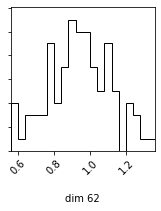

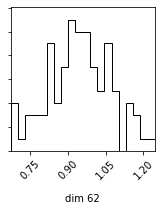

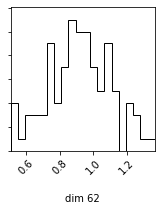

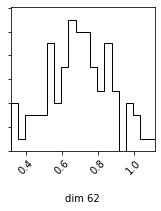

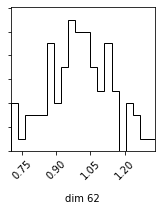

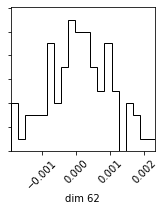

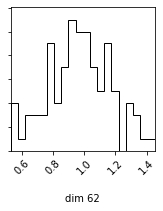

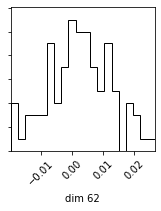

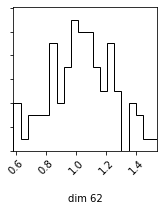

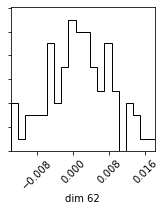

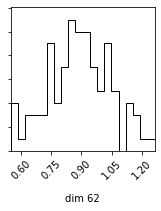

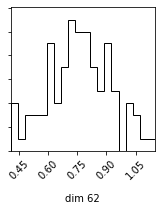

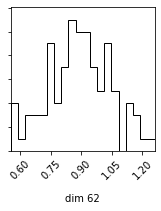

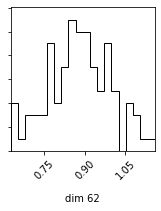

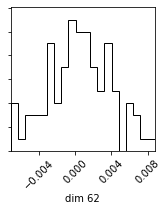

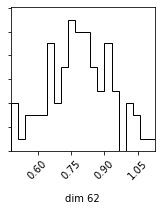

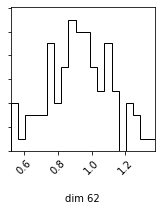

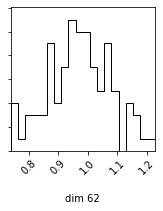

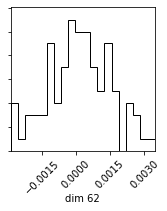

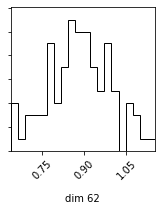

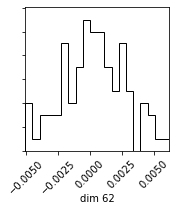

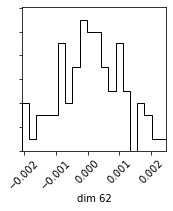

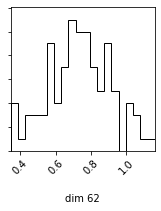

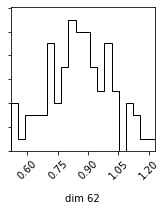

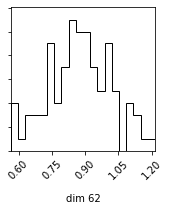

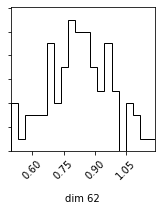

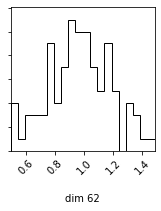

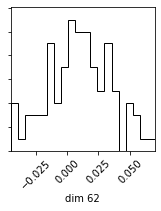

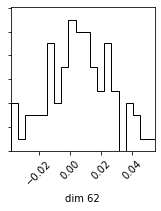

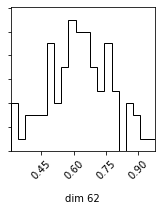

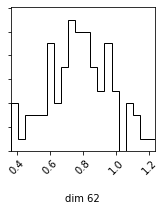

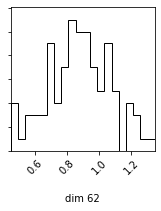

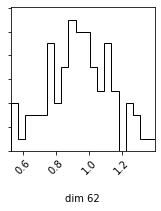

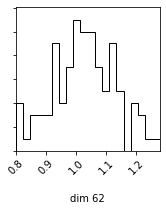

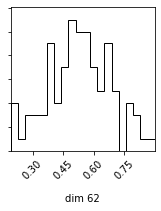

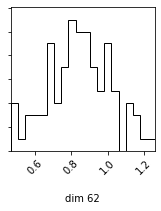

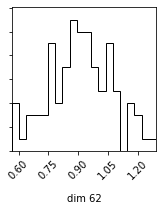

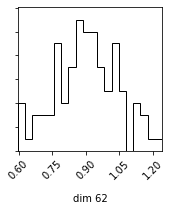

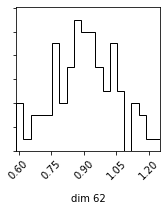

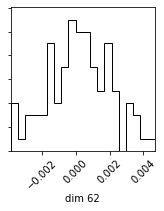

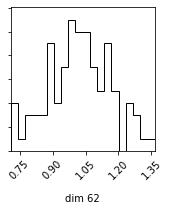

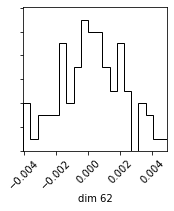

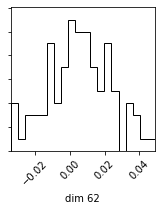

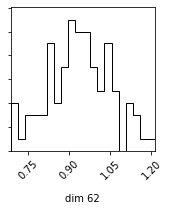

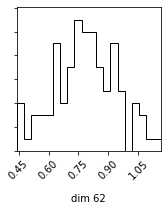

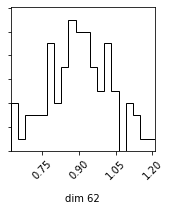

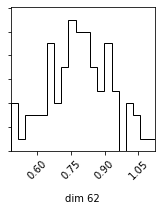

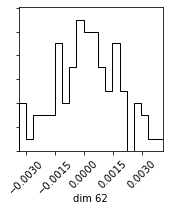

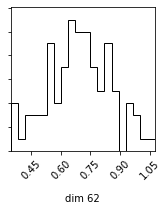

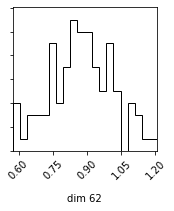

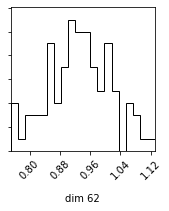

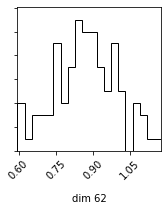

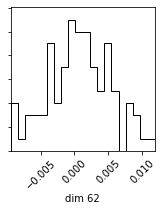

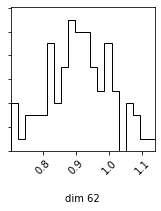

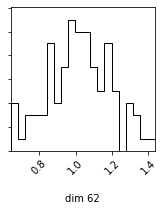

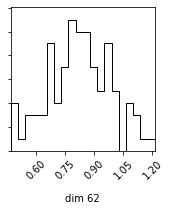

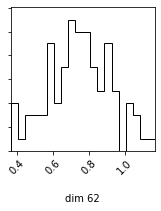

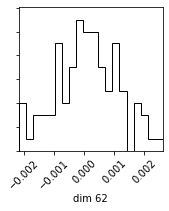

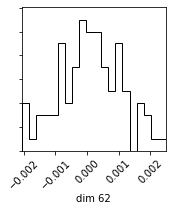

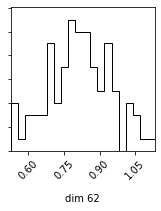

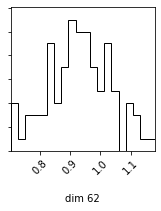

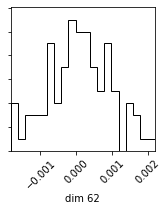

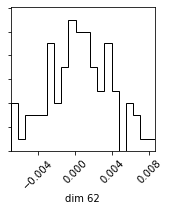

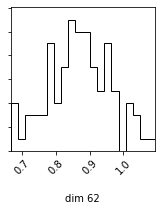

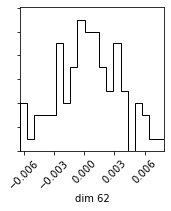

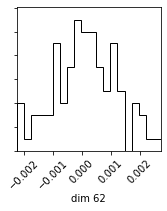

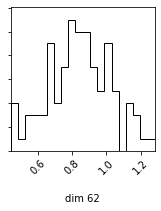

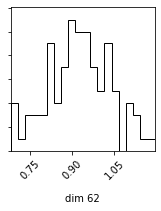

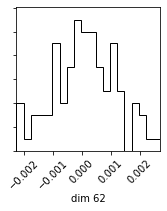

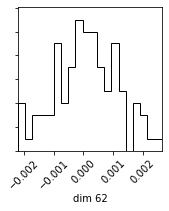

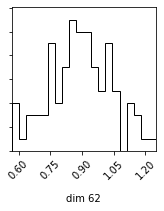

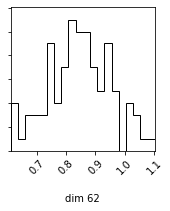

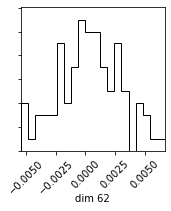

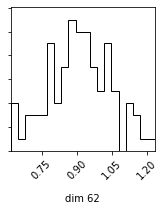

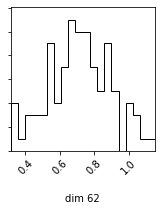

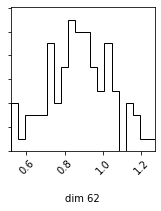

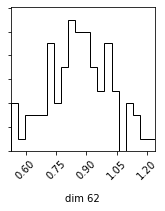

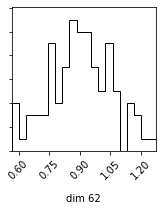

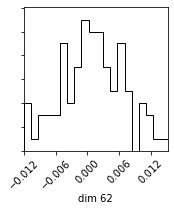

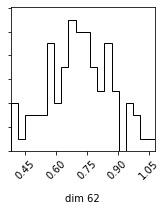

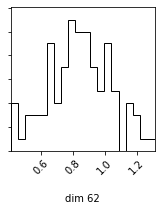

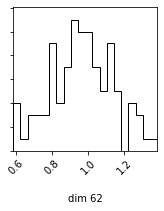

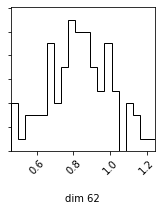

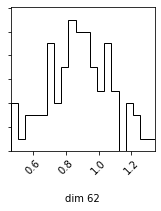

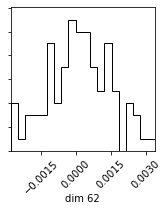

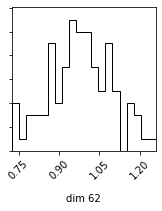

In [24]:
results_idx = []
results = []
for i, mdl in mdls.iterrows():
    
    print(i, end=', ')
    hypers = mdl.to_dict()

    try:
        if __name__ == "__main__":
            assert numpyro.__version__.startswith('0.2.4')
            parser = argparse.ArgumentParser(description="Gaussian Process example")
        #     parser.add_argument("-n", "--num-samples", nargs="?", default=1000, type=int)
        #     parser.add_argument("--num-warmup", nargs='?', default=500, type=int)
        #     parser.add_argument("--num-chains", nargs='?', default=1, type=int)
        #     parser.add_argument("--num-data", nargs='?', default=100, type=int)
        #     parser.add_argument("--num-dimensions", nargs='?', default=20, type=int)
        #     parser.add_argument("--active-dimensions", nargs='?', default=3, type=int)
        #     parser.add_argument("--device", default='cpu', type=str, help='use "cpu" or "gpu".')

            parser.add_argument("-n", "--num-samples", nargs="?", default=1000, type=int)
            parser.add_argument("--num-warmup", nargs='?', default=500, type=int)
            parser.add_argument("--num-chains", nargs='?', default=1, type=int)
            parser.add_argument("--num-data", nargs='?', default=63, type=int)
            parser.add_argument("--num-dimensions", nargs='?', default=145, type=int)
            parser.add_argument("--active-dimensions", nargs='?', default=15, type=int)
            parser.add_argument("--device", default='cpu', type=str, help='use "cpu" or "gpu".')

            #args = parser.parse_args() 
            args = parser.parse_args(args=[])

            numpyro.set_platform(args.device)
            numpyro.set_host_device_count(args.num_chains)

            fig = main(args, hypers)
            results_idx.append(i)
            results.append(fig)
            fig.show()

    except RuntimeError:
        continue

In [8]:
hypers = {#'expected_sparsity': max(1.0,args.num_dimensions // 10),
          'alpha1': 0.40097142738801805, 
          'alpha2': 0.47483035520083294, 
          'alpha3': 19.09608142822879, 
          'alpha_obs': 0.9711468316345567, 
          'beta1': 1.2402045085927398, 
          'beta2': 0.332604268922102, 
          'beta_obs': 0.24564582519281306, 
          'c': 29.7980082293205}

# hypers = {'expected_sparsity': max(1.0, args.num_dimensions / 10),
#           'alpha1': 3.0, 
#           'beta1': 1.0,
#           'alpha2': 3.0, 
#           'beta2': 1.0,
#           'alpha3': 1.0, 
#           'c': 1.0,
#           'alpha_obs': 50.0, 
#           'beta_obs': 1.0}

if __name__ == "__main__":
        assert numpyro.__version__.startswith('0.2.4')
        parser = argparse.ArgumentParser(description="Gaussian Process example")
    #     parser.add_argument("-n", "--num-samples", nargs="?", default=1000, type=int)
    #     parser.add_argument("--num-warmup", nargs='?', default=500, type=int)
    #     parser.add_argument("--num-chains", nargs='?', default=1, type=int)
    #     parser.add_argument("--num-data", nargs='?', default=100, type=int)
    #     parser.add_argument("--num-dimensions", nargs='?', default=20, type=int)
    #     parser.add_argument("--active-dimensions", nargs='?', default=3, type=int)
    #     parser.add_argument("--device", default='cpu', type=str, help='use "cpu" or "gpu".')

        parser.add_argument("-n", "--num-samples", nargs="?", default=1000, type=int)
        parser.add_argument("--num-warmup", nargs='?', default=500, type=int)
        parser.add_argument("--num-chains", nargs='?', default=1, type=int)
        parser.add_argument("--num-data", nargs='?', default=252, type=int)
        parser.add_argument("--num-dimensions", nargs='?', default=49, type=int)
        parser.add_argument("--active-dimensions", nargs='?', default=5, type=int)
        parser.add_argument("--device", default='cpu', type=str, help='use "cpu" or "gpu".')

        #args = parser.parse_args() 
        args = parser.parse_args(args=[])

        numpyro.set_platform(args.device)
        numpyro.set_host_device_count(args.num_chains)
        
        main(args, hypers)

KeyError: 'expected_sparsity'

In [23]:
results

[]